In [3]:
# IMPORT STATEMENTS
import cv2
import re
import requests
import io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches
import matplotlib.colors as colors
import PIL
import math
%matplotlib inline
import pandas as pdprePare
import seaborn as sns
import json
from scipy.stats import fisher_exact, ttest_ind
from collections import Counter
from pprint import pprint
import os
import pickle
import sys
import glob
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path.append('/booleanfs2/sahoo/Data/Macrophage/BN/')
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3
import Datasets
import MacUtils as mut
reload(mut)
import bone
reload(bone)

<module 'bone' from '/mnt/booleanfs2/sahoo/Data/BooleanLab/Yotam/bone.py'>

In [ ]:
yUrl='http://hegemon.ucsd.edu/~yovosko/Hegemon/explore.php'

In [ ]:
def getHegemonPatientInfo(dbid, urlbase='http://hegemon.ucsd.edu/Tools/explore.php'):
    url = urlbase + "?go=getpatientinfojson" + "&id=" + dbid
    response = requests.get(url)
    obj = json.loads(response.text)
    return  obj

def getHegemonPatientData(dbid, name, urlbase='http://hegemon.ucsd.edu/Tools/explore.php'):
    hdr = getHegemonPatientInfo(dbid, urlbase)
    clinical = 0
    if name in hdr:
        clinical = hdr.index(name)
    url = urlbase + "?go=getpatientdatajson" + "&id=" + dbid + "&clinical=" + str(clinical)
    response = requests.get(url)
    obj = json.loads(response.text)
    return  obj

def prepareDataDf(ana, dbid, urlBase='http://hegemon.ucsd.edu/Tools/explore.php'):
        ana.dbid = dbid
        ana.dataset = hu.getHegemonDataset(ana.dbid,urlBase)
        ana.num = ana.dataset[2]
        ana.name = ana.dataset[1]
        ana.source = ana.dataset[3]
        obj = hu.getHegemonPatientData(ana.dbid, 'time',urlBase)
        ana.headers = obj[0]
        ana.hhash = {}
        ana.start = 2;
        ana.end = len(ana.headers) - 1
        for i in range(len(ana.headers)):
            ana.hhash[ana.headers[i]] = i
def processDataDf(ana, l1, wt1,urlBase='http://hegemon.ucsd.edu/Tools/explore.php', desc=None, violin=1,show=False):
    ana.orderDataDf(l1, wt1,urlBase)
    if (violin == 1):
        return plotViolinBar(ana, desc,show)
    else:
        return bone.plotDensityBar(ana, desc)

def plotViolinBar(ana, desc=None,show=True):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': ["#00CC00", "#D8A03D","#EC008C"]}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': ["#00CC00", "#D8A03D","#EC008C"], 'vert': 0}
    ax = ana.printViolin(None, params)
    if show:
        plt.show()
    else:
        plt.close()
    return fig

In [4]:
reload(mut)

<module 'MacUtils' from '/mnt/booleanfs2/sahoo/Data/BooleanLab/Yotam/MacUtils.py'>

<a id="TOC"></a>
### Table of Contents
- [Datasets Code](#net_1)
- [Figure 2](#fig2)
- [Figure 3](#fig3)
- [Figure 6](#fig6)
- [Supplementary Figure 2](#sup2)
- [Check Annotations](#ann)

<a id="net_1"></a>
# Datasets Code
[Return](#TOC)

In [5]:
import bone
reload(bone)

confPath='/Users/yovosko/public_html/Hegemon/explore.conf'
confPathGlobal='/booleanfs2/sahoo/Hegemon/explore.conf'

def readLst(file,sep2=',',filt=set(['[']),lstSep=']'):
    """
    Inputs:
        file, str, path/name of file with list info
        sep2, str, what to use as a seperator for within lines of file
    Output:
        list of elements within file, split by \n and sep2
    """
    out=[]
    out1=[]
    with open(file) as f:
        for line in f:
            if lstSep in line:
                if len(out1)>0:
                    out.append(out1)
                    out1=[]
            for fil in filt:
                line=line.replace(fil,'')
            line=line.replace('\n','').replace(lstSep,'')
            if sep2!=' ':
                line=line.replace(' ','')
            out1.extend(line.split(sep2))
        out.append(out1)
    if len(out)==1:
        out=out[0]
    return out

def saveLst(lst,file):
    """
    saveLst:
        Input:
            lst, a list
            file, name of the file to create and save output to
        Actions: 
            Each element in the given list, is saved as a line in the file 
        Returns: 
            The name of the created file
    """
    with open(file,'w') as f:
        for num in range(len(lst)-1):
            elem = str(lst[num]);f.write(elem+'\n')
        elem = str(lst[len(lst)-1]);f.write(elem)
    return file

import bone
reload(bone)
aHegePath =  "/Users/aglina/public_html/Hegemon/explore.conf"
yHegePath = '/Users/yovosko/public_html/Hegemon/explore.conf'
confPathGlobal='/booleanfs2/sahoo/Hegemon/explore.conf'

class ExerciseAnalysis(bone.IBDAnalysis):

    def __init__(self):
        bone.IBDAnalysis.__init__(self)
    def getAuerbach2014(self,tn=1):
        self.prepareData('COV19',confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart','Skeletal Muscle']
            ahash={'Heart':1,'Spleen':0,'Skeletal muscle':2}
        if tn==2:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0}
        if tn==3:
            atype=tissue
            atypes=['Spleen','Skeletal muscle']
            ahash={'Skeletal muscle':1,'Spleen':0}
        if tn==4:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0,'Liver':2,'Kidney':3,'Bone marrow':4,
                   'Intestine':5,'Brain':6,'Skeletal muscle':7,'Primary rat hepatocytes':8}
        self.initData(atype, atypes, ahash)
        return
        
    def getImmGenULI2019(self,tn=1):
        self.prepareData('MAC81',confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0}
        if tn==2:
            atype=tissue
            atypes=['Splenic','Spleen','Heart']
            ahash={'Heart':2,'Splenic':0,'Spleen':1}
        self.initData(atype, atypes, ahash)
        return
    def getSato2020(self,tn=1):
        self.prepareData('MACV67',confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart','Skeletal Muscle']
            ahash={'Heart':1,'Spleen':0,'SkMuscle':2}
        if tn==2:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0}
        if tn==3:
            atype=tissue
            atypes=['Spleen','Skeletal Muscle']
            ahash={'Spleen':0,'SkMuscle':1}
        if tn==3:
            atype=tissue
            atypes=['Spl','H','Lung']
            ahash={'Stomach','Heart','SkMuscle','Thymus','Liver','Jejunum','Aorta','WAT','AdrenalG','Colon','Lung','Ileum',
                   'ParotidG','Kidney','BM','Spleen','Eye','Pancreas','Testis','ThyroidG','Skin','Skull','PituitaryG','Brain'}
        self.initData(atype, atypes, ahash)
        return
    def getKrause2022Rat(self,tn=1):
        self.prepareData('MACV336.2',confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0}
        self.initData(atype, atypes, ahash)
        return
    def getKrause2022Mouse(self,tn=1):
        self.prepareData('MACV336',confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'Heart':1,'Spleen':0}
        self.initData(atype, atypes, ahash)
        return
    def getHPA(self,tn=1):
        self.prepareData('GL20',confPathGlobal)
        tissue = self.h.getSurvName('c Tissue')
        if tn==1:
            atype=tissue
            atypes=['Spleen','Heart']
            ahash={'heart muscle':1,'spleen':0}
        self.initData(atype, atypes, ahash)
        return
    def getTakahama2024Sepsis(self, tn=1, ta=None):
        self.prepareData("MACV400",confPathGlobal)
        tissue = self.h.getSurvName('c tissue')
        treatment = self.h.getSurvName('c treatment')
        atype = tissue
        atypes = ['PBMC', 'BM', 'Spl', 'Thy', 'Ing', 'H', 'Kidney', 'SI', 'Colon',
                  'Liver', 'Lung', 'Brain', 'Skin']
        ahash = {'Bone marrow':1, 'Spleen':2, 'Lung':10, 'Kidney':6, 'Heart':5,
                 'Inguinal lymph node':4, 'Thymus':3, 'Liver':9, 'Colon':8,
                 'Small intestine':7, 'Brain':11, 'Skin':12, 'PBMC':0}
        if tn == 2:
            atype = treatment
            atypes = ['0', '0.25', '1', '2', '3', '5']
            ahash = {'LPS_d2':3, 'LPS_d0':0, 'LPS_d3':4,
                     'LPS_d0.25':1, 'LPS_d1':2, 'LPS_d5':5}
            if ta != None:
                atype = [atype[i] if tissue[i] == ta
                        else None for i in range(len(atype))]
        if tn == 3:
            atype = treatment
            atypes = ['c0.25', 'c1', 'mi0.25', 'mi1', 'mo0.25', 'mo1', 's0.25', 's1']
            ahash = {'CLP_sham_d0.25':0, 'CLP_mild_d1':3, 'CLP_sham_d1':1,
                     'CLP_moderate_d0.25':4, 'CLP_mild_d0.25':2, 'CLP_severe_d1':7,
                     'CLP_moderate_d1':5, 'CLP_severe_d0.25':6}
            if ta != None:
                atype = [atype[i] if tissue[i] == ta
                        else None for i in range(len(atype))]
        if tn==4:
            atype = tissue
            atypes = ['Spl','Kidney','H']
            ahash = {'Spleen':0, 'Kidney':1, 'Heart':2}
        if tn==5:
            atype = tissue
            atypes = ['Spleen','Heart']
            ahash = {'Spleen':0,'Heart':1}
        if tn==6:
            atype = tissue
            atypes = ['H','Lung']
            ahash = {'Heart':0,'Lung':1}
        self.initData(atype, atypes, ahash)
        return
        
    def getGlobal1(self,tn=1):
        self.prepareData("GL1",confPathGlobal)
        if tn==1:
            atype = self.h.getSurvName('c Macrophage')
            atypes = ["Other",'Mac']
            ahash = {"1":1, '0':0}
        self.initData(atype, atypes, ahash)
        return
    
    def getChen2002(self,tn=1):
        self.prepareData("MUSL112",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','1H','6H']
            ahash = {'1h':1, '1hPolysome':1, '6h':2, '6hPolysome':2, 'Polysome':0}
        if tn==2:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'1h':1, '1hPolysome':1,'Polysome':0}
        if tn==3:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'1h':1,'Polysome':0}
        if tn==4:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'1hPolysome':1,'Polysome':0}
        if tn==5:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'6h':1, '6hPolysome':1,'Polysome':0}
        if tn==6:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'6h':1,'Polysome':0}
        if tn==7:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Pre','Post']
            ahash = {'6hPolysome':1,'Polysome':0}
        self.initData(atype, atypes, ahash)
        return
        
    def getLavin2020(self,tn=1):
        self.prepareData("MUSL100",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c disease state_ch1")
            atypes = ["Ctrl",'PD']
            ahash = {"Parkinson's Disease":1, 'control':0}
        if tn==2:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ["Sed",'Ex']
            ahash = {'Basal_Parkinsons_Disease':0, 'Post-Training_Parkinsons_Disease':1}
        if tn==3:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ["PD",'Old','Young','PD-Ex']
            ahash = {'Basal_Parkinsons_Disease':0, 'Basal_Older_Adult':1,
                     'Basal_Young_Adult':2,'Post-Training_Parkinsons_Disease':3}
        if tn==4:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Old','Young']
            ahash = {'Basal_Older_Adult':0,'Basal_Young_Adult':1}
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Basal_Parkinsons_Disease Male':0,
                   'Post-Training_Parkinsons_Disease Male':1}
            atypes=['Sed PD Male','Ex PD Male']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Basal_Parkinsons_Disease Female':0,
                   'Post-Training_Parkinsons_Disease Female':1}
            atypes=['Sed PD Feamle','Ex PD Female']
        self.initData(atype, atypes, ahash)
        return
    def getLavin2020_2(self,tn=1):
        self.prepareData("PARK0",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ["Ctrl",'PD']
            ahash = {'Parkinson_disease':1, 'Old_adult':0, 'Young_adult':0}
        if tn==2:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ["Young",'Old','PD']
            ahash = {'Parkinson_disease':2, 'Old_adult':1, 'Young_adult':0}
        self.initData(atype, atypes, ahash)
        return
        
    def getLindholm2016(self,tn=1):
        self.prepareData("MUSL77",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c exercise status_ch1")
            atypes = ['Sed','Ex']
            ahash = {'untrained':0, 'trained':1}
        if tn==2:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'female untrained right leg':0,'female untrained left leg':0,
                   'female trained right leg':1,'female trained left leg':1}
            atypes=['Female Sed','Female Ex']
        if tn==3:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'male untrained left leg':0,'male untrained right leg':0,
                   'male trained left leg':1,'male trained right leg':1}
            atypes=['Male Sed','Male Ex']
        if tn==4:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'female untrained right leg':0,'female trained right leg':1}
            atypes=['Female Sed','Female Ex']
        if tn==5:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'male untrained right leg':0,'male trained right leg':1}
            atypes=['Male Sed','Male Ex']
        if tn==6:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'female untrained left leg':0,'female trained left leg':1}
            atypes=['Female Sed','Female Ex']
        if tn==7:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'male untrained left leg':0,'male trained left leg':1}
            atypes=['Male Sed','Male Ex']
        if tn==8:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'female untrained left leg':0,'female trained right leg':1}
            atypes=['Female Sed','Female Ex']
        if tn==9:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'male untrained left leg':0,'male trained right leg':1}
            atypes=['Male Sed','Male Ex']
        if tn==10:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'female untrained right leg':0,'female trained left leg':1}
            atypes=['Female Sed','Female Ex']
        if tn==11:
            atype= self.h.getSurvName('c condition_ch1')
            ahash={'male untrained right leg':0,'male trained left leg':1}
            atypes=['Male Sed','Male Ex']
        self.initData(atype, atypes, ahash)
        return
    
    def getShavlakadze2023(self,tn=1):
        self.prepareData("AGE2",aHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue (ch1)")
            atypes = ['Slow','Fast']
            ahash = {'soleus':0,'tibialis anterior':1,'diaphragm':0,'gastrocnemius':1}
        self.initData(atype, atypes, ahash)
        return
    
    def getMaier2022(self,tn=1):
        self.prepareData("MUSL122",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Sed/Pre','Post','Post 3H','Ex Night','Ex Day']
            ahash = {'sedentary control':0,'treadmill, sac +0h after exhausion':1,'treadmill, sac +3h after exhausion':2,
                     'running wheel acces during night':3,'running wheel acces during day':4}
        if tn==2:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Pre','Post','Post 3H']
            ahash = {'sedentary control':0,'treadmill, sac +0h after exhausion':1,'treadmill, sac +3h after exhausion':2}
        if tn==3:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Pre','Post']
            ahash = {'sedentary control':0,'treadmill, sac +0h after exhausion':1,'treadmill, sac +3h after exhausion':1}
        if tn==4:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Pre','Post']
            ahash = {'sedentary control':0,'treadmill, sac +0h after exhausion':1}
        if tn==5:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Pre','Post']
            ahash = {'sedentary control':0,'treadmill, sac +3h after exhausion':1}
        if tn==6:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Sed','Ex Night','Ex Day']
            ahash = {'sedentary control':0,'running wheel acces during night':1,'running wheel acces during day':2}
        if tn==7:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Sed','Ex']
            ahash = {'sedentary control':0,'running wheel acces during night':1,'running wheel acces during day':1}
        if tn==8:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Sed','Ex']
            ahash = {'sedentary control':0,'running wheel acces during night':1}
        if tn==9:
            atype = self.h.getSurvName('c treatment_ch1')
            atypes = ['Sed','Ex']
            ahash = {'sedentary control':0,'running wheel acces during day':1}
        
        self.initData(atype, atypes, ahash)
        return
    
    def getMaier2023(self,tn=1):
        self.prepareData("mmex2",aHegePath)
        if tn==1:
            atype = self.h.getSurvName("c Tissue")
            atypes = ['Slow','Fast']
            ahash = {'BF':1, 'EDL':1, 'Gas':1, 'Quad':1, 'SM':1, 'Sol':0, 'ST':1, 'TA':1}
        if tn==2:
            atype = self.h.getSurvName('c Group')
            atypes = ['Sed','Ex']
            ahash = {'Sed':0, 'RW':1}
        if tn==3:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Mus F','Rw Mus F','Sed Mus M','Rw Mus M','Sed Sol F','Rw Sol F','Sed Sol M','Rw Sol M']
            ahash = {'Sed_oMuscle_F':0, 'Sed_oMuscle_M':2,'RW_oMuscle_M':3,'RW_oMuscle_F':1,
                     'Sed_Sol_F':4,'RW_Sol_F':5,'Sed_Sol_M':6,'RW_Sol_M':7}
        if tn==4:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Mus F','Rw Mus F','Sed Mus M','Rw Mus M']
            ahash = {'Sed_oMuscle_F':0, 'Sed_oMuscle_M':2,'RW_oMuscle_M':3,'RW_oMuscle_F':1}
        if tn==5:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Muscle','Rw Muscle']
            ahash = {'Sed_oMuscle_F':0, 'Sed_oMuscle_M':0,'RW_oMuscle_M':1,'RW_oMuscle_F':1}
        if tn==6:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Muscle F','Rw Muscle F']
            ahash = {'Sed_oMuscle_F':0,'RW_oMuscle_F':1}
        if tn==7:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Muscle M','Rw Muscle M']
            ahash = {'Sed_oMuscle_M':0,'RW_oMuscle_M':1}
        if tn==8:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Sol F','Rw Sol F','Sed Sol M','Rw Sol M']
            ahash = {'Sed_Sol_F':0,'RW_Sol_F':1,'Sed_Sol_M':2,'RW_Sol_M':3}
        if tn==9:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Soleus','Rw Soleus']
            ahash = {'Sed_Sol_F':0,'RW_Sol_F':1,'Sed_Sol_M':0,'RW_Sol_M':1}
        if tn==10:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Soleus F','Rw Soleus F']
            ahash = {'Sed_Sol_F':0,'RW_Sol_F':1}
        if tn==11:
            atype = self.h.getSurvName('c Group Muscle Sex')
            atypes = ['Sed Soleus M','Rw Soleus M']
            ahash = {'Sed_Sol_M':0,'RW_Sol_M':1}
            
        
        self.initData(atype, atypes, ahash)
        return
    
    def getNair2024Muscle(self,tn=1):
        self.prepareData("MUSL79-0",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Slow','Fast']
            ahash = {'Vastus Lateralis Powder':1, 'Gastrocnemius Powder':0}
        if tn==2:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex 1 W','Ex 2 W','Ex 4 W','Ex 18 W']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':4,'Training - 4 weeks':3,
                     'Training - 1 week':1,'Training - 2 weeks':2}
        if tn==3:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':1}
        if tn==4:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':1,'Training - 4 weeks':1,
                     'Training - 1 week':1,'Training - 2 weeks':1}
        self.initData(atype, atypes, ahash)
        return
    def getMotorpac2024(self,tn=1):
        self.prepareData("MUSL79-1",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Spleen','Heart','Gastrocenmius Muscle','Skeletal Muscle']
            ahash = {'Heart Powder':1, 'Spleen Powder':0,'Gastrocnemius Powder':2,'Vastus Lateralis Powder':3}
        if tn==2:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex 1 W','Ex 2 W','Ex 4 W','Ex 18 W']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':4,'Training - 4 weeks':3,
                     'Training - 1 week':1,'Training - 2 weeks':2}
        if tn==3:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':1}
        if tn==4:
            atype = self.h.getSurvName("c treatment_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Control - 8 weeks':0,'Training - 8 weeks':1,'Training - 4 weeks':1,
                     'Training - 1 week':1,'Training - 2 weeks':1}
        self.initData(atype, atypes, ahash)
        return
    def getSeachrist2007(self,tn=1):
        self.prepareData("MUSL102",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Slow','Fast']
            ahash = {'gastrocnemius muscle':1, 'soleus muscle':0}
        self.initData(atype, atypes, ahash)
        return
        
    def getHam2020(self,tn=1):
        self.prepareData("MUSL106",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Slow','Fast']
            ahash = {'Extensor digitorum longus muscle':1,'Tibialis anterior muscle':1,'Soleus muscle':0,
                     'Triceps brachii muscle':1,'Gastrocnemius muscle':1}
        self.initData(atype, atypes, ahash)
        return 
        
    def getLee2022(self,tn=1,simpleNames=False):
        self.prepareData("MUSL104",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Slow','Fast']
            ahash = {'soleus':0,'gastrocnemius':1}
        if tn==2:
            atype = self.h.getSurvName("c intervention_ch1")
            atypes = ['Sed','Ex']
            ahash = {'control':0, '4 weeks of treadmill exercise':1}
        if tn==3:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'gastrocnemius of old control':0,'gastrocnemius of old exercise':1,
                   'gastrocnemius of young control':0,'gastrocnemius of young exercise':1,
                   'soleus of old control':0,'soleus of old exercise':1,'soleus of young control':0,
                   'soleus of young exercise':1}
            atypes=['Sed','Ex']
        if tn==4:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'gastrocnemius of old control':0,'gastrocnemius of old exercise':1,
                   'gastrocnemius of young control':0,'gastrocnemius of young exercise':1}
            atypes=['Sed Gast','Ex Gast']
        if tn==5:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'gastrocnemius of old control':0,'gastrocnemius of old exercise':1}
            atypes=['Sed G Old','Ex G Old']
        if tn==6:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'gastrocnemius of young control':0,'gastrocnemius of young exercise':1}
            atypes=['Sed G Young','Ex G Young']
        if tn==7:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'soleus of old control':0,'soleus of old exercise':1,'soleus of young control':0,
                   'soleus of young exercise':1}
            atypes=['Sed Sol','Ex Sol']
        if tn==8:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'soleus of old control':0,'soleus of old exercise':1}
            atypes=['Sed Sol Old','Ex Sol Old']
        if tn==9:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'soleus of young control':0,'soleus of young exercise':1}
            atypes=['Sed Sol Young','Ex Sol Young']
        if simpleNames:
            atypes=['Sed','Ex']
        self.initData(atype, atypes, ahash)
        return 
    
    def getSemenova2022(self,tn=1):
        self.prepareData("MUSL22",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c percent of fast fibers_ch1")
            atypes = ['Slow','Fast']
            ahash = {'36.5':0,'74.9':1,'40.7':0,'30.8':0,'28.9':0,'39.6':0,'68.6':1,'7.8':0,'69.4':1,'69.6':1,'65.6':1,
                     '31.7':0,'66.3':1,'64.5':1,'66.1':1,'72.4':1,'38.9':0,'32.7':0,
                     '16':0,'80.7':1,'35.4':0,'30':0,'69.3':1}
        self.initData(atype, atypes, ahash)
        return 
    
    def getdeJong2023(self,tn=1):
        self.prepareData("MUSL98",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Sed','Ex','Young']
            ahash = {'Frail':0, 'Fit':1, 'Young':2}
        if tn==2:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Sed','Ex']
            ahash = {'Frail':0, 'Fit':1}
        if tn==3:
            atype = self.h.getSurvName('c group_ch1')
            atypes = ['Sed','Ex']
            ahash = {'Fit':1, 'Young':0}
        if tn==4:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Male Frail':0,'Male Fit':1}
            atypes=['Male Sed','Male Ex']
        if tn==5:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Female Frail':0,'Female Fit':1}
            atypes=['Female Sed','Female Ex']
        if tn==6:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Male Frail':0,'Male Young':1}
            atypes=['Male Sed','Male Ex']
        if tn==7:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Female Frail':0,'Female Young':1}
            atypes=['Female Sed','Female Ex']
        if tn==8:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Male Fit':1,'Male Young':0}
            atypes=['Male Sed','Male Ex']
        if tn==9:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Female Fit':1,'Female Young':0}
            atypes=['Female Sed','Female Ex']
        if tn==10:
            atype = self.h.getSurvName('c grip_condition_ch1')
            ahash={'Male Frail Normal':0,'Female Frail Normal':0,
                   'Female Fit Normal':1,'Male Fit Normal':1}
            atypes=['Norm Sed','Norm Ex']
        if tn==11:
            atype = self.h.getSurvName('c grip_condition_ch1')
            ahash={'Male Frail Normal':0,'Female Frail Normal':0,
                   'Female Fit Normal':1,'Male Young Normal':1,'Female Young Normal':1,'Male Fit Normal':1}
            atypes=['Norm Sed','Norm Ex']
        if tn==12:
            atype = self.h.getSurvName('c grip_condition_ch1')
            ahash={'Male Frail Athlete':0,'Female Frail Athlete':0,'Male Fit Athlete':1,
                   'Female Fit Athlete':1}
            atypes=['Ath Sed','Ath Ex']
        self.initData(atype, atypes, ahash)
        return 
    
    def getEdman2024(self,tn=1):
        self.prepareData("MUSL97",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c group1_ch1')
            atypes = ['Pre','Post']
            ahash = {'RE_PRE':0,'RE_30min':1,'RE_3h':1}
        if tn==2:
            atype = self.h.getSurvName('c group1_ch1')
            atypes = ['Pre','30M','3H','8H','24H']
            ahash = {'RE_PRE':0,'RE_30min':1,'RE_3h':2,'RE_8h':3,'RE_24h':4}
        if tn==3:
            atype = self.h.getSurvName('c group1_ch1')
            atypes = ['Sed','Ex']
            ahash = {'RE_PRE':0,'RE_30min':0,'RE_3h':0,'RE_8h':0,'RE_24h':0,'CTRL_PRE':1,'CTRL_30min':1,'CTRL_3h':1,
                     'CTRL_8h':1,'CTRL_24h':1}
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_PRE':0,'male RE_30min':1,'male RE_3h':1}
            atypes=['Male Pre','Male Post']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_PRE':0,'female RE_30min':1,'female RE_3h':1}
            atypes=['Female Pre','Female Post']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_PRE':0,'male RE_30min':1}
            atypes=['Male Pre','Male 30M']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_PRE':0,'female RE_30min':1,}
            atypes=['Female Pre','Female 30M']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_PRE':0,'male RE_3h':1}
            atypes=['Male Pre','Male 3Hr']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_PRE':0,'female RE_3h':1}
            atypes=['Female Pre','Female 3Hr']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_PRE':0,'male RE_30min':0,'male RE_3h':0,
                   'male CTRL_PRE':1,'male CTRL_30min':1,'male CTRL_3h':1}
            atypes=['Male Sed','Male Ex']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_PRE':0,'female RE_30min':0,'female RE_3h':0,
                   'female CTRL_PRE':1,'female CTRL_30min':1,'female CTRL_3h':1}
            atypes=['Female Sed','Female Ex']
        if tn==12:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_PRE':1,'male CTRL_PRE':0}
            atypes=['Male Sed','Male Ex']
        if tn==13:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_PRE':1,'female CTRL_PRE':0}
            atypes=['Female Sed','Female Ex']
        if tn==14:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_30min':1,'male CTRL_30min':0}
            atypes=['Male Sed','Male Ex']
        if tn==15:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_30min':1,'female CTRL_30min':0}
            atypes=['Female Sed','Female Ex']
        if tn==16:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male RE_3h':1,'male CTRL_3h':0}
            atypes=['Male Sed','Male Ex']
        if tn==17:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female RE_3h':1,'female CTRL_3h':0}
            atypes=['Female Sed','Female Ex']
        self.initData(atype, atypes, ahash)
        return 
    
    def getFurrer2023(self,tn=1):
        self.prepareData("MUSL95",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c genotype_ch1")
            atypes = ['Slow','Fast']
            ahash = {'PGC-1alpha muscle-specific knockout':1, 'PGC-1alpha muscle-specific transgenic':0}
        if tn==2:
            atype = self.h.getSurvName("c genotype_ch1")
            atypes = ['Slow','Fast','Wt']
            ahash = {'PGC-1alpha muscle-specific knockout':1, 'PGC-1alpha muscle-specific transgenic':0,'wildtype':2}
        if tn==3:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'wildtype untrained, sedentary':0,'wildtype trained':1,
                     'PGC-1alpha muscle-specific knockout untrained, sedentary':0,
                     'PGC-1alpha muscle-specific transgenic untrained, sedentary':0,
                     'PGC-1alpha muscle-specific knockout trained':1,
                     'wildtype untrained, acute exercise':0,'wildtype trained, acute exercise':1,
                     'PGC-1alpha muscle-specific knockout untrained, acute exercise':0,
                     'PGC-1alpha muscle-specific knockout trained, acute exercise':1}
        if tn==4:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'wildtype untrained, sedentary':0,'wildtype trained':1,
                     'wildtype untrained, acute exercise':0,'wildtype trained, acute exercise':1}
        if tn==5:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'wildtype untrained, sedentary':0,'wildtype trained':1}
        if tn==6:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Pre','Post']
            ahash = {'wildtype untrained, acute exercise':0,'wildtype trained, acute exercise':1}
        if tn==7:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'PGC-1alpha muscle-specific knockout untrained, sedentary':0,
                     'PGC-1alpha muscle-specific knockout trained':1,
                     'PGC-1alpha muscle-specific knockout untrained, acute exercise':0,
                     'PGC-1alpha muscle-specific knockout trained, acute exercise':1}
        if tn==8:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'PGC-1alpha muscle-specific knockout untrained, sedentary':0,
                     'PGC-1alpha muscle-specific knockout trained':1}
        if tn==9:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Pre','Post']
            ahash = {'PGC-1alpha muscle-specific knockout untrained, exercise':0,
                     'PGC-1alpha muscle-specific knockout trained, exercise':1}
        self.initData(atype, atypes, ahash)
        return
        
    def getMSDBMuscle(self,tn=1):
        self.prepareData("MUSL0-1",yHegePath)
        atype = self.h.getSurvName("c Exercise_status_ch1")
        atypes = ['Sed', 'Ex']
        ahash = {' untrained':0, ' trained':1} 
        self.initData(atype, atypes, ahash)
        return
    
    def getMSDB2000(self,tn=1):
        self.prepareData("MUSCLE22.2",confPathGlobal)
        if tn==1:
            atype = self.h.getSurvName("c Exercise_status_ch1")
            atypes = ['Sed','Ex']
            ahash = {' untrained':0,' trained':1}
        if tn==2:
            atype = self.h.getSurvName("c SourceTissue_condition_ch1")
            atypes = ['Normal','Pathological']
            ahash = {'Ctrl':0,'Pathological':1}
        self.initData(atype, atypes, ahash)
        return
    def getTateno2013(self,tn=1):
        self.prepareData("MUSL8",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Spleen', 'Heart']
            ahash = {'heart':1, 'spleen':0}
        self.initData(atype, atypes, ahash)
        return
    def getSu2004(self,tn=1):
        self.prepareData("MUSL124",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Spleen', 'Heart']
            ahash = {'heart':1, 'spleen':0}
        self.initData(atype, atypes, ahash)
        return
    def getBeiter2024(self,tn=1):
        self.prepareData("MUSL125",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed Base', 'Ex Base', 'Sed 30M','Ex 30M','Sed 3H','Ex 3H']
            ahash = {'untrained baseline':0,'untrained +30min':2,
                     'untrained +3h':4,'trained baseline':1,'trained +30min':3,'trained +3h':5}
        if tn==2:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed', 'Ex']
            ahash = {'untrained baseline':0,'untrained +30min':0,
                     'untrained +3h':0,'trained baseline':1,'trained +30min':1,'trained +3h':1}
        if tn==3:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'untrained baseline':0,'trained baseline':1}
        if tn==4:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'untrained +30min':0,'trained +30min':1}
        if tn==5:
            atype = self.h.getSurvName("c group_ch1")
            atypes = ['Sed','Ex']
            ahash = {'untrained +3h':0,'trained +3h':1}
        self.initData(atype, atypes, ahash)
        return
    
    def getHoene2018(self,tn=1):
        self.prepareData("MUSL126",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Sed Ctrl','Ex Ctrl','Sed Vit-E','Ex Vit-E']
            ahash = {'Liver tissue from mice after treadmill run fed with control diet':1,
                     'Liver tissue from mice after treadmill run fed with vitamin E-enriched diet':3,
                     'Liver tissue from sedentary mice fed with control diet':0,
                     'Liver tissue from sedentary mice fed with vitamin E-enriched diet':2}
        if tn==2:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Liver tissue from mice after treadmill run fed with control diet':1,
                     'Liver tissue from mice after treadmill run fed with vitamin E-enriched diet':1,
                     'Liver tissue from sedentary mice fed with control diet':0,
                     'Liver tissue from sedentary mice fed with vitamin E-enriched diet':0}
        if tn==3:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Liver tissue from mice after treadmill run fed with control diet':1,
                     'Liver tissue from sedentary mice fed with control diet':0}
        if tn==4:
            atype = self.h.getSurvName("c source_name_ch1")
            atypes = ['Sed','Ex']
            ahash = {'Liver tissue from mice after treadmill run fed with vitamin E-enriched diet':1,
                     'Liver tissue from sedentary mice fed with vitamin E-enriched diet':0}
        
        self.initData(atype, atypes, ahash)
        return
    
    def getPopov2020(self,tn=1):
        self.prepareData("MUSL129",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post 2M','Post 1H','Post 3H','Post 6H']
            ahash = {'prior':0,'+ 2 min after exercise':1,'+ 1 h after exrecuse':2,
                     '+ 3 h after exrecuse':3,'+ 6 h after exrecuse':4}
        if tn==2:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post']
            ahash = {'prior':0,'+ 2 min after exercise':1,'+ 1 h after exrecuse':1,
                     '+ 3 h after exrecuse':1,'+ 6 h after exrecuse':1}
        if tn==3:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post']
            ahash = {'prior':0,'+ 2 min after exercise':1,'+ 1 h after exrecuse':1,
                     '+ 3 h after exrecuse':1}
        if tn==4:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post']
            ahash = {'prior':0,'+ 2 min after exercise':1,'+ 1 h after exrecuse':1}
        if tn==5:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post']
            ahash = {'prior':0,'+ 1 h after exrecuse':1}
        if tn==6:
            atype = self.h.getSurvName("c time point_ch1")
            atypes = ['Pre','Post']
            ahash = {'prior':0,'+ 2 min after exercise':1}
        self.initData(atype, atypes, ahash)
        return
    
    def getRubenstien2020(self,tn=1):
        self.prepareData("MUSL18",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c training.state_ch1")
            atypes = ['Sed', 'Ex']
            ahash = {'untrained':0, 'trained':1} 
        if tn==2:
            atype = self.h.getSurvName("c fiber-type_ch1")
            atypes = ['Slow', 'Fast']
            ahash = {'SLOW':0, 'FAST':1,'Type I':0,'Type IIa':1} 
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'basal Type I old':0,'basal Type IIa old':0,
                   'POST SLOW  OH':1,'POST FAST  OH':1}
            atypes=['Old Pre','Old Post']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'basal Type I old':0,'POST SLOW  OH':1}
            atypes=['Old T1 Pre','Old T1 Post']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'basal Type IIa old':0,'POST FAST  OH':1}
            atypes=['Old T2 Pre','Old T2 Post']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE SLOW  LLE':0,'POST SLOW  LLE':1,
                   'PRE FAST  LLE':0,'POST FAST  LLE':1}
            atypes=['Old Ath Pre','Old Ath Post']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE SLOW  LLE':0,'POST SLOW  LLE':1}
            atypes=['Old Ath T1 Pre','Old Ath T1 Post']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE FAST  LLE':0,'POST FAST  LLE':1}
            atypes=['Old Ath T2 Pre','Old Ath T2 Post']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE SLOW  YE':0,'POST SLOW  YE':1,
                   'PRE FAST  YE':0,'POST FAST  YE':1}
            atypes=['Young Pre','Young Post']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE SLOW  YE':0,'POST SLOW  YE':1}
            atypes=['Young T1 Pre','Young T1 Post']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'PRE FAST  YE':0,'POST FAST  YE':1}
            atypes=['Young T2 Pre','Young T2 Post']
        self.initData(atype, atypes, ahash)
        return 
    def getSu2015(self, tn=1):
        self.prepareData("MSL2",confPathGlobal)
        atype = self.h.getSurvName("c Trained or Immobilized")
        atypes = ['Sed', 'Ex']
        ahash = {'Yes':1,'No':0} 
        self.initData(atype, atypes, ahash)    
        return
    def getRoth2007(self,tn=1):
        self.prepareData("MUSL5",yHegePath)
        atype = self.h.getSurvName("c Tissue/Cell Line [C]_ch1")
        atypes = ['Spleen', 'Heart']
        ahash = {'heart_atrium':1, 'spleen':0,'heart_ventricle':1,'heart':1}
        self.initData(atype, atypes, ahash)    
        return
    def getMoore2023Muscle(self, tn=1):
        self.prepareData("M105-1",yHegePath)
        atype = self.h.getSurvName("c exercise group_ch1")
        atypes = ['Sed', 'Ex']
        ahash = {'Sedentary':0, 'Exercised':1}
        self.initData(atype, atypes, ahash)    
        return
    def getMoore2023(self, tn=1):
        self.prepareData("M105-0",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c exercise group_ch1")
            atypes = ['Sed', 'Ex']
            ahash = {'Sedentary':0, 'Exercised':1}
        if tn==2:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Quad', 'Liv','H','Gonad WAT','BAT']
            ahash = {'quadriceps':0,'liver':1,'heart':2,'gonadal white adipose tissue':3,'brown adipose tissue':4}
        if tn==3:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Spleen','Heart']
            ahash = {'heart':1,'gonadal white adipose tissue':0}
        if tn==4:
            atype = self.h.getSurvName("c tissue_ch1")
            atypes = ['Spleen','Quadriceps']
            ahash = {'quadriceps':1,'gonadal white adipose tissue':0}
        self.initData(atype, atypes, ahash)    
        return
    
    def getGTExMuscle(self, tn=1, ta=0, tb=0):
        self.prepareData("GTEx6",aHegePath)
        atype = self.h.getSurvName("c AGE")
        atypes = ['Y', 'O']
        ahash = {'60-69':1, '20-29':0, '30-39':0,  '70-79':1} #removed '50-59':1 '40-49':0,
        self.initData(atype, atypes, ahash)    
        return
    def getMuscleAgeAtlas(self, tn=1, ta=0, tb=0):
        self.prepareData("M24",yHegePath)
        atype = self.h.getSurvName("c age_ch1")
        atypes = ['Y', 'O']
        ahash = {'23':0, '28':0, '31':0, '35':0, '38':0, '42':0, '45':0, '60':1, '67':1, '72':1, '73':1, '80':1, '81':1,
       '83':1, '22':0, '25':0, '26':0, '27':0, '33':0, '37':0, '47':0, '62':1, '63':1, '69':1, '70':1, '76':1} #removed '50-59':1 51, 52, 57, 58, ...  54 #pd.unique(yt["c age_ch1"])
        self.initData(atype, atypes, ahash)    
        return
    def getTimmons1(self, tn=1, ta=0, tb=0):
        self.prepareData("M1-1",yHegePath)
        atype = self.h.getSurvName("c age group_ch1")
        atypes = ['Y', 'O']
        ahash = {'young adult':0, 'middle aged adult':1} #removed '50-59':1
        self.initData(atype, atypes, ahash)    
        return
    def getBigTimmons(self, tn=1, ta=0, tb=0):
        self.prepareData("M25",yHegePath)
        atype = self.h.getSurvName("c developmental stage (ch1)")
        atypes = ['Y', 'O']
        ahash = {'young adult':0, 'older adult':1} #removed '50-59':1
        self.initData(atype, atypes, ahash)    
        return
    def getTimmons2020(self, tn=1,mn=0):
        if mn<3 and mn>-1:
            mn= 'M00'+str(mn)
        else:
            print('Error: '+str(mn)+' does not exsist')
        self.prepareData(mn,yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c training status_ch1")
            ahash = {'POST':1, 'PRE':0,'POST_Unloading':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName("c training status_ch1")
            ahash = {'POST':1, 'PRE':0,'POST_Unloading':2}
            atypes=['Sed','Ex Resist','Ex Unload']
        if tn==3:
            atype = self.h.getSurvName("c training status Age_ch1")
            ahash = {'PRE young':0, 'PRE middle':2,'POST young':1,'POST middle':3}
            atypes=['Sed Young','Ex Young','Sed Mid','Ex Mid']
        if tn==4:
            atype = self.h.getSurvName("c training status Age_ch1")
            ahash = {'PRE young':0,'POST young':1}
            atypes=['Sed Young','Ex Young']
        if tn==5:
            atype = self.h.getSurvName("c training status Age_ch1")
            ahash = {'PRE middle':0,'POST middle':1}
            atypes=['Sed Mid','Ex Mid']
        if tn==6:
            atype = self.h.getSurvName("c training status_ch1")
            ahash = {'POST':1, 'PRE':0}
            atypes=['Sed','Ex']
        if tn==7:
            atype = self.h.getSurvName("c training status_ch1")
            ahash = {'PRE':0,'POST_Unloading':1}
            atypes=['Sed','Ex']
            
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def getRundqvist2019(self, tn=1,simpleNames=False):
        self.prepareData("M2",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time_ch1")
            ahash = {'post-exercise':1, 'pre-exercise':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c gender time _ch1")
            ahash = {'male pre-exercise':0,'female pre-exercise':2,'male post-exercise':1,'female post-exercise':3}
            atypes=['Pre Male','Ex Male','Pre Female','Ex Female']
        if tn==3:
            atype = self.h.getSurvName("c gender time _ch1")
            ahash = {'male pre-exercise':0,'male post-exercise':1}
            atypes=['Pre Male','Ex Male']
        if tn==4:
            atype = self.h.getSurvName("c gender time _ch1")
            ahash = {'female pre-exercise':0,'female post-exercise':1}
            atypes=['Pre Female','Ex Female']
        if simpleNames:
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
            
        self.initData(atype, atypes, ahash)
        return

    def getKnudsen2020(self, tn=1,simpleNames=False):
        self.prepareData("M3",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment (ch1)")
            ahash = {'Untrained':0, '5 weeks endurance exercise':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName("c genotype treatment (ch1)")
            ahash = {'Wild Pre':0, 'Il13 Pre':2,'Wild Post':1,'Il13 Post':3}
            atypes=['Wild Pre','Wild Post','Il13 Pre','Il13 Post']
        if tn==3:
            atype = self.h.getSurvName("c genotype treatment (ch1)")
            ahash = {'Wild Pre':0,'Wild Post':1}
            atypes=['Wild Pre','Wild Post']
        if tn==4:
            atype = self.h.getSurvName("c genotype treatment (ch1)")
            ahash = {'Il13 Pre':0,'Il13 Post':1}
            atypes=['Il13 Pre','Il13 Post']
        if simpleNames:
            atypes=['Sed','Ex']
        
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getKnuiman2020(self, tn=1):
        self.prepareData("M4",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time point_ch1")
            ahash = {'baseline':0, 'midterm':1}
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getPopov2019(self, tn=1,simpleNames=False):
        self.prepareData("M5",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c training status (ch1)")
            ahash = {'untrained':0, 'trained':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName("c training status exercise leg (ch1)")
            ahash = {'untrained NE':0,'trained NE':1}
            atypes=['Untrain NE','Train NE']
        if tn==3:
            atype = self.h.getSurvName("c training status exercise leg (ch1)")
            ahash = {'untrained Ex':0,'trained Ex':1}
            atypes=['Untrain EX','Train Ex']
        if tn==4:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'untrained baseline':0, 'untrained 1 ':1,'untrained 4 ':2,
                     'trained baseline':3, 'trained 1 ':4,'trained 4 ':5}
            atypes=['Base Untrain','1H Untrain','4H Untrain','Base Train','1H Train','4H Train']
        if tn==5:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained baseline':0, 'trained 1 ':1,'trained 4 ':2}
            atypes=['Base Train','1H Train','4H Train']
        if tn==6:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained baseline':1, 'untrained baseline':0}
            atypes=['Base Untrain','Base Train']
        if tn==7:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained 1 ':1, 'untrained 1 ':0}
            atypes=['1H Untrain','1H Train']
        if tn==8:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained 4 ':1, 'untrained 4 ':0}
            atypes=['4H UnTrain','4H Train']
        if tn==9:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'untrained baseline':0, 'untrained 1 ':1,'untrained 4 ':2}
            atypes=['Base Untrain','1H Untrain','4H Untrain']
        
        if tn==10:
            atype = self.h.getSurvName("c exercised/non-exercised muscle (ch1)")
            ahash = {'non-exercised (NE)':0, 'exercised (Ex)':1}
            atypes=['NE Leg','Ex Leg']
        if tn==11:
            atype = self.h.getSurvName("c training status exercise leg (ch1)")
            ahash = {'untrained Ex':0,'untrained NE':1}
            atypes=['Untrain EX','Untrain NE']
        if tn==12:
            atype = self.h.getSurvName("c training status exercise leg (ch1)")
            ahash = {'trained Ex':0,'trained NE':1}
            atypes=['Train EX','Train NE']
        if tn==13:
            atype = self.h.getSurvName("c training status exercise leg (ch1)")
            ahash = {'untrained NE':0, 'untrained Ex':2,'trained NE':1,'trained Ex':3}
            atypes=['Untrain NE','Train NE','Untrain EX','Train Ex']
        if tn==14:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained baseline':0, 'trained 1 ':1}
            atypes=['Base Train','1H Train']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==15:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained baseline':0,'trained 4 ':1}
            atypes=['Base Train','4H Train']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==16:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'trained baseline':0, 'trained 1 ':1,'trained 4 ':1}
            atypes=['Base Train','Post Train']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==17:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'untrained baseline':0, 'untrained 1 ':1}
            atypes=['Base Untrain','1H Untrain']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==18:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'untrained baseline':0,'untrained 4 ':1}
            atypes=['Base Untrain','4H Untrain']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==19:
            atype = self.h.getSurvName("c training status time (ch1)")
            ahash = {'untrained baseline':0, 'untrained 1 ':1,'untrained 4 ':1}
            atypes=['Base Untrain','Post Untrain']
            if simpleNames:
                atypes=['Pre','Post']
        
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMarosi2018(self, tn=1,simpleNames=False):
        self.prepareData("M6",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment 2 (ch1)")
            ahash = {'Control':0, 'Exercised':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c treatment (ch1)")
            ahash = {'Control':0, 'Alternate day fasting':1,'Exercised':2,'Exercised_Alternate day fasting':3}
            atypes=['Pre','Pre & Fast','Post','Post & Fast']
        if tn==3:
            atype = self.h.getSurvName("c treatment (ch1)")
            ahash = {'Control':0,'Exercised':1}
            atypes=['Pre No Fast','Post No Fast']
        if tn==4:
            atype = self.h.getSurvName("c treatment (ch1)")
            ahash = {'Alternate day fasting':0,'Exercised_Alternate day fasting':1}
            atypes=['Pre & Fast','Post & Fast']
        if tn==5:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Liver Control':0,'Liver Exercised':1,'Liver Alternate day fasting':0,
                     'Liver Exercised_Alternate day fasting':1,'Soleus Control':0,'Soleus Alternate day fasting':0,
                     'Soleus Exercised':1,'Soleus Exercised_Alternate day fasting':1}
            atypes=['Pre','Post']
        if tn==6:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Liver Control':0,'Liver Exercised':1,'Liver Alternate day fasting':0,
                     'Liver Exercised_Alternate day fasting':1}
            atypes=['Liver Pre','Liver Post']
        if tn==7:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Liver Control':0,'Liver Exercised':1}
            atypes=['Liver Pre','Liver Post']
        if tn==8:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Liver Alternate day fasting':0,
                     'Liver Exercised_Alternate day fasting':1}
            atypes=['Liver Pre','Liver Post']
        if tn==9:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Soleus Control':0,'Soleus Alternate day fasting':0,
                     'Soleus Exercised':1,'Soleus Exercised_Alternate day fasting':1}
            atypes=['Sol Pre','Sol Post']
        if tn==10:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Soleus Control':0,'Soleus Exercised':1}
            atypes=['Sol Pre','Sol Post']
        if tn==11:
            atype = self.h.getSurvName('c group (ch1)')
            ahash = {'Soleus Alternate day fasting':0,'Soleus Exercised_Alternate day fasting':1}
            atypes=['Sol Pre','Sol Post']
            

        if simpleNames:
            if len(atypes)==2:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getClarke2018(self, tn=1):
        self.prepareData("M7",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c status_ch1")
            ahash = {'pre-training':0, 'post-training':1}
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def m(self, tn=1):
        self.prepareData("M9",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'Pre':0, 'Post':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c time point_ch1")
            ahash = {'before':0, '4 hours after exercise':1,'8 hours after exercise':2}
            atypes=['Pre','4H Post','8H Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getPoelkens2013(self, tn=1,simpleNames=False):
        self.prepareData("M10",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time (ch1)")
            ahash = {'baseline':0, '6 months':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName('c treatment (ch2)')
            ahash = {'Post Healthy':1,'Post Metabolic Syndrome':3,'Pre Healthy':0,'Pre Metabolic Syndrome':2}
            atypes=['Sed Healthy','Ex Healthy','Sed Metabolic','Ex Metabolic']
        if tn==3:
            atype = self.h.getSurvName('c treatment (ch2)')
            ahash = {'Post Healthy':1,'Pre Healthy':0}
            atypes=['Sed Healthy','Ex Healthy']
        if tn==4:
            atype = self.h.getSurvName('c treatment (ch2)')
            ahash = {'Post Metabolic Syndrome':1,'Pre Metabolic Syndrome':0}
            atypes=['Sex Metabolic','Ex Metabolic']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getSchjerling2014(self, tn=1,simpleNames=False):
        self.prepareData("M11",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c exercise state_ch2")
            ahash = {'before':0, '2.5 strength':1,'2.5 endurance':1,'5 strength':1,'5 endurance':1,'2.5 hours control':0,
                     '5 hours control':0}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName("c training type_ch1")
            ahash = {'Control':0, 'Endurance':1,'Strength':2}
            atypes=['Pre','Endurance','Strength']
        if tn==3:
            atype = self.h.getSurvName("c training type_ch1")
            ahash = {'Control':0, 'Endurance':1}
            atypes=['Pre','Endurance']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==4:
            atype = self.h.getSurvName("c training type_ch1")
            ahash = {'Control':0,'Strength':1}
            atypes=['Pre','Strength']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==5:
            atype = self.h.getSurvName("c training type_ch1")
            ahash = {'Endurance':0,'Strength':1}
            atypes=['Endurance','Strength']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==6:
            atype = self.h.getSurvName("c timepoint_ch1")
            ahash = {'pre':0, '2.5 post':1,'5 post':2}
            atypes=['Pre','2.5H Post','5H Post']
        if tn==7:
            atype = self.h.getSurvName("c exercise state_ch2")
            ahash = {'before':0, '2.5 strength':1,'2.5 endurance':2,'5 strength':3,'5 endurance':4,'2.5 hours control':5,
                     '5 hours control':6}
            atypes=['Pre','2.5H Strength','2.5H endurance','2.5H Control','5H Strength','5H Enduracne','5H Control']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getKalko2014(self, tn=1):
        self.prepareData("M12",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c exercise state_ch1")
            ahash = {'sedentary':0,'trained':1}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary healthy':0,'Trained healthy':1,'Sedentary COPD with normal BMI':2,
                     'Trained COPD with normal BMI':3}
            atypes=['Untrain Healthy','Train Healthy','Untrain COPD',"Train COPD"]
        if tn==3:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary healthy':0,'Trained healthy':1}
            atypes=['Untrain Healthy','Train Healthy']
        if tn==4:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary COPD with normal BMI':0,'Trained COPD with normal BMI':1}
            atypes=['Untrain COPD',"Train COPD"]
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getCatoire2014(self, tn=1):
        self.prepareData("M13",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time_ch1")
            ahash = {'pre':0,'post':1}
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getTuran2011(self, tn=1):
        self.prepareData("M14",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c exercise state_ch1")
            ahash = {'sedentary':0,'trained':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary COPD with low BMI':2,'Sedentary COPD with normal BMI':4,'Sedentary healthy':0,
                     'Trained COPD with low BMI':3,'Trained COPD with normal BMI':5,'Trained healthy':1}
            atypes=['Untrain Healthy','Train Healthy','Untrain COPD Low BMI',"Train COPD Low BMI",'Untrain COPD',"Train COPD"]
        if tn==3:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary healthy':0,'Trained healthy':1}
            atypes=['Sed Healthy','Ex Healthy']
        if tn==4:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary COPD with low BMI':0,'Trained COPD with low BMI':1}
            atypes=['Sed COPD Low BMI',"Ex COPD Low BMI"]
        if tn==5:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'Sedentary COPD with normal BMI':0,'Trained COPD with normal BMI':1}
            atypes=['Sed COPD',"Ex COPD"]
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getNeubauer2013(self, tn=1,simpleNames=False):
        self.prepareData("M15",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time point_ch1")
            ahash = {'baseline':0,'3':1,'48':1,'96':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c time point_ch1")
            ahash = {'baseline':0,'3':1,'48':2,'96':3}
            atypes=['Pre','3H','48H','96H']
        if tn==3:
            atype = self.h.getSurvName("c tissue time point_ch1")
            ahash = {'blood PMN 3':1,'blood PMN 48':2,'blood PMN 96':3,'blood PMN baseline':0,
                     'skeletal muscle (SMU) 3':5,'skeletal muscle (SMU) 48':6,'skeletal muscle (SMU) 96':7,
                     'skeletal muscle (SMU) baseline':4}
            atypes=['Pre Blood','3H Blood','48H Blood','96H Blood','Pre Muscle','3H Muscle','48H Muscle','96H Muscle']
        if tn==4:
            atype = self.h.getSurvName("c tissue time point_ch1")
            ahash = {'blood PMN 3':1,'blood PMN 48':2,'blood PMN 96':3,'blood PMN baseline':0}
            atypes=['Pre Blood','3H Blood','48H Blood','96H Blood']
        if tn==5:
            atype = self.h.getSurvName("c tissue time point_ch1")
            ahash = {'blood PMN 3':1,'blood PMN baseline':0}
            atypes=['Pre Blood','3H Blood']
        if tn==6:
            atype = self.h.getSurvName("c tissue time point_ch1")
            ahash = {'skeletal muscle (SMU) 3':1,'skeletal muscle (SMU) 48':2,'skeletal muscle (SMU) 96':3,
                     'skeletal muscle (SMU) baseline':0}
            atypes=['Pre Muscle','3H Muscle','48H Muscle','96H Muscle']
        if tn==7:
            atype = self.h.getSurvName("c tissue time point_ch1")
            ahash = {'skeletal muscle (SMU) 3':1,'skeletal muscle (SMU) baseline':0}
            atypes=['Pre Muscle','3H Muscle']
        if tn==8:
            atype = self.h.getSurvName("c time point_ch1")
            ahash = {'baseline':0,'3':1}
            atypes=['Pre','Post']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Pre','Post']
        
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getEngeli2012(self, tn=1):
        self.prepareData("M16",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'control':0,'8-week training':1}
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getCatoire2012(self,tn=1):
        self.prepareData("M17",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c time_ch1")
            ahash = {'baseline (T0)':0, 'post_exercise (T1)':1}
            atypes=['Pre','Post']
        if tn==2: 
            atype = self.h.getSurvName("c exercised leg_ch2")
            ahash = {'Ex':1, 'NE':0}
            atypes=['NE','Ex']
        if tn==3:
            atype = self.h.getSurvName("c exercised leg time_ch1")
            ahash = {'Ex baseline (T0)':2,'Ex post_exercise (T1)':3,'NE baseline (T0)':0,'NE post_exercise (T1)':1}
            atypes=['Pre NE','Post NE','Pre Ex','Post Ex']
        if tn==4:
            atype = self.h.getSurvName("c exercised leg time_ch1")
            ahash = {'Ex baseline (T0)':0,'Ex post_exercise (T1)':1}
            atypes=['Pre Ex','Post Ex']
        if tn==5:
            atype = self.h.getSurvName("c exercised leg time_ch1")
            ahash = {'NE baseline (T0)':0,'NE post_exercise (T1)':1}
            atypes=['Pre NE','Post NE']
        if tn==6:
            atype = self.h.getSurvName("c exercised leg time_ch1")
            ahash = {'Ex baseline (T0)':1,'NE baseline (T0)':0}
            atypes=['Pre NE','Pre Ex']
        if tn==7:
            atype = self.h.getSurvName("c exercised leg time_ch1")
            ahash = {'Ex post_exercise (T1)':1,'NE post_exercise (T1)':0}
            atypes=['Post NE','Post Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
    def getNarkar2008(self, tn=1,simpleNames=False):
        self.prepareData("M21-0",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'Vehicle':0,'Exercise':1,'GW + Exercise':3,'GW':2}
            atypes=['Untrain','Train','GW','GW & Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'Vehicle':0,'Exercise':1,'GW + Exercise':1,'GW':0}
            atypes=['Untrain & GW','Train & GW']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'Vehicle':0,'Exercise':1}
            atypes=['Untrain','Train']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'GW + Exercise':1,'GW':0}
            atypes=['GW','GW & Train']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getScheler2013(self, tn=1):
        self.prepareData("M23",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c sample group_ch1")
            ahash = {'control':0,'in-vitro electric pulse stimulation (EPS) for 24hr':1}
            atypes=['Ctrl','EPS Stim']
        if tn==2:
            atype = self.h.getSurvName('c condition_gender_ch1')
            ahash={'female in-vitro electric pulse stimulation (EPS) for 24hr':1,'female control':0}
            atypes=['Female Ctrl','Female EPS']
        if tn==3:
            atype = self.h.getSurvName('c condition_gender_ch1')
            ahash={'male in-vitro electric pulse stimulation (EPS) for 24hr':1,'male control':0}
            atypes=['Male Ctrl','Male EPS']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    
    def getTimmons2018(self, tn=1):
        self.prepareData("M25",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c developmental stage_ch1")
            ahash = {'young adult':0,'middle aged adult':1,'older adult':2}
            atypes=['Young','Mid','Old']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return

    def getKhakehi2020(self, tn=1):
        self.prepareData("M27",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'control':0,'endurance-trained':1}
            atypes=['Ctrl','Endur Ath']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getDeSanctis2021(self, tn=1,simpleNames=False):
        self.prepareData("M28",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'sedentary':0,'resistance trained':1,'endurance trained':1}
            atypes=['Sedentary','Athlete']
        if tn==2:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'sedentary':0,'resistance trained':1,'endurance trained':2}
            atypes=['Sedentary','Resistance','Endurance']
        if tn==3:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'sedentary':0,'resistance trained':1}
            atypes=['Sedentary','Resistance']
        if tn==4:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'sedentary':0,'endurance trained':1}
            atypes=['Sedentary','Endurance']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getKivela2010(self, tn=1):
        self.prepareData("M29",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c strain (ch1)")
            ahash = {'low intrinsic aerobic capacity runners':0,'high intrinsic aerobic capacity runners':1}
            atypes=['Non-Ath Rat','Ath Rat']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMahoney2005(self, tn=1):
        self.prepareData("M31",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition time point_ch1')
            ahash = {'Endurance 3H':1, 'Endurance 48H':0, 'Resistance 3H':3, 'Resistance 48H':2}
            atypes=['Endur 48H','Endur 3H','Resist 48H','Resist 3H']
        if tn==2:
            atype = self.h.getSurvName('c condition time point_ch1')
            ahash = {'Endurance 3H':1, 'Endurance 48H':0}
            atypes=['Endur 48H','Endur 3H']
        if tn==3:
            atype = self.h.getSurvName('c condition time point_ch1')
            ahash = {'Resistance 3H':1, 'Resistance 48H':0}
            atypes=['Resist 48H','Resist 3H']
        if tn==4:
            atype = self.h.getSurvName('c condition time point_ch1')
            ahash = {'Endurance 3H':1, 'Endurance 48H':0, 'Resistance 3H':1, 'Resistance 48H':0}
            atypes=['48H','3H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getStepto2009(self, tn=1):
        self.prepareData("M32",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'Control':0,'Endurance Trained':1,'Strength trained':2,'Endurance trained':1}
            atypes=['Ctrl','Endur Athl','Resist Athl']
        if tn==2:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'Control':0,'Endurance Trained':1,'Endurance trained':1}
            atypes=['Ctrl','Endur Athl']
        if tn==3:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'Control':0,'Strength trained':1}
            atypes=['Ctrl','Resist Athl']
        if tn==4:
            atype = self.h.getSurvName("c group (ch1)")
            ahash = {'Control':0,'Endurance Trained':1,'Strength trained':1,'Endurance trained':1}
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getVega2020(self, tn=1):
        self.prepareData("M33",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'PRE ATHLETE':2, 'PRE LEAN':1, 'PRE obese':0}
            atypes=['Obese','Lean','Athlete']
        if tn==2:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'PRE ATHLETE':1, 'PRE LEAN':0}
            atypes=['Lean','Athlete']
        if tn==3:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'PRE ATHLETE':1, 'PRE obese':0}
            atypes=['Obese','Athlete']
        if tn==4:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'PRE ATHLETE':1, 'PRE LEAN':0, 'PRE obese':0}
            atypes=['Sed','Ex']
        if tn==5:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'POST LEAN':1,'PRE LEAN':0}
            atypes=['Pre','Post']
        if tn==6:
            atype = self.h.getSurvName("c group time_ch1")
            ahash = {'POST LEAN':2, 'PRE ATHLETE':3, 'PRE LEAN':1, 'PRE obese':0}
            atypes=['Pre Obese','Pre Lean','Post Lean','Pre Athlete']
        if tn==7:
            atype = self.h.getSurvName('c group time sex_ch1')
            ahash = {'PRE LEAN Male':0,'POST LEAN Male':1}
            atypes=['Pre Lean Male','Post Lean Male']
        if tn==8:
            atype = self.h.getSurvName('c group time sex_ch1')
            ahash = {'PRE LEAN Female':0,'POST LEAN Female':1}
            atypes=['Pre Lean Female','Post Lean Female']
        if tn==9:
            atype = self.h.getSurvName('c group time sex_ch1')
            ahash = {'POST LEAN Male':1,'PRE obese Male':0}
            atypes=['Pre Male','Post Male']
        if tn==10:
            atype = self.h.getSurvName('c group time sex_ch1')
            ahash = {'POST LEAN Female':1,'PRE obese Female':0}
            atypes=['Pre Female','Post Female']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getYang2022(self, tn=1):
        self.prepareData("M34-0",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':2,
                     '6-week high-fat-diet and 3-week training interventions':3}
            atypes=['Chow Sed','Chow Train','Fat Sed','Fat Train']
        if tn==2:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Sedentary','Train']
        if tn==3:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Chow Train']
        if tn==4:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Fat Train']
        if tn==5:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Chow Train']
        if tn==6:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Fat Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getYang2022Sc(self, tn=1):
        self.prepareData("M34-1",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':2,
                     '6-week high-fat-diet and 3-week training interventions':3}
            atypes=['Chow Sed','Chow Train','Fat Sed','Fat Train']
        if tn==2:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Sedentary','Train']
        if tn==3:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Chow Train']
        if tn==4:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Fat Train']
        if tn==5:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Chow Train']
        if tn==6:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Fat Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getYang2022macSc(self, tn=1):
        self.prepareData("M34-2",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':2,
                     '6-week high-fat-diet and 3-week training interventions':3}
            atypes=['Chow Sed','Chow Train','Fat Sed','Fat Train']
        if tn==2:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1,
                     '6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Sedentary','Trained']
        if tn==3:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Chow Train']
        if tn==4:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Fat Train']
        if tn==5:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week high-fat-diet and 3-week sedentary interventions':0,
                     '6-week chow-diet and 3-week training interventions':1}
            atypes=['Fat Sed','Chow Train']
        if tn==6:
            atype = self.h.getSurvName("c treatment_ch1")
            ahash = {'6-week chow-diet and 3-week sedentary interventions':0,
                     '6-week high-fat-diet and 3-week training interventions':1}
            atypes=['Chow Sed','Fat Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMcLlvenna2022(self, tn=1,simpleNames=False):
        self.prepareData("M35",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c diease treatment_ch1")
            ahash = {'CTRL EPS':0, 'CTRL noEPS':0, 'PCOS EPS':1, 'PCOS noEPS':1}
            atypes=['Control','EPS Stimul']
        if tn==2:
            atype = self.h.getSurvName("c diease treatment_ch1")
            ahash = {'CTRL EPS':1, 'CTRL noEPS':0, 'PCOS EPS':3, 'PCOS noEPS':2}
            atypes=['Ctrl no EPS','Ctrl EPS','PCOS no EPS','PCOS EPS']
        if tn==3:
            atype = self.h.getSurvName("c diease treatment_ch1")
            ahash = {'CTRL EPS':1, 'CTRL noEPS':0}
            atypes=['Ctrl no EPS','Ctrl EPS']
        if tn==4:
            atype = self.h.getSurvName("c diease treatment_ch1")
            ahash = {'PCOS EPS':1, 'PCOS noEPS':0}
            atypes=['PCOS no EPS','PCOS EPS']
        if simpleNames and len(atypes)==2:
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getVanDenHoek2021(self, tn=1,simpleNames=False):
        self.prepareData("M36",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c condition (ch1)")
            ahash = {'Liver Chow Chow N':0,'Liver HFD Chow N':0,'Liver HFD Chow Y':1,'Liver HFD HFD N':0,
                     'Liver HFD HFD Y':1,'eWAT Chow Chow N':0,'eWAT HFD Chow N':0,'eWAT HFD Chow Y':1,
                     'eWAT HFD HFD N':0,'eWAT HFD HFD Y':1,'muscle Chow Chow N':0,'muscle HFD Chow N':0,
                     'muscle HFD Chow Y':1,'muscle HFD HFD N':0,'muscle HFD HFD Y':1}
            atypes=['Ctrl','Train']
        if tn==2:
            atype = self.h.getSurvName("c condition (ch1)")
            ahash = {'Liver Chow Chow N':0,'Liver HFD Chow N':0,'Liver HFD Chow Y':1,'Liver HFD HFD N':0,
                     'Liver HFD HFD Y':1}
            atypes=['Ctrl Liver','Train Liver']
        if tn==3:
            atype = self.h.getSurvName("c condition (ch1)")
            ahash = {'eWAT Chow Chow N':0,'eWAT HFD Chow N':0,'eWAT HFD Chow Y':1,
                     'eWAT HFD HFD N':0,'eWAT HFD HFD Y':1,}
            atypes=['Ctrl eWAT','Train eWAT']
        if tn==4:
            atype = self.h.getSurvName("c condition (ch1)")
            ahash = {'muscle Chow Chow N':0,'muscle HFD Chow N':0,
                     'muscle HFD Chow Y':1,'muscle HFD HFD N':0,'muscle HFD HFD Y':1}
            atypes=['Ctrl Muscle','Train Muscle']
        if simpleNames:
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRampersaud2013(self, tn=1):
        self.prepareData("MB11",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise High responders':1,'After 12 weeks of exercise Low responders':1,
                     'Before 12 weeks of exercise High responders':0,'Before 12 weeks of exercise Low responders':0}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise High responders':1,
                     'Before 12 weeks of exercise High responders':0}
            atypes=['High Untrain','High Train']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise Low responders':1,
                     'Before 12 weeks of exercise Low responders':0}
            atypes=['Low Untrain','Low Train']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise High responders':1,'After 12 weeks of exercise Low responders':0}
            atypes=['Low Train','High Train']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'Before 12 weeks of exercise High responders':1,'Before 12 weeks of exercise Low responders':0}
            atypes=['Low Untrain','High Untrain']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise High responders':1,'Before 12 weeks of exercise Low responders':0}
            atypes=['Low Untrain','High Train']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash = {'After 12 weeks of exercise Low responders':1,'Before 12 weeks of exercise High responders':0}
            atypes=['High Untrain','Low Train']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Before 12 weeks of exercise Low responders':0,'After 12 weeks of exercise Low responders':1}
            atypes=['Norm Sed','Norm Ex']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'After 12 weeks of exercise High responders':1,'Before 12 weeks of exercise High responders':0}
            atypes=['Ath Sed','Ath Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getVanBooven2021(self, tn=1):
        self.prepareData("MB9",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'GWI T0':0,'GWI T1':1,'GWI T2':2,'Healthy Control T0':0,'Healthy Control T1':1,'Healthy Control T2':2}
            atypes=['Pre','Peak','4H']
        if tn==2:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'GWI T0':0,'GWI T1':1,'GWI T2':2}
            atypes=['GWI Pre','GWI Peak','GWI 4H']
        if tn==3:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'Healthy Control T0':0,'Healthy Control T1':1,'Healthy Control T2':2}
            atypes=['Ctrl Pre','Ctrl Peak','Ctrl 4H']
        if tn==4:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'Healthy Control T0':0,'Healthy Control T1':1,'Healthy Control T2':1}
            atypes=['Ctrl Pre','Ctrl Post']
        if tn==5:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'GWI T0':0,'GWI T1':1,'GWI T2':1}
            atypes=['GWI Pre','GWI Post']
        if tn==6:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'Healthy Control T0':0,'Healthy Control T1':1}
            atypes=['Ctrl Pre','Ctrl Peak']
        if tn==7:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'Healthy Control T0':0,'Healthy Control T2':1}
            atypes=['Ctrl Pre','Ctrl 4H']
        if tn==8:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'GWI T0':0,'GWI T1':1}
            atypes=['GWI Pre','GWI Peak']
        if tn==9:
            atype = self.h.getSurvName("c condition time point (ch1)")
            ahash = {'GWI T0':0,'GWI T2':1}
            atypes=['GWI Pre','GWI 4H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRowlands2011(self, tn=1):
        self.prepareData("M40",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet A - Control 3 hours after exercise':1,'Diet A - Control 48 hours after exercise':2,
                   'Diet B - Protein enriched 3 hours after exercise':1,
                   'Diet B - Protein enriched 48 hours after exercise':2,'baseline':0}
            atypes=['Pre','3H','48H']
        if tn==2:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet A - Control 3 hours after exercise':1,'Diet A - Control 48 hours after exercise':2,
                   'baseline':0}
            atypes=['Pre','Ctrl Diet 3H','Ctrl Diet 48H']
        if tn==3:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet B - Protein enriched 3 hours after exercise':1,
                   'Diet B - Protein enriched 48 hours after exercise':2,'baseline':0}
            atypes=['Pre','Protien Diet 3H','Protien Diet 48H']
        if tn==4:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet A - Control 3 hours after exercise':1,'Diet A - Control 48 hours after exercise':1,
                   'baseline':0}
            atypes=['Pre','Post Ctrl Diet']
        if tn==5:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet B - Protein enriched 3 hours after exercise':1,
                   'Diet B - Protein enriched 48 hours after exercise':1,'baseline':0}
            atypes=['Pre','Post Protien Diet']
        if tn==6:
            atype = self.h.getSurvName('c diet time (ch1)')
            ahash={'Diet A - Control 3 hours after exercise':1,
                   'Diet B - Protein enriched 3 hours after exercise':1,'baseline':0}
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getCrane2012(self, tn=1):
        self.prepareData("M41",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time (ch1)')
            ahash={'Pre':0,'30min':1,'3hrs':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c time (ch1)')
            ahash={'Pre':0,'30min':1,'3hrs':2}
            atypes=['Pre','30M','3H']
        if tn==3:
            atype = self.h.getSurvName('c time (ch1)')
            ahash={'Pre':0,'3hrs':1}
            atypes=['Pre','3H']
        if tn==4:
            atype = self.h.getSurvName('c time (ch1)')
            ahash={'Pre':0,'30min':1,'3hrs':2}
            atypes=['Pre','30M']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMcLean2015(self, tn=1):
        self.prepareData("M42",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c gender exercise status (ch1)')
            ahash={'female before exercise':0,'female after exercise':1,'male before exercise':2,'male after exercise':3}
            atypes=['F Pre','F Post','M Pre','M Post']
        if tn==2:
            atype = self.h.getSurvName('c gender exercise status (ch1)')
            ahash={'female before exercise':0,'female after exercise':1,'male before exercise':0,'male after exercise':1}
            atypes=['Pre','Post']
        if tn==3:
            atype = self.h.getSurvName('c gender exercise status (ch1)')
            ahash={'female before exercise':0,'female after exercise':1}
            atypes=['F Pre','F Post']
        if tn==4:
            atype = self.h.getSurvName('c gender exercise status (ch1)')
            ahash={'male before exercise':0,'male after exercise':1}
            atypes=['M Pre','M Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRowlands2016(self, tn=1):
        self.prepareData("M43",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c diet time point (ch1)')
            ahash={'240min 15%LEU':0,'240min 5%LEU':0,'240min Control':0,'40min 15%LEU':1,'40min 5%LEU':1,'40min Control':1}
            atypes=['4H','40M']
        if tn==2:
            atype = self.h.getSurvName('c diet time point (ch1)')
            ahash={'240min Control':0,'40min Control':1}
            atypes=['4H Ctrl','40M Ctrl']
        if tn==3:
            atype = self.h.getSurvName('c diet time point (ch1)')
            ahash={'240min 15%LEU':0,'40min 15%LEU':1}
            atypes=['4H 15% LEU','40M 15% LEU']
        if tn==4:
            atype = self.h.getSurvName('c diet time point (ch1)')
            ahash={'240min 5%LEU':0,'40min 5%LEU':1}
            atypes=['4H 5% LEU','40M 5% LEU']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getHansen2015(self, tn=1):
        self.prepareData("M44",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with normal glucose tolerance, 3h after excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, before excercise':0,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, 3h after excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, before excercise':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with normal glucose tolerance, 3h after excercise':2,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, before excercise':0,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, 3h after excercise':2,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, before excercise':0}
            atypes=['Pre','1H','3H']
        if tn==3:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with normal glucose tolerance, 3h after excercise':2,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, before excercise':0}
            atypes=['Ctrl Pre','Ctrl 1H','Ctrl 3H']
        if tn==4:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with type 2 diabetes, 3h after excercise':2,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, before excercise':0}
            atypes=['Diabetes Pre','Diabetes 1H','Diabetes 3H']
        if tn==5:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with normal glucose tolerance, 3h after excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, before excercise':0,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, 3h after excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, before excercise':0}
            atypes=['Pre','3H']
        if tn==6:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Skeletal muscle biopsy, subject with normal glucose tolerance, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with normal glucose tolerance, before excercise':0,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, after 60min excercise':1,
                   'Skeletal muscle biopsy, subject with type 2 diabetes, before excercise':0}
            atypes=['Pre','1H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getColetta2016(self, tn=1):
        self.prepareData("M45",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant':1,
                   'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant':1,
                   'Vastus lateralis muscle, basal pre-exercise, post-transplant':0,
                   'Vastus lateralis muscle, basal pre-exercise, pre-transplant':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant':1,
                   'Vastus lateralis muscle, basal pre-exercise, pre-transplant':0}
            atypes=['Ctrl Pre','Ctrl Post']
        if tn==3:
            atype = self.h.getSurvName('c source_name (ch1)')
            ahash={'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant':1,
                   'Vastus lateralis muscle, basal pre-exercise, post-transplant':0}
            atypes=['Transplant Pre','Transplant Post']
        if tn==4:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, pre-transplant male':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant male':1}
            atypes=['Male Pre','Male Post']
        if tn==5:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, pre-transplant female':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant female':1}
            atypes=['Female Pre','Female Post']
        if tn==6:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, post-transplant male':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant male':1}
            atypes=['Male Pre','Male Post']
        if tn==7:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, post-transplant female':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant female':1}
            atypes=['Female Pre','Female Post']
        if tn==8:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, pre-transplant male':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant male':1}
            atypes=['Male Pre','Male Post']
        if tn==9:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, basal pre-exercise, pre-transplant female':0,
                   'Vastus lateralis muscle, 30 minutes post-exercise, post-transplant female':1}
            atypes=['Female Pre','Female Post']
        if tn==10:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant male':1,
                   'Vastus lateralis muscle, basal pre-exercise, post-transplant male':0}
            atypes=['Male Pre','Male Post']
        if tn==11:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'Vastus lateralis muscle, 30 minutes post-exercise, pre-transplant female':1,
                   'Vastus lateralis muscle, basal pre-exercise, post-transplant female':0}
            atypes=['Female Pre','Female Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getHittel2005(self, tn=1):
        self.prepareData("M46",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'F 0h':0, 'F 24h':1, 'F 96h':2, 'M 0h':0, 'M 24h':1, 'M 96h':2}
            atypes=['Pre','24H','96H']
        if tn==2:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'F 0h':0, 'F 24h':1,'F 96h':2}
            atypes=['F Pre','F 24H','F 96H']
        if tn==3:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'M 0h':0, 'M 24h':1,'M 96h':2}
            atypes=['M Pre','M 24H','M 96H']
        if tn==4:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'F 0h':0,'F 336h':1,'M 0h':0,'M 336h':1}
            atypes=['Untrain','Train']
        if tn==5:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'F 0h':0,'F 336h':1}
            atypes=['F Untrain','F Train']
        if tn==6:
            atype = self.h.getSurvName('c gender time (ch1)')
            ahash={'M 0h':0,'M 336h':1}
            atypes=['M Untrain','M Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRadomAizik2005(self, tn=1):
        self.prepareData("M47",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c Training Condition (ch1)')
            ahash={'Healthy Trained':1,'Healthy Sedentary':0,'COPD Trained':1,'COPD Sedentary':0}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c Training Condition (ch1)')
            ahash={'Healthy Trained':1,'Healthy Sedentary':0}
            atypes=['Ctrl Untrain','Ctrl Train']
        if tn==3:
            atype = self.h.getSurvName('c Training Condition (ch1)')
            ahash={'COPD Trained':1,'COPD Sedentary':0}
            atypes=['COPD Untrain','COPD Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getLeskinen2010(self, tn=1):
        self.prepareData("M48",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c discordance for physical activity (ch1)')
            ahash={'non-active':0,'active':1}
            atypes=['Untrained','Athlete']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getAlibegovic2010(self, tn=1):
        self.prepareData("M49",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c Condition (ch1)')
            ahash={'Pre Inactivity':0,'Post Inactivity':1,'Post Re-Training':2}
            atypes=['Untrain','Bed Rest','Train']
        if tn==2:
            atype = self.h.getSurvName('c Condition (ch1)')
            ahash={'Pre Inactivity':0,'Post Inactivity':1}
            atypes=['Untrain','Bed Rest']
        if tn==3:
            atype = self.h.getSurvName('c Condition (ch1)')
            ahash={'Pre Inactivity':0,'Post Re-Training':2}
            atypes=['Untrain','Train']
        if tn==4:
            atype = self.h.getSurvName('c Condition (ch1)')
            ahash={'Post Inactivity':0,'Post Re-Training':1}
            atypes=['Bed Rest','Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getHuffman2014(self, tn=1):
        self.prepareData("M50",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time_ch1')
            ahash={'Post':1, 'Pre':0}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F A (Mild aerobic exercise) Post':1,'F A (Mild aerobic exercise) Pre':0,
                   'F C (High aerobic exercise) Post':1,'F C (High aerobic exercise) Pre':0,
                   'F D (Moderate aerobic exercise) Post':1,'F D (Moderate aerobic exercise) Pre':0,
                   'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0,
                   'M A (Mild aerobic exercise) Post':1,
                   'M A (Mild aerobic exercise) Pre':0,
                   'M C (High aerobic exercise) Post':1,'M C (High aerobic exercise) Pre':0,
                   'M D (Moderate aerobic exercise) Post':1,'M D (Moderate aerobic exercise) Pre':0,
                   'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0}
            atypes=['Pre Aero','Post Aero']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F A (Mild aerobic exercise) Post':1,'F A (Mild aerobic exercise) Pre':0,
                   'F C (High aerobic exercise) Post':1,'F C (High aerobic exercise) Pre':0,
                   'F D (Moderate aerobic exercise) Post':1,'F D (Moderate aerobic exercise) Pre':0,
                   'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0}
            atypes=['F Pre Aero','F Post Aero']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M A (Mild aerobic exercise) Post':1,
                   'M A (Mild aerobic exercise) Pre':0,
                   'M C (High aerobic exercise) Post':1,'M C (High aerobic exercise) Pre':0,
                   'M D (Moderate aerobic exercise) Post':1,'M D (Moderate aerobic exercise) Pre':0,
                   'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0}
            atypes=['M Pre Aero','M Post Aero']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0,
                   'F F (Resistance exercise) Post':1,'F F (Resistance exercise) Pre':0,
                   'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0,
                   'M F (Resistance exercise) Post':1,'M F (Resistance exercise) Pre':0}
            atypes=['Pre Resist','Post Resist']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0,
                   'F F (Resistance exercise) Post':1,'F F (Resistance exercise) Pre':0}
            atypes=['F Pre Resist','F Post Resist']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0,
                   'M F (Resistance exercise) Post':1,'M F (Resistance exercise) Pre':0}
            atypes=['M Pre Resist','M Post Resist']
        
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F A (Mild aerobic exercise) Post':1,'F A (Mild aerobic exercise) Pre':0,
                   'M A (Mild aerobic exercise) Post':1,
                   'M A (Mild aerobic exercise) Pre':0}
            atypes=['Pre Aero 1','Post Aero 1']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M A (Mild aerobic exercise) Post':1,
                   'M A (Mild aerobic exercise) Pre':0}
            atypes=['M Pre Aero 1','M Post Aero 1']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F A (Mild aerobic exercise) Post':1,'F A (Mild aerobic exercise) Pre':0}
            atypes=['F Pre Aero 1','M Post Aero 1']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F B (Inactive control) Post':1,'F B (Inactive control) Pre':0,
                   'M B (Inactive control) Post':1,'M B (Inactive control) Pre':0}
            atypes=['Pre Ctrl','Post Ctrl']
        if tn==12:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F B (Inactive control) Post':1,'F B (Inactive control) Pre':0}
            atypes=['F Pre Ctrl','F Post Ctrl']
        if tn==13:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M B (Inactive control) Post':1,'M B (Inactive control) Pre':0}
            atypes=['M Pre Ctrl','M Post Ctrl']
        if tn==14:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F C (High aerobic exercise) Post':1,'F C (High aerobic exercise) Pre':0,
                   'M C (High aerobic exercise) Post':1,'M C (High aerobic exercise) Pre':0}
            atypes=['Pre Aero 3','Post Aero 3']
        if tn==15:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F C (High aerobic exercise) Post':1,'F C (High aerobic exercise) Pre':0}
            atypes=['F Pre Aero 3','F Post Aero 3']
        if tn==16:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M C (High aerobic exercise) Post':1,'M C (High aerobic exercise) Pre':0}
            atypes=['M Pre Aero 3','M Post Aero 3']
        if tn==17:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F D (Moderate aerobic exercise) Post':1,'F D (Moderate aerobic exercise) Pre':0,
                   'M D (Moderate aerobic exercise) Post':1,'M D (Moderate aerobic exercise) Pre':0}
            atypes=['Pre Aero 2','Post Aero 2']
        if tn==18:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F D (Moderate aerobic exercise) Post':1,'F D (Moderate aerobic exercise) Pre':0}
            atypes=['F Pre Aero 2','F Post Aero 2']
        if tn==19:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M D (Moderate aerobic exercise) Post':1,'M D (Moderate aerobic exercise) Pre':0}
            atypes=['M Pre Aero 2','M Post Aero 2']
        if tn==20:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0,
                   'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0}
            atypes=['Pre Comb','Post Comb']
        if tn==21:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F E (Aerobic + Resistance exercise) Post':1,'F E (Aerobic + Resistance exercise) Pre':0}
            atypes=['F Pre Comb','F Post Comb']
        if tn==22:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M E (Aerobic + Resistance exercise) Post':1,'M E (Aerobic + Resistance exercise) Pre':0}
            atypes=['M Pre Comb','M Post Comb']
        if tn==23:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F F (Resistance exercise) Post':1,'F F (Resistance exercise) Pre':0,
                   'M F (Resistance exercise) Post':1,'M F (Resistance exercise) Pre':0}
            atypes=['Pre Resist','Post Resist']
        if tn==24:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'F F (Resistance exercise) Post':1,'F F (Resistance exercise) Pre':0}
            atypes=['F Pre Resist','F Post Resist']
        if tn==25:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'M F (Resistance exercise) Post':1,'M F (Resistance exercise) Pre':0}
            atypes=['M Pre Resist','M Post Resist']
            
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRowlands2014(self, tn=1):
        self.prepareData("M51",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER F':1,'Post AER M':1,'Post PRT F':1,'Post PRT M':1,
                   'Pre AER F':0,'Pre AER M':0,'Pre PRT F':0,'Pre PRT M':0}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER F':1,'Post PRT F':1,
                   'Pre AER F':0,'Pre PRT F':0}
            atypes=['F Sed','F Ex']
        if tn==3:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER M':1,'Post PRT M':1,'Pre AER M':0,'Pre PRT M':0}
            atypes=['M Sed','M Ex']
        if tn==4:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER F':1,'Post AER M':1,
                   'Pre AER F':0,'Pre AER M':0}
            atypes=['Sed Endur','Ex Endur']
        if tn==5:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER F':1,'Pre AER F':0}
            atypes=['Sed Endur F','Ex Endur F']
        if tn==6:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post AER M':1,'Pre AER M':0}
            atypes=['Sed Endur M','Ex Endur M']
        if tn==7:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post PRT F':1,'Post PRT M':1,'Pre PRT F':0,'Pre PRT M':0}
            atypes=['Sed Resist','Ex Resist']
        if tn==8:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post PRT F':1,'Pre PRT F':0}
            atypes=['Sed Resist F','Ex Resist F']
        if tn==9:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'Post PRT M':1,'Pre PRT M':0}
            atypes=['Sed Resist M','Ex Resist M']

        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getBohm2016(self, tn=1):
        self.prepareData("M52",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c Time Point (ch1)')
            ahash={'Before Training':0,'After Eight Weeks Endurance Training':1}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Old Baseline':0,'female high-responder Old Baseline':0,
                   'female non-responder Young Baseline':0,'female non-responder Middle Baseline':0,
                   'female low-responder Middle Baseline':0,'female high-responder Middle Baseline':0,
                   'female low-responder Young Baseline':0,'female non-responder Old Post':1,
                   'female high-responder Old Post':1,'female non-responder Young Post':1,
                   'female non-responder Middle Post':1,'female low-responder Middle Post':1,
                   'female high-responder Middle Post':1,'female low-responder Young Post':1}
            atypes=['Female Pre','Female Post']
            
        if tn==3:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'male high-responder Young Baseline':0,'male non-responder Middle Baseline':0,
                   'male low-responder Young Baseline':0,'male low-responder Middle Baseline':0,
                   'male high-responder Middle Baseline':0,'male high-responder Young Post':1,
                   'male non-responder Middle Post':1,'male low-responder Young Post':1,
                   'male low-responder Middle Post':1,'male high-responder Middle Post':1}
            atypes=['Male Pre','Male Post']
        if tn==4:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Young Baseline':0,'female non-responder Young Post':1,
                   'male high-responder Young Baseline':0,'male high-responder Young Post':1,
                   'male low-responder Young Post':1}
            atypes=['Young Pre','Young Post']
        if tn==5:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Young Baseline':0,'female non-responder Young Post':1}
            atypes=['Young F Pre','Young F Post']
        if tn==6:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'male high-responder Young Baseline':0,'male high-responder Young Post':1,
                   'male low-responder Young Post':1}
            atypes=['Young M Pre','Young M Post']
        if tn==7:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'male high-responder Young Baseline':0,'male high-responder Young Post':1}
            atypes=['Young M Pre','Young M Post']
        if tn==8:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Old Baseline':0,'female high-responder Old Baseline':0,
                   'female non-responder Old Post':1,
                   'female high-responder Old Post':1}
            atypes=['Old Pre','Old Post']
        if tn==9:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female high-responder Old Baseline':0,
                   'female high-responder Old Post':1}
            atypes=['Old Pre','Old Post']
        if tn==10:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Old Baseline':0,'female non-responder Old Post':1}
            atypes=['Old Pre','Old Post']
        if tn==11:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Middle Baseline':0,
                   'female low-responder Middle Baseline':0,'female high-responder Middle Baseline':0,
                   'female non-responder Middle Post':1,'female low-responder Middle Post':1,
                   'female high-responder Middle Post':1,'male non-responder Middle Baseline':0,
                   'male low-responder Middle Baseline':0,
                   'male high-responder Middle Baseline':0,
                   'male non-responder Middle Post':1,
                   'male low-responder Middle Post':1,'male high-responder Middle Post':1}
            atypes=['Pre Middle','Post Middle']
        if tn==12:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'female non-responder Middle Baseline':0,
                   'female low-responder Middle Baseline':0,'female high-responder Middle Baseline':0,
                   'female non-responder Middle Post':1,'female low-responder Middle Post':1,
                   'female high-responder Middle Post':1}
            atypes=['Pre F Middle','Post F Middle']
        if tn==13:
            atype = self.h.getSurvName('c condition (ch1)')
            ahash={'male non-responder Middle Baseline':0,
                   'male low-responder Middle Baseline':0,
                   'male high-responder Middle Baseline':0,
                   'male non-responder Middle Post':1,
                   'male low-responder Middle Post':1,'male high-responder Middle Post':1}
            atypes=['Pre M Middle','Post M Middle']
        
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        
        self.initData(atype, atypes, ahash)
        return
    def getLanza2008(self, tn=1,simpleNames=False):
        self.prepareData("M53",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus Lateralis muscle,old sedentary subject':0,'Vastus Lateralis muscle,young sedentary subject':0,
                   'Vastus Lateralis muscle,old trained subject':1,'Vastus Lateralis muscle,young trained subject':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus Lateralis muscle,old sedentary subject':0,
                   'Vastus Lateralis muscle,old trained subject':1}
            atypes=['Old Sed','Old Ex']
        if tn==3:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus Lateralis muscle,young sedentary subject':0,
                   'Vastus Lateralis muscle,young trained subject':1}
            atypes=['Young Sed','Young Ex']
        if tn==4:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus Lateralis muscle,old sedentary subject':0,'Vastus Lateralis muscle,young sedentary subject':2,
                   'Vastus Lateralis muscle,old trained subject':1,'Vastus Lateralis muscle,young trained subject':3}
            atypes=['Old Sed','Old Ex','Young Sed','Young Ex']
        if simpleNames and len(atypes)==2:
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getZambon2003(self, tn=1):
        self.prepareData("M54",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 18H':0, 'Ex 6H':1, 'NE 18H':0, 'NE 6H':1}
            atypes=['18H','6H']
        if tn==2:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 18H':0, 'Ex 6H':1}
            atypes=['Ex 18H','Ex 6H']
        if tn==3:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'NE 18H':0, 'NE 6H':1}
            atypes=['NE 18H','NE 6H']
        if tn==4:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 18H':1, 'Ex 6H':1, 'NE 18H':0, 'NE 6H':0}
            atypes=['NE','Ex']
        if tn==6:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 18H':1,'NE 18H':0}
            atypes=['NE 18H','Ex 18H']
        if tn==5:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 6H':1,'NE 6H':0}
            atypes=['NE 6H','Ex 6H']
        if tn==7:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 6H':1, 'NE 18H':0}
            atypes=['NE 18H','Ex 6H']
        if tn==8:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Ex 18H':1, 'NE 6H':0}
            atypes=['NE 6H','Ex 18H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMacNeil2010(self, tn=1,simpleNames=False):
        self.prepareData("M55",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':2,'48H Post':3,'baseline':0,'post supplement':1}
            atypes=['Pre','Pre & Drug','3H','48H']
        if tn==2:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'48H Post':2,'baseline':0,'post supplement':0}
            atypes=['Pre','3H','48H']
        if tn==3:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'48H Post':1,'baseline':0,'post supplement':0}
            atypes=['Pre','Post']
        if tn==4:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'48H Post':2,'baseline':0}
            atypes=['Pre','3H','48H']
        if tn==5:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'48H Post':1,'baseline':0}
            atypes=['Pre','Post']
        if tn==6:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'baseline':0,'post supplement':0}
            atypes=['Pre','3H']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==7:
            atype = self.h.getSurvName('c time_point_ch1')
            ahash={'3H Post':1,'baseline':0}
            atypes=['Pre','3H']
            if simpleNames:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getHyldahl2010(self, tn=1):
        self.prepareData("M56",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c treatment_ch1')
            ahash={'not exercised':0,'eccentrically exercised':1}
            atypes=['Ctrl','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getLiu2010(self, tn=1):
        self.prepareData("M57",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 24h':2,'female 4h':1,'female resting':0,'male 24h':2,'male 4h':1,'male resting':0}
            atypes=['Pre','4H','24H']
        if tn==2:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 24h':2,'female 4h':1,'female resting':0}
            atypes=['F Pre','F 4H','F 24H']
        if tn==3:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'male 24h':2,'male 4h':1,'male resting':0}
            atypes=['M Pre','M 4H','M 24H']
        if tn==4:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 24h':1,'female 4h':1,'female resting':0,'male 24h':1,'male 4h':1,'male resting':0}
            atypes=['Pre','Post']
        if tn==5:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 24h':1,'female 4h':1,'female resting':0}
            atypes=['F Pre','F Post']
        if tn==6:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'male 24h':1,'male 4h':1,'male resting':0}
            atypes=['M Pre','M Post']
        if tn==7:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 4h':1,'female resting':0,'male 4h':1,'male resting':0}
            atypes=['Pre','4H']
        if tn==8:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'male 4h':1,'male resting':0}
            atypes=['Male Pre','Male 4H']
        if tn==9:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'female 4h':1,'female resting':0}
            atypes=['Female Pre','Female 4H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRaue2012(self, tn=1):
        self.prepareData("M58",yHegePath)        
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Female Untrained 4hrs post exercise':1,'Old Female Untrained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Old Male Untrained 4hrs post exercise':1,'Old Male Untrained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Female Untrained 4hrs post exercise':1,'Young Female Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0,
             'Young Male Untrained 4hrs post exercise':1,'Young Male Untrained Basal':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Female Untrained 4hrs post exercise':1,'Old Female Untrained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Female Untrained 4hrs post exercise':1,'Young Female Untrained Basal':0}
            atypes=['Pre F','Post F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Old Male Untrained 4hrs post exercise':1,'Old Male Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0,
             'Young Male Untrained 4hrs post exercise':1,'Young Male Untrained Basal':0}
            atypes=['Pre M','Post M']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Female Untrained 4hrs post exercise':1,'Old Female Untrained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Old Male Untrained 4hrs post exercise':1,'Old Male Untrained Basal':0}
            atypes=['Pre Old','Post Old']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Female Untrained 4hrs post exercise':1,'Old Female Untrained Basal':0}
            atypes=['Pre Old F','Post Old F']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Old Male Untrained 4hrs post exercise':1,'Old Male Untrained Basal':0}
            atypes=['Pre Old M','Post Old M']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Female Untrained 4hrs post exercise':1,'Young Female Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0,
             'Young Male Untrained 4hrs post exercise':1,'Young Male Untrained Basal':0}
            atypes=['Pre Young','Post Young']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Female Untrained 4hrs post exercise':1,'Young Female Untrained Basal':0}
            atypes=['Pre Young F','Post Young F']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0,
             'Young Male Untrained 4hrs post exercise':1,'Young Male Untrained Basal':0}
            atypes=['Pre Young M','Post Young M']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0}
            atypes=['Pre','Post']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0}
            atypes=['Pre F','Post F']
        if tn==12:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0}
            atypes=['Pre M','Post M']
        if tn==13:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0}
            atypes=['Pre Old','Post Old']
        if tn==14:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':0}
            atypes=['Pre Old F','Post Old F']
        if tn==15:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':0}
            atypes=['Pre Old M','Post Old M']
        if tn==16:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0}
            atypes=['Pre Young','Post Young']
        if tn==17:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':0}
            atypes=['Pre Young F','Post Young F']
        if tn==18:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':0}
            atypes=['Pre Young M','Post Young M']
        if tn==19:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':1,
             'Old Female Untrained 4hrs post exercise':0,'Old Female Untrained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':1,
             'Old Male Untrained 4hrs post exercise':0,'Old Male Untrained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':1,
             'Young Female Untrained 4hrs post exercise':0,'Young Female Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':1,
             'Young Male Untrained 4hrs post exercise':0,'Young Male Untrained Basal':0}
            atypes=['Untrain','Train']
        if tn==20:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':1,
             'Old Female Untrained 4hrs post exercise':0,'Old Female Untrained Basal':0,
             'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':1,
             'Young Female Untrained 4hrs post exercise':0,'Young Female Untrained Basal':0}
            atypes=['Untrain F','Train F']
        if tn==21:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,
             'Old Female Untrained 4hrs post exercise':0,
             'Young Female Trained 4hrs post exercise':1,
             'Young Female Untrained 4hrs post exercise':0}
            atypes=['Untrain F 4H','Train F 4H']
        if tn==22:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,
             'Old Female Untrained 4hrs post exercise':0}
            atypes=['Untrain Old F 4H','Train Old F 4H']
        if tn==23:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,
             'Young Female Untrained 4hrs post exercise':0}
            atypes=['Untrain Young F 4H','Train Young F 4H']
        if tn==24:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained Basal':1,'Old Female Untrained Basal':0,
             'Young Female Trained Basal':1,'Young Female Untrained Basal':0}
            atypes=['Untrain F Base','Train F Base']
        if tn==25:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained Basal':1,'Old Female Untrained Basal':0}
            atypes=['Untrain Old F Base','Train Old F Base']
        if tn==26:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained Basal':1,'Young Female Untrained Basal':0}
            atypes=['Untrain Young F Base','Train Young F Base']
        if tn==27:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':1,
             'Old Male Untrained 4hrs post exercise':0,'Old Male Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':1,
             'Young Male Untrained 4hrs post exercise':0,'Young Male Untrained Basal':0}
            atypes=['Untrain M','Train M']
        if tn==28:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,
             'Old Male Untrained 4hrs post exercise':0,
             'Young Male Trained 4hrs post exercise':1,
             'Young Male Untrained 4hrs post exercise':0}
            atypes=['Untrain M 4H','Train M 4H']
        if tn==281:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,
             'Old Female Untrained 4hrs post exercise':0,
             'Young Female Trained 4hrs post exercise':1,
             'Young Female Untrained 4hrs post exercise':0}
            atypes=['Untrain F 4H','Train F 4H']
        if tn==29:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained 4hrs post exercise':1,
             'Old Male Untrained 4hrs post exercise':0}
            atypes=['Untrain Old M 4H','Train Old M 4H']
        if tn==30:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Male Trained 4hrs post exercise':1,
             'Young Male Untrained 4hrs post exercise':0}
            atypes=['Untrain Young M 4H','Train Young M 4H']
        if tn==31:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained Basal':1,'Old Male Untrained Basal':0,
             'Young Male Trained Basal':1,'Young Male Untrained Basal':0}
            atypes=['Untrain M Base','Train M Base']
        if tn==32:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Male Trained Basal':1,'Old Male Untrained Basal':0}
            atypes=['Untrain Old M Base','Train Old M Base']
        if tn==33:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Male Trained Basal':1,'Young Male Untrained Basal':0}
            atypes=['Untrain Young M Base','Train Young M Base']
        if tn==34:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Trained Basal':1,
             'Young Female Untrained 4hrs post exercise':0,'Young Female Untrained Basal':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Trained Basal':1,
             'Young Male Untrained 4hrs post exercise':0,'Young Male Untrained Basal':0}
            atypes=['Untrain Young','Train Young']
        if tn==35:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Trained Basal':1,
             'Old Female Untrained 4hrs post exercise':0,'Old Female Untrained Basal':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Trained Basal':1,
             'Old Male Untrained 4hrs post exercise':0,'Old Male Untrained Basal':0}
            atypes=['Untrain Old','Train Old']
        if tn==36:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained 4hrs post exercise':1,'Young Female Untrained 4hrs post exercise':0,
             'Young Male Trained 4hrs post exercise':1,'Young Male Untrained 4hrs post exercise':0}
            atypes=['Untrain Young 4H','Train Young 4H']
        if tn==37:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained 4hrs post exercise':1,'Old Female Untrained 4hrs post exercise':0,
             'Old Male Trained 4hrs post exercise':1,'Old Male Untrained 4hrs post exercise':0}
            atypes=['Untrain Old 4H','Train Old 4H']
        if tn==38:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Female Trained Basal':1,'Young Female Untrained Basal':0,
             'Young Male Trained Basal':1,'Young Male Untrained Basal':0}
            atypes=['Untrain Young Base','Train Young Base']
        if tn==39:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Female Trained Basal':1,'Old Female Untrained Basal':0,
             'Old Male Trained Basal':1,'Old Male Untrained Basal':0}
            atypes=['Untrain Old Base','Train Old Base']
        if tn==40:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Male Trained 4hrs post exercise':1,'Young Male Untrained 4hrs post exercise':0}
            atypes=['Untrain Young M 4H','Train Young M 4H']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getKostek2007(self, tn=1):
        self.prepareData("M59",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'24H Contraction':3,'24H ECC':3,'3H Contraction':1,'3H ECC':1,
                   '6H Contraction':2,'6H ECC':2,'Baseline Contraction':0,'Baseline ECC':0}
            atypes=['Pre','3H','6H','24H']
        if tn==2:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'24H Contraction':3,'3H Contraction':1,
                   '6H Contraction':2,'Baseline Contraction':0}
            atypes=['Pre','3H','6H','24H']
        if tn==3:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'24H ECC':3,'3H ECC':1,'6H ECC':2,'Baseline ECC':0}
            atypes=['Pre','3H','6H','24H']
        if tn==4:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'3H Contraction':1,'3H ECC':1,
                   '6H Contraction':1,'6H ECC':1,'Baseline Contraction':0,'Baseline ECC':0}
            atypes=['Pre','Post']
        if tn==5:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'3H Contraction':1,'6H Contraction':1,'Baseline Contraction':0}
            atypes=['Pre','Post']
        if tn==6:
            atype = self.h.getSurvName('c condition_time_point_ch1')
            ahash={'3H ECC':1,'6H ECC':1,'Baseline ECC':0}
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMahmassani2019(self, tn=1):
        self.prepareData("M60",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Female':1,'post bed rest old Male':1,'post bed rest young Female':1,
                   'post bed rest young Male':0,'pre bed rest old Female':0,'pre bed rest old Male':0,
                   'pre bed rest young Female':0,'pre bed rest young Male':0}
            atypes=['Pre BR','Post BR']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Female':1,'post bed rest young Female':1,'pre bed rest old Female':0,
                   'pre bed rest young Female':0}
            atypes=['Pre BR F','Post BR F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Male':1,'post bed rest young Male':1,'pre bed rest old Male':0,
                   'pre bed rest young Male':0}
            atypes=['Pre BR M','Post BR M']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Female':1,'post bed rest old Male':1,
                   'pre bed rest old Female':0,'pre bed rest old Male':0}
            atypes=['Pre BR Old','Post BR Old']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Female':1,
                   'pre bed rest old Female':0}
            atypes=['Pre BR Old F','Post BR Old F']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest old Male':1,'pre bed rest old Male':0}
            atypes=['Pre BR Old M','Post BR Old M']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest young Female':1,'post bed rest young Male':1,
                   'pre bed rest young Female':0,'pre bed rest young Male':0}
            atypes=['Pre BR Young','Post BR Young']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest young Female':1,
                   'pre bed rest young Female':0}
            atypes=['Pre BR Young F','Post BR Young F']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'post bed rest young Male':1,'pre bed rest young Male':0}
            atypes=['Pre BR Young M','Post BR Young M']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getChopard2009(self, tn=1,simpleNames=False):
        self.prepareData("M61",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Post BR soleus muscle biopsy':1, 'Pre BR soleus muscle biopsy':0,
                   'Post BR vastus lateralis muscle biopsy':1, 'Pre BR vastus lateralis muscle biopsy':0}
            atypes=['Pre BR','Post BR']
        if tn==2:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Post BR soleus muscle biopsy':1, 'Pre BR soleus muscle biopsy':0}
            atypes=['Pre BR S','Post BR S']
        if tn==3:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Post BR vastus lateralis muscle biopsy':1, 'Pre BR vastus lateralis muscle biopsy':0}
            atypes=['Pre BR Vt','Post BR Vt']
        if tn==4:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Post BR soleus muscle biopsy':2, 'Pre BR soleus muscle biopsy':0,
                   'Post BR vastus lateralis muscle biopsy':3, 'Pre BR vastus lateralis muscle biopsy':1}
            atypes=['Pre BR Sol','Pre Br Vt','Post BR Sol','Post Br Vt']
        if tn==5:
            atype = self.h.getSurvName('c tissue_ch1')
            ahash={'vastus lateralis muscle biopsy':1, 'soleus muscle biopsy':0}
            atypes=['Slow','Fast']
            
        if simpleNames:
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getAbadi2009(self, tn=1,simpleNames=False):
        self.prepareData("M62",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'female cast 14 days':2,'female cast 2 days':1,'female precast 0':0,
                   'male cast 14 days':2,'male cast 2 days':1,'male precast 0':0}
            atypes=['Pre Cast','2D Cast','14D Cast']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'female cast 14 days':2,'female cast 2 days':1,'female precast 0':0}
            atypes=['Pre Cast F','2D Cast F','14D Cast F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'male cast 14 days':2,'male cast 2 days':1,'male precast 0':0}
            atypes=['Pre Cast M','2D Cast M','14D Cast M']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'female cast 14 days':1,'female cast 2 days':1,'female precast 0':0,
                   'male cast 14 days':1,'male cast 2 days':1,'male precast 0':0}
            atypes=['Pre Cast','Post Cast']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'female cast 14 days':1,'female cast 2 days':1,'female precast 0':0}
            atypes=['Pre Cast F','Post Cast F']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'male cast 14 days':1,'male cast 2 days':1,'male precast 0':0}
            atypes=['Pre Cast M','Post Cast M']
        if simpleNames:
            if len(atypes)==3:
                atypes=['Pre','Post 2D','Post 14D']
            if len(atypes)==2:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getReich2010(self, tn=1):
        self.prepareData("M63",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 0 hour':0, 'reloading 24 hour':1, 'unloading 48 hour':2}
            atypes=['Pre','24H Relaod','48H Unload']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 0 hour':0, 'reloading 24 hour':1, 'unloading 48 hour':1}
            atypes=['Pre','Post']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 0 hour':0, 'reloading 24 hour':1}
            atypes=['Pre','24H Relaod']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 0 hour':0,'unloading 48 hour':1}
            atypes=['Pre','48H Unload']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getLammers2012(self, tn=1):
        self.prepareData("M64",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Healthy ULLS after':1,'Healthy ULLS before':0,'SCI FES after':3,'SCI FES before':2}
            atypes=['Pre ULLS','Post ULLS','Pre FES','Post FES']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Healthy ULLS after':1,'Healthy ULLS before':0}
            atypes=['Pre ULLS','Post ULLS']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'SCI FES after':0,'SCI FES before':1}
            atypes=['Pre FES','Post FES']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMiyamotoMikami2018(self, tn=1):
        self.prepareData("M65",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time point_ch1')
            ahash={'pre':0,'post':1}
            atypes=['Untrain','Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getHangelbroek2016(self, tn=1,simpleNames=False):
        self.prepareData("M66",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0,'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0,'M Frail (after training)':1,'M Frail (baseline)':0,
                   'M Healthy older (after training)':1,'M Healthy older (baseline)':0,'M Young (baseline)':0}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0,'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0}
            atypes=['Untrain F','Train F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Frail (after training)':1,'M Frail (baseline)':0,
                   'M Healthy older (after training)':1,'M Healthy older (baseline)':0,'M Young (baseline)':0}
            atypes=['Untrain M','Train M']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0,'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0,'M Frail (after training)':1,'M Frail (baseline)':0,
                   'M Healthy older (after training)':1,'M Healthy older (baseline)':0}
            atypes=['Untrain','Train']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0,'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0}
            atypes=['Untrain F','Train F']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Frail (after training)':1,'M Frail (baseline)':0,
                   'M Healthy older (after training)':1,'M Healthy older (baseline)':0}
            atypes=['Untrain M','Train M']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0,'M Frail (after training)':1,
                   'M Frail (baseline)':0}
            atypes=['Untrain Frail','Train Frail']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0}
            atypes=['Untrain Frail F','Train Frail F']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Frail (after training)':1,'M Frail (baseline)':0}
            atypes=['Untrain Frail M','Train Frail M']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0,
                   'M Healthy older (after training)':1,'M Healthy older (baseline)':0}
            atypes=['Untrain Old','Train Old']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0}
            atypes=['Untrain Ctrl F','Train Ctrl F']
        if tn==12:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Healthy older (after training)':1,'M Healthy older (baseline)':0}
            atypes=['Untrain Ctrl M','Train Ctrl M']
        if tn==13:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':8,'F Frail (baseline)':7,'F Healthy older (after training)':6,
                   'F Healthy older (baseline)':5,'M Frail (after training)':4,'M Frail (baseline)':3,
                   'M Healthy older (after training)':2,'M Healthy older (baseline)':1,'M Young (baseline)':0}
            atypes=['MY','MHB','MHT','MFB','MFT','FHB','FHT','FFB','FFT']
        if tn==14:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Healthy older (after training)':1,
                   'F Healthy older (baseline)':0}
            atypes=['Female Sed','Female Ex']
        if tn==15:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Healthy older (after training)':1,'M Healthy older (baseline)':0}
            atypes=['Male Sed','Male Ex']
        if tn==16:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'F Frail (after training)':1,'F Frail (baseline)':0}
            atypes=['Female Frail Sed','Female Frail Ex']
        if tn==17:
            atype = self.h.getSurvName('c condition_ch2')
            ahash={'M Frail (after training)':1,'M Frail (baseline)':0}
            atypes=['Male Frail Sed','Male Frail Ex']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getPollanen2010(self, tn=1):
        self.prepareData("M67",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'PT 0month':0,'PT 12month':1,'HRT 0month':0,'HRT 12month':1,'Control 0month':0,'Control 12month':1}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'PT 0month':0,'PT 12month':1}
            atypes=['Untrain PT','Train PT']
        if tn==3:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'HRT 0month':0,'HRT 12month':1}
            atypes=['Untrain HRT','Train HRT']
        if tn==4:
            atype = self.h.getSurvName('c condition_time_ch1')
            ahash={'Control 0month':0,'Control 12month':1}
            atypes=['Untrain Ctrl','Train Ctrl']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getGordon2012(self, tn=1,simpleNames=False):
        self.prepareData("M68",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female trained':1, 'female untrained':0, 'male trained':1, 'male untrained':0}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'female trained':1, 'female untrained':0}
            atypes=['Sed F','Ex F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'male trained':1, 'male untrained':0}
            atypes=['Sed M','Ex M']
        if simpleNames and len(atypes)==2:
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMurton2014(self, tn=1):
        self.prepareData("M69",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus lateralis muscle at baseline in subjects assigned to execise group  (day1)':1,
                   'Vastus lateralis muscle at day 4 in subjects assigned to control group':0,
                   'Vastus lateralis muscle at day 2 in subjects assigned to control group':0, 
                   'Vastus lateralis muscle 24 hrs following a repeat bout of resistance exercise (day4)':1, 
                   'Vastus lateralis muscle 24 hrs following a bout of unaccustomed resistance exercise (day2)':1,
                   'Vastus lateralis muscle at baseline in subjects assigned to control group  (day1)':0}
            atypes=['UnEx','Ex']
        if tn==2:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus lateralis muscle at day 4 in subjects assigned to control group':0,
                   'Vastus lateralis muscle at day 2 in subjects assigned to control group':0, 
                   'Vastus lateralis muscle 24 hrs following a repeat bout of resistance exercise (day4)':1, 
                   'Vastus lateralis muscle 24 hrs following a bout of unaccustomed resistance exercise (day2)':1}
            atypes=['UnEx','Ex']
        if tn==3:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus lateralis muscle at baseline in subjects assigned to execise group  (day1)':1,
                   'Vastus lateralis muscle at baseline in subjects assigned to control group  (day1)':0}
            atypes=['UnEx Day 1','Ex Day 1']
        if tn==4:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus lateralis muscle at day 2 in subjects assigned to control group':0, 
                   'Vastus lateralis muscle 24 hrs following a bout of unaccustomed resistance exercise (day2)':1}
            atypes=['UnEx Day 2','Ex day 2']
        if tn==5:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Vastus lateralis muscle at day 4 in subjects assigned to control group':0,
                   'Vastus lateralis muscle 24 hrs following a repeat bout of resistance exercise (day4)':1}
            atypes=['UnEx Day 4','Ex Day 4']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getPhillips2013(self, tn=1):
        self.prepareData("M70",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time_ch1')
            ahash={'post-training':1, 'pre-training':0}
            atypes=['Untrain','Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMelov2007(self, tn=1):
        self.prepareData("M71",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c Sample Group_ch1')
            ahash={'Y':0, 'O':0,'OE':1}
            atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName('c Sample Group_ch1')
            ahash={'O':0,'OE':1}
            atypes=['Sed','Ex']
        if tn==3:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'M O':0,'M OE':1}
            atypes=['Male Sed','Male Ex']
        if tn==4:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'F O':0,'F OE':1}
            atypes=['Female Sed','Female Ex']
        if tn==5:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'M Y':0,'M O':0,'M OE':1}
            atypes=['Male Sed','Male Ex']
        if tn==6:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'F Y':0,'F O':0,'F OE':1}
            atypes=['Female Sed','Female Ex']
        if tn==7:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'M Y':0,'M OE':1}
            atypes=['Male Sed','Male Ex']
        if tn==8:
            atype = self.h.getSurvName('c gender_condition_ch1')
            ahash={'F Y':0,'F OE':1}
            atypes=['Male Sed','Male Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getvanTienen2012(self, tn=1):
        self.prepareData("M72",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c group_ch1')
            ahash={'IGT':2, 'NGT':3,'T2DM T0':0,'T2DM T52':1}
            atypes=['T2D Untrain','T2D Train','IGT','NGT']
        if tn==2:
            atype = self.h.getSurvName('c group_ch1')
            ahash={'T2DM T0':0,'T2DM T52':1}
            atypes=['Untrain','Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getBarberio2016(self, tn=1):
        self.prepareData("M73",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female Black 1':0,'Female Black 2':1,'Female White 1':0,
                   'Female White 2':1,'Male Black 1':0,'Male Black 2':1,
                   'Male White 1':0,'Male White 2':1}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female Black 1':0,'Female Black 2':1,'Female White 1':0,
                   'Female White 2':1}
            atypes=['Untrain F','Train F']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female Black 1':0,'Female Black 2':1}
            atypes=['Untrain F Black','Train F Black']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female White 1':0,'Female White 2':1}
            atypes=['Untrain F White','Train F White']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Male Black 1':0,'Male Black 2':1,
                   'Male White 1':0,'Male White 2':1}
            atypes=['Untrain M','Train M']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Male Black 1':0,'Male Black 2':1}
            atypes=['Untrain M Black','Train M Black']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Male White 1':0,'Male White 2':1}
            atypes=['Untrain M White','Train M White']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female Black 1':0,'Female Black 2':1,'Male Black 1':0,'Male Black 2':1}
            atypes=['Untrain Black','Train Black']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Female White 1':0,'Female White 2':1,'Male White 1':0,'Male White 2':1}
            atypes=['Untrain White','Train White']
        if tn==10:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Young Aged Female Black 2':1,'Young Aged Female Black 1':0,
                   'Young Aged Male Black 1':0,'Young Aged Male White 2':1,
                   'Young Aged Male White 1':0,'Young Aged Female White 2':1,
                   'Young Aged Female White 1':0,'Young Aged Male Black 2':1}
            atypes=['Young Pre','Young Post']
        if tn==11:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Young Aged Male Black 1':0,'Young Aged Male White 2':1,
                   'Young Aged Male White 1':0,'Young Aged Male Black 2':1}
            atypes=['Young M Pre','Young M Post']
        if tn==12:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Young Aged Female Black 2':1,'Young Aged Female Black 1':0,
                   'Young Aged Female White 2':1,'Young Aged Female White 1':0}
            atypes=['Young F Pre','Young F Post']
        if tn==13:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Middle Aged Male White 2':1,'Middle Aged Male White 1':0,'Middle Aged Male Black 2':1,
                   'Middle Aged Male Black 1':0,'Middle Aged Female White 2':1,
                   'Middle Aged Female White 1':0,'Middle Aged Female Black 2':1,
                   'Middle Aged Female Black 1':0}
            atypes=['Middle Pre','Middle Post']
        if tn==14:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Middle Aged Male White 2':1,'Middle Aged Male White 1':0,
                   'Middle Aged Male Black 2':1,'Middle Aged Male Black 1':0}
            atypes=['Middle M Pre','Middle M Post']
        if tn==15:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Middle Aged Female White 2':1,'Middle Aged Female White 1':0,
                   'Middle Aged Female Black 2':1,'Middle Aged Female Black 1':0}
            atypes=['Middle F Pre','Middle F Post']
        if tn==16:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Old Aged Female White 2':1,'Old Aged Female White 1':0,
                   'Old Aged Male White 2':1,'Old Aged Male White 1':0,
                   'Old Aged Female Black 2':1,'Old Aged Male Black 1':0,
                   'Old Aged Female Black 1':0,'Old Aged Male Black 2':1}
            atypes=['Old Pre','Old Post']
        if tn==17:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Old Aged Male White 2':1,'Old Aged Male White 1':0,
                   'Old Aged Male Black 1':0,'Old Aged Male Black 2':1}
            atypes=['Old M Pre','Old M Post']
        if tn==18:
            atype = self.h.getSurvName('c condition2_ch1')
            ahash={'Old Aged Female White 2':1,'Old Aged Female White 1':0,
                   'Old Aged Female Black 2':1,'Old Aged Female Black 1':0}
            atypes=['Old F Pre','Old F Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getLaker2017(self, tn=1,simpleNames=False):
        self.prepareData("M74",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Exercise_Post_muscle':1,'Exercise_Pre_muscle':0,'Sedentary_Post_muscle':1,'Sedentary_Pre_muscle':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Exercise_Post_muscle':1,'Exercise_Pre_muscle':0}
            atypes=['Train Pre','Train Post']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==3:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Sedentary_Post_muscle':1,'Sedentary_Pre_muscle':0}
            atypes=['Sed Pre','Sed Post']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==4:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Exercise_Pre_muscle':1,'Sedentary_Pre_muscle':0}
            atypes=['Sed Pre','Ex Pre']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==5:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Exercise_Post_muscle':1,'Sedentary_Post_muscle':0}
            atypes=['Sed Post','Ex Post']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==6:
            atype = self.h.getSurvName('c source_name_ch1')
            ahash={'Exercise_Post_muscle':1,'Exercise_Pre_muscle':1,'Sedentary_Post_muscle':0,'Sedentary_Pre_muscle':0}
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRobinson2017(self, tn=1):
        self.prepareData("M75",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Combined PostTraining':1,'Old Combined PreTraining':0,
                   'Old HIIT PostTraining':1,'Old HIIT PreTraining':0,
                   'Old Resistance PostTraining':1,'Old Resistance PreTraining':0,
                   'Young Combined PostTraining':1,'Young Combined PreTraining':0,
                   'Young HIIT PostTraining':1,'Young HIIT PreTraining':0,
                   'Young Resistance PostTraining':1,'Young Resistance PreTraining':0}
            atypes=['Untrain','Train']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Combined PostTraining':1,'Old Combined PreTraining':0,
                   'Old HIIT PostTraining':1,'Old HIIT PreTraining':0,
                   'Old Resistance PostTraining':1,'Old Resistance PreTraining':0}
            atypes=['Pre Old','Post Old']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Combined PostTraining':1,'Young Combined PreTraining':0,
                   'Young HIIT PostTraining':1,'Young HIIT PreTraining':0,
                   'Young Resistance PostTraining':1,'Young Resistance PreTraining':0}
            atypes=['Pre Young','Post Young']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Combined PostTraining':1,'Old Combined PreTraining':0,
                   'Young Combined PostTraining':1,'Young Combined PreTraining':0}
            atypes=['Untrain Comb','Train Comb']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Combined PostTraining':1,'Old Combined PreTraining':0}
            atypes=['Untrain Comb Old','Train Comb Old']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Combined PostTraining':1,'Young Combined PreTraining':0}
            atypes=['Untrain Comb Young','Train Comb Young']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old HIIT PostTraining':1,'Old HIIT PreTraining':0,
                   'Young HIIT PostTraining':1,'Young HIIT PreTraining':0}
            atypes=['Untrain HITT','Train HITT']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old HIIT PostTraining':1,'Old HIIT PreTraining':0}
            atypes=['Untrain HITT Old','Train HITT Old']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young HIIT PostTraining':1,'Young HIIT PreTraining':0}
            atypes=['Untrain HITT Young','Train HITT Young']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Resistance PostTraining':1,'Old Resistance PreTraining':0,
                   'Young Resistance PostTraining':1,'Young Resistance PreTraining':0}
            atypes=['Untrain Resist','Train Resist']
        if tn==11:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Old Resistance PostTraining':1,'Old Resistance PreTraining':0}
            atypes=['Untrain Resist Old','Train Resist Old']
        if tn==12:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Young Resistance PostTraining':1,'Young Resistance PreTraining':0}
            atypes=['Untrain Resist Young','Train Resist Young']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getPattamaprapanont2017(self, tn=1):
        self.prepareData("M76",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control Basal':0, 'exercise 240 min':1}
            atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getTeranGarcia2005(self, tn=1):
        self.prepareData("M77",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'Sedentary':0, 'Exercise':1}
            atypes=['Untrain','Train']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRomero2016(self, tn=1):
        self.prepareData("M78",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':1,'control immediately after exercise':1,'control pre exercise':0,
                   'received combined H1/H2-histamine receptor blockade prior to exercise 3 hours after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise immediately after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':1,'control immediately after exercise':1,'control pre exercise':0}
            atypes=['Pre','Post']
        if tn==3:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'received combined H1/H2-histamine receptor blockade prior to exercise 3 hours after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise immediately after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['Pre','Post']
        if tn==4:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':2,'control immediately after exercise':1,'control pre exercise':0,
                   'received combined H1/H2-histamine receptor blockade prior to exercise 3 hours after exercise':2,
                   'received combined H1/H2-histamine receptor blockade prior to exercise immediately after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['Pre','Post','3H']
        if tn==5:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':2,'control immediately after exercise':1,'control pre exercise':0}
            atypes=['Pre','Post','3H']
        if tn==6:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':2,'control immediately after exercise':1,'control pre exercise':0}
            atypes=['Pre','Post','3H']
        if tn==7:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'control 3 hours after exercise':1,'control pre exercise':0}
            atypes=['Pre','3H']
        if tn==8:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'received combined H1/H2-histamine receptor blockade prior to exercise 3 hours after exercise':2,
                   'received combined H1/H2-histamine receptor blockade prior to exercise immediately after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['H1H2 Pre','H1H1 Post','H1H1 3H']
        if tn==9:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'received combined H1/H2-histamine receptor blockade prior to exercise immediately after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['H1H2 Pre','H1H1 Post']
        if tn==10:
            atype = self.h.getSurvName('c condition_ch1')
            ahash={'received combined H1/H2-histamine receptor blockade prior to exercise 3 hours after exercise':1,
                   'received combined H1/H2-histamine receptor blockade prior to exercise pre exercise':0}
            atypes=['H1H2 Pre','H1H1 3H']
            
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getRullman2018(self, tn=1):
        self.prepareData("M79",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c time_ch1')
            ahash={'Pre':0, 'Post':1}
            atypes=['Pre BR','Post BR']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getTarnopolsky2007(self, tn=1,simpleNames=False):
        self.prepareData("M80",yHegePath)
        if tn==1:
            atype = self.h.getSurvName('c physical activity (ch1)')
            ahash={'acute exercise':1, 'pre-exercise':0,'resistance exercise':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName('c physical activity (ch1)')
            ahash={'acute exercise':1, 'pre-exercise':0,'resistance exercise':2}
            atypes=['Pre','Acute Ex','Resist Ex']
        if tn==3:
            atype = self.h.getSurvName('c physical activity (ch1)')
            ahash={'acute exercise':1, 'pre-exercise':0}
            atypes=['Pre','Acute']
        if tn==4:
            atype = self.h.getSurvName('c physical activity (ch1)')
            ahash={'pre-exercise':0,'resistance exercise':1}
            atypes=['Pre','Acute']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getSato2019(self, tn=1):
        self.prepareData("M87",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,'Exercise ZT0 Rest phase (ZT3)':0,
                   'Sedentary ZT0 Active phase (ZT15)':0,'Exercise ZT0 Active phase (ZT15)':0,
                   'Sedentary ZT4 Rest phase (ZT3)':1,'Exercise ZT4 Rest phase (ZT3)':1,
                   'Sedentary ZT4 Active phase (ZT15)':1,'Exercise ZT4 Active phase (ZT15)':1,
                   'Sedentary ZT8 Rest phase (ZT3)':2,'Exercise ZT8 Rest phase (ZT3)':2,
                   'Sedentary ZT8 Active phase (ZT15)':2,'Exercise ZT8 Active phase (ZT15)':2,
                   'Sedentary ZT12 Rest phase (ZT3)':3,'Exercise ZT12 Rest phase (ZT3)':3,
                   'Sedentary ZT12 Active phase (ZT15)':3,'Exercise ZT12 Active phase (ZT15)':3,
                   'Sedentary ZT16 Rest phase (ZT3)':4,'Exercise ZT16 Rest phase (ZT3)':4,
                   'Sedentary ZT16 Active phase (ZT15)':4,'Exercise ZT16 Active phase (ZT15)':4,
                   'Sedentary ZT20 Rest phase (ZT3)':5,'Exercise ZT20 Rest phase (ZT3)':5,
                   'Sedentary ZT20 Active phase (ZT15)':5,'Exercise ZT20 Active phase (ZT15)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20']
        if tn==2:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,'Exercise ZT0 Rest phase (ZT3)':0,
                   'Sedentary ZT4 Rest phase (ZT3)':1,'Exercise ZT4 Rest phase (ZT3)':1,
                   'Sedentary ZT8 Rest phase (ZT3)':2,'Exercise ZT8 Rest phase (ZT3)':2,
                   'Sedentary ZT12 Rest phase (ZT3)':3,'Exercise ZT12 Rest phase (ZT3)':3,
                   'Sedentary ZT16 Rest phase (ZT3)':4,'Exercise ZT16 Rest phase (ZT3)':4,
                   'Sedentary ZT20 Rest phase (ZT3)':5,'Exercise ZT20 Rest phase (ZT3)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20'] 
        if tn==3:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,
                   'Sedentary ZT4 Rest phase (ZT3)':1,
                   'Sedentary ZT8 Rest phase (ZT3)':2,
                   'Sedentary ZT12 Rest phase (ZT3)':3,
                   'Sedentary ZT16 Rest phase (ZT3)':4,
                   'Sedentary ZT20 Rest phase (ZT3)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20'] 
        if tn==4:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Exercise ZT0 Rest phase (ZT3)':0,
                   'Exercise ZT4 Rest phase (ZT3)':1,
                   'Exercise ZT8 Rest phase (ZT3)':2,
                   'Exercise ZT12 Rest phase (ZT3)':3,
                   'Exercise ZT16 Rest phase (ZT3)':4,
                   'Exercise ZT20 Rest phase (ZT3)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20'] 
        if tn==5:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Active phase (ZT15)':0,'Exercise ZT0 Active phase (ZT15)':0,
                   'Sedentary ZT4 Active phase (ZT15)':1,'Exercise ZT4 Active phase (ZT15)':1,
                   'Sedentary ZT8 Active phase (ZT15)':2,'Exercise ZT8 Active phase (ZT15)':2,
                   'Sedentary ZT12 Active phase (ZT15)':3,'Exercise ZT12 Active phase (ZT15)':3,
                   'Sedentary ZT16 Active phase (ZT15)':4,'Exercise ZT16 Active phase (ZT15)':4,
                   'Sedentary ZT20 Active phase (ZT15)':5,'Exercise ZT20 Active phase (ZT15)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20']
        if tn==6:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Active phase (ZT15)':0,
                   'Sedentary ZT4 Active phase (ZT15)':1,
                   'Sedentary ZT8 Active phase (ZT15)':2,
                   'Sedentary ZT12 Active phase (ZT15)':3,
                   'Sedentary ZT16 Active phase (ZT15)':4,
                   'Sedentary ZT20 Active phase (ZT15)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20']
        if tn==7:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Exercise ZT0 Active phase (ZT15)':0,
                   'Exercise ZT4 Active phase (ZT15)':1,
                   'Exercise ZT8 Active phase (ZT15)':2,
                   'Exercise ZT12 Active phase (ZT15)':3,
                   'Exercise ZT16 Active phase (ZT15)':4,
                   'Exercise ZT20 Active phase (ZT15)':5}
            atypes=['ZT0','ZT4','ZT8','ZT12','ZT16','ZT20']
        if tn==8:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,'Exercise ZT0 Rest phase (ZT3)':1,
                   'Sedentary ZT0 Active phase (ZT15)':0,'Exercise ZT0 Active phase (ZT15)':1,
                   'Sedentary ZT4 Rest phase (ZT3)':0,'Exercise ZT4 Rest phase (ZT3)':1,
                   'Sedentary ZT4 Active phase (ZT15)':0,'Exercise ZT4 Active phase (ZT15)':1,
                   'Sedentary ZT8 Rest phase (ZT3)':0,'Exercise ZT8 Rest phase (ZT3)':1,
                   'Sedentary ZT8 Active phase (ZT15)':0,'Exercise ZT8 Active phase (ZT15)':1,
                   'Sedentary ZT12 Rest phase (ZT3)':0,'Exercise ZT12 Rest phase (ZT3)':1,
                   'Sedentary ZT12 Active phase (ZT15)':0,'Exercise ZT12 Active phase (ZT15)':1,
                   'Sedentary ZT16 Rest phase (ZT3)':0,'Exercise ZT16 Rest phase (ZT3)':1,
                   'Sedentary ZT16 Active phase (ZT15)':0,'Exercise ZT16 Active phase (ZT15)':1,
                   'Sedentary ZT20 Rest phase (ZT3)':0,'Exercise ZT20 Rest phase (ZT3)':1,
                   'Sedentary ZT20 Active phase (ZT15)':0,'Exercise ZT20 Active phase (ZT15)':1}
            atypes=['Sed','Ex']
        if tn==9:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,'Exercise ZT0 Rest phase (ZT3)':1,
                   'Sedentary ZT4 Rest phase (ZT3)':0,'Exercise ZT4 Rest phase (ZT3)':1,
                   'Sedentary ZT8 Rest phase (ZT3)':0,'Exercise ZT8 Rest phase (ZT3)':1,
                   'Sedentary ZT12 Rest phase (ZT3)':0,'Exercise ZT12 Rest phase (ZT3)':1,
                   'Sedentary ZT16 Rest phase (ZT3)':0,'Exercise ZT16 Rest phase (ZT3)':1,
                   'Sedentary ZT20 Rest phase (ZT3)':0,'Exercise ZT20 Rest phase (ZT3)':1}
            atypes=['Sed','Ex']
        if tn==10:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Rest phase (ZT3)':0,'Exercise ZT0 Rest phase (ZT3)':1,
                   'Sedentary ZT4 Rest phase (ZT3)':2,'Exercise ZT4 Rest phase (ZT3)':3,
                   'Sedentary ZT8 Rest phase (ZT3)':4,'Exercise ZT8 Rest phase (ZT3)':5,
                   'Sedentary ZT12 Rest phase (ZT3)':6,'Exercise ZT12 Rest phase (ZT3)':7,
                   'Sedentary ZT16 Rest phase (ZT3)':8,'Exercise ZT16 Rest phase (ZT3)':9,
                   'Sedentary ZT20 Rest phase (ZT3)':10,'Exercise ZT20 Rest phase (ZT3)':11}
            atypes=['Sed 0','Ex 0','Sed 4','Ex 4','Sed 8','Ex 8','Sed 12','Ex 12','Sed 16','Ex 16','Sed 20','Ex 20']
        if tn==11:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Active phase (ZT15)':0,'Exercise ZT0 Active phase (ZT15)':1,
                   'Sedentary ZT4 Active phase (ZT15)':0,'Exercise ZT4 Active phase (ZT15)':1,
                   'Sedentary ZT8 Active phase (ZT15)':0,'Exercise ZT8 Active phase (ZT15)':1,
                   'Sedentary ZT12 Active phase (ZT15)':0,'Exercise ZT12 Active phase (ZT15)':1,
                   'Sedentary ZT16 Active phase (ZT15)':0,'Exercise ZT16 Active phase (ZT15)':1,
                   'Sedentary ZT20 Active phase (ZT15)':0,'Exercise ZT20 Active phase (ZT15)':1}
            atypes=['Sed','Ex']
        if tn==12:
            atype = self.h.getSurvName("c group_ch1")
            ahash={'Sedentary ZT0 Active phase (ZT15)':0,'Exercise ZT0 Active phase (ZT15)':1,
                   'Sedentary ZT4 Active phase (ZT15)':2,'Exercise ZT4 Active phase (ZT15)':3,
                   'Sedentary ZT8 Active phase (ZT15)':4,'Exercise ZT8 Active phase (ZT15)':5,
                   'Sedentary ZT12 Active phase (ZT15)':6,'Exercise ZT12 Active phase (ZT15)':7,
                   'Sedentary ZT16 Active phase (ZT15)':8,'Exercise ZT16 Active phase (ZT15)':9,
                   'Sedentary ZT20 Active phase (ZT15)':10,'Exercise ZT20 Active phase (ZT15)':11}
            atypes=['Sed 0','Ex 0','Sed 4','Ex 4','Sed 8','Ex 8','Sed 12','Ex 12','Sed 16','Ex 16','Sed 20','Ex 20']
        
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getSawada2019(self, tn=1):
        self.prepareData("MB1",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treament time (ch1)")
            ahash={'placebo_pre':0,'CP2305_pre':0,'placebo_post':1,'CP2305_post':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c treament time (ch1)")
            ahash={'placebo_pre':0,'CP2305_pre':2,'placebo_post':1,'CP2305_post':3}
            atypes=['Ctrl Pre','Ctrl Post','CP Pre','CP Post']
        if tn==3:
            atype = self.h.getSurvName("c treament time (ch1)")
            ahash={'placebo_pre':0,'placebo_post':1}
            atypes=['Ctrl Pre','Ctrl Post']
        if tn==4:
            atype = self.h.getSurvName("c treament time (ch1)")
            ahash={'CP2305_pre':0,'CP2305_post':1}
            atypes=['CP Pre','CP Post']
            
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getSilva2018(self, tn=1,simpleNames=False):
        self.prepareData("MB2",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'muscle, pretraining, resting state':0,'muscle, posttraining, resting state':1}
            atypes=['Muscle Untrain','Muscle Train']
        if tn==2:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'PBMCs, pretraining, resting state':0,'PBMCs, posttraining, resting state':1}
            atypes=['PBMC Untrain','PBMC Train']
        if tn==3:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'PAX gene blood, pretraining, resting state':0,'PAX gene blood, posttraining, resting state':1}
            atypes=['PAX Untrain','PAX Train']
        if tn==4:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'muscle, pretraining, resting state':0,'muscle, posttraining, resting state':1,
                     'PBMCs, pretraining, resting state':2,'PBMCs, posttraining, resting state':3,
                     'PAX gene blood, pretraining, resting state':4,'PAX gene blood, posttraining, resting state':5}
            atypes=['Muscle Untrain','Muscle Train','PBMC Untrain','PBMC Train','PAX Untrain','PAX Train']
        if tn==5:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'muscle, pretraining, resting state Normal':0,'muscle, posttraining, resting state Normal':1}
            atypes=['Muscle Norm Pre','Muscle Norm Post']
        if tn==6:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'muscle, pretraining, resting state Athlete':1,
                   'muscle, posttraining, resting state Athlete':0}
            atypes=['Muscle Ath Pre','Muscle Ath Post']
        if tn==7:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'PBMCs, pretraining, resting state Normal':0,'PBMCs, posttraining, resting state Normal':1}
            atypes=['PBMC Norm Pre','PBMC Norm Pos']
        if tn==8:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'PBMCs, pretraining, resting state Athlete':0,
                   'PBMCs, posttraining, resting state Athlete':1}
            atypes=['PBMC Ath Pre','PBMC Ath Post']
        if tn==9:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'PAX gene blood, pretraining, resting state Normal':0,
                   'PAX gene blood, posttraining, resting state Normal':1}
            atypes=['PAX Norm Pre','PAX Norm Post']
        if tn==10:
            atype = self.h.getSurvName('c vo2 condition_ch1')
            ahash={'PAX gene blood, pretraining, resting state Athlete':0,
                   'PAX gene blood, posttraining, resting state Athlete':1}
            atypes=['PAX Ath Pre','PAX Ath Post']
        if simpleNames:
            if len(atypes)==2:
                atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getSakharov2012(self, tn=1):
        self.prepareData("MB3",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,'White blood cells, baseline for MT':0,
                     'White blood cells, MT':1}
            atypes=['Pre','Post']
        if tn==2:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,'White blood cells, baseline for MT':2,
                     'White blood cells, MT':3}
            atypes=['Pre RTE','Post RTE','Pre MT','Post MT']
        if tn==3:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1}
            atypes=['Pre RTE','Post RTE']
        if tn==4:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for MT':0,'White blood cells, MT':1}
            atypes=['Pre MT','Post MT']
            
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getTonevitsky2013(self, tn=1):
        self.prepareData("MB4",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,
                     'White blood cells, 30 min recovery after RTE':2,'White blood cells, baseline for MT':0,
                     'White blood cells, MT':1,'White blood cells, 30 min recovery after MT':2,
                     'White blood cells, 60 min recovery after MT':3}
            atypes=['Pre','Post','30M','60M']
        if tn==2:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,
                     'White blood cells, 30 min recovery after RTE':2}
            atypes=['Pre','Post RTE','30M RTE']
        if tn==3:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for MT':0,
                     'White blood cells, MT':1,'White blood cells, 30 min recovery after MT':2,
                     'White blood cells, 60 min recovery after MT':3}
            atypes=['Pre','Post MT','30M MT','60M MT']
        if tn==4:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,
                     'White blood cells, 30 min recovery after RTE':1,'White blood cells, baseline for MT':0,
                     'White blood cells, MT':2,'White blood cells, 30 min recovery after MT':2,
                     'White blood cells, 60 min recovery after MT':2}
            atypes=['Pre','RTE','MT']
        if tn==5:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1}
            atypes=['Pre','RTE']
        if tn==6:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for RTE':0,'White blood cells, RTE':1,
                     'White blood cells, 30 min recovery after RTE':1,'White blood cells, baseline for MT':0,
                     'White blood cells, MT':1,'White blood cells, 30 min recovery after MT':1,
                     'White blood cells, 60 min recovery after MT':1}
            atypes=['Pre','Post']
        if tn==7:
            atype = self.h.getSurvName("c source_name (ch1)")
            ahash = {'White blood cells, baseline for MT':0,
                     'White blood cells, MT':1}
            atypes=['Pre','MT']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getButtner2007(self, tn=1,simpleNames=False):
        self.prepareData("MB5",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c Time Point (ch1)")
            ahash = {'Baseline before Race':0,'Race Start':1,'Race End':2}
            atypes=['Baseline','Race start','Race End']
        if tn==2:
            atype = self.h.getSurvName("c Blood Type (ch1)")
            ahash = {'human peripheral T-lymphocytes':0,'monocytes':1}
            atypes=['t-lympocytes','monocytes']
        if tn==3:
            atype = self.h.getSurvName('c Blood Type Time (ch1)')
            ahash={'human peripheral T-lymphocytes Race Start':0,'human peripheral T-lymphocytes Race End':1,
                   'human peripheral T-lymphocytes proband':2}
            atypes=['T-lymph Start','T-lymph End','T-lymph Baseline']
        if tn==4:
            atype = self.h.getSurvName('c Blood Type Time (ch1)')
            ahash={'monocytes Race End':2,'monocytes Race Start':1,'monocytes Baseline before Race':0}
            atypes=['Mono Baseline','Mono Start','Mono End']
        if tn==5:
            atype = self.h.getSurvName("c Time Point (ch1)")
            ahash = {'Baseline before Race':0,'Race Start':1,'Race End':1}
            atypes=['Sed','Ex']
        if simpleNames:
            if len(atypes)==3:
                atypes=['Pre','Post 1','Post 2']
            else:
                atypes=['Pre','Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getMukherjee2013(self, tn=1,simpleNames=False):
        self.prepareData("MB6",yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c subject (ch1)")
            ahash = {'control':0,'athlete':1}
            atypes=['Control','Athlete']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==2:
            atype = self.h.getSurvName("c time point (ch1)")
            ahash = {'before exercise':0,'immediately after exercise':1,'24 hrs after exercise':2}
            atypes=['Pre','Post','24H']
        if tn==3:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete before exercise':0,'athlete immediately after exercise':1,'athlete 24 hrs after exercise':2}
            atypes=['Ath Pre','Ath Post','Ath 24H']
        if tn==4:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'control before exercise':0,'control immediately after exercise':1,'control 24 hrs after exercise':2}
            atypes=['Ctrl Pre','Ctrl Post','Ctrl 24H']
        if tn==5:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete before exercise':1,
                     'control before exercise':0}
            atypes=['Ctrl Pre','Ath Pre']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==6:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete immediately after exercise':1,'control immediately after exercise':0}
            atypes=['Ctrl Post','Ath Post']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==7:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete 24 hrs after exercise':1,'control 24 hrs after exercise':0}
            atypes=['Ctrl 24H','Ath 24H']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==8:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete before exercise':0,'athlete immediately after exercise':1,'athlete 24 hrs after exercise':1}
            atypes=['Ath Pre','Ath Post']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==9:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'control before exercise':0,'control immediately after exercise':1,'control 24 hrs after exercise':1}
            atypes=['Ctrl Pre','Ctrl Post']
            if simpleNames:
                atypes=['Pre','Post']
        if tn==10:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete immediately after exercise':1,'athlete 24 hrs after exercise':1,
                     'control immediately after exercise':0,'control 24 hrs after exercise':0}
            atypes=['Control Post','Ath Post']
            if simpleNames:
                atypes=['Sed','Ex']
        if tn==11:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'control before exercise':0,'control immediately after exercise':1,
                     'athlete before exercise':0,'athlete immediately after exercise':1}
            atypes=['Pre','Post']
        if tn==12:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'control before exercise':0,'control immediately after exercise':1}
            atypes=['Pre','Post']
        if tn==13:
            atype = self.h.getSurvName("c subject time point (ch1)")
            ahash = {'athlete before exercise':0,'athlete immediately after exercise':1}
            atypes=['Pre','Post']
        if simpleNames:
            if len(atypes)==3:
                atypes=['Pre','Post','Post 24H']
                
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getLiu2017(self,tn=1,simpleNames=False):
        self.prepareData('MB7',yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c source_name_ch1")
            ahash = {'athlete':1,'non-athlete':0}
            atypes=['Control','Athlete']
        if simpleNames:
            atypes=['Sed','Ex']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return
    def getAbbasi2016(self,tn=1):
        self.prepareData('MB8',yHegePath)
        if tn==1:
            atype = self.h.getSurvName("c treatment (ch1)")
            ahash = {'control':0,'LPS':1}
            atypes=['Control','LPS']
        if tn==2:
            atype = self.h.getSurvName("c gender (ch1)")
            ahash = {'m':1,'f':0}
            atypes=['Male','Female']
        if tn==3:
            atype = self.h.getSurvName("c time (pre-exercise and post-exercise 30 min, 3h, 24h) (ch1)")
            ahash={'0':0, '1':1, '2':2, '3':3}
            atypes=['Pre','Post 30M','Post 3H','Post 24H']
        if tn==4:
            atype = self.h.getSurvName("c gender time (ch1)")
            ahash={'m 0':0, 'f 0':4, 'm 1':1, 'f 1':5, 'm 2':2, 'f 2':6, 'm 3':3, 'f 3':7}
            atypes=['M Pre','M 30M','M 3H','M 24H','F Pre','F 30M','F 3H','F 24H']
        if tn==5:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 0':0, 'LPS 0':1, 'control 1':2, 'LPS 1':3, 'control 2':4, 'LPS 2':5,'control 3':6, 'LPS 3':7}
            atypes=['Ctrl Pre','LPS Pre','Ctrl 30M','LPS 30M','Ctrl 3H','LPS 3H',
                    'Ctrl 24H','LPS 24H']
        if tn==6:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 0':0,'control 1':1,'control 2':2,'control 3':3,}
            atypes=['Ctrl Pre','Ctrl 30M','Ctrl 3H','Ctrl 24H']
        if tn==7:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'LPS 0':0,'LPS 1':1,'LPS 2':2,'LPS 3':3}
            atypes=['LPS Pre','LPS 30M','LPS 3H',
                    'LPS 24H']
        if tn==8:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 0':0, 'LPS 0':1}
            atypes=['Ctrl Pre','LPS Pre']
        if tn==9:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 1':0, 'LPS 1':1}
            atypes=['Ctrl Post 30M','LPS 30M']
        if tn==10:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 2':0, 'LPS 2':1}
            atypes=['Ctrl 3H','LPS 3H']
        if tn==11:
            atype = self.h.getSurvName("c treatment time (ch1)")
            ahash={'control 3':0, 'LPS 3':1}
            atypes=['Ctrl 24H','LPS 24H']
        if tn==12:
            atype = self.h.getSurvName("c gender time (ch1)")
            ahash={'m 0':0,'m 1':1,'m 2':2,'m 3':3}
            atypes=['M Pre','M 30M','M 3H','M 24H']
        if tn==13:
            atype = self.h.getSurvName("c gender time (ch1)")
            ahash={'f 0':0,'f 1':1,'f 2':2,'f 3':3}
            atypes=['F Pre','F 30M','F 3H','F 24H']
        if tn==14:
            atype = self.h.getSurvName("c time (pre-exercise and post-exercise 30 min, 3h, 24h) (ch1)")
            ahash={'0':0, '1':1, '2':1, '3':0}
            atypes=['Pre','Post']
        if tn==15:
            atype = self.h.getSurvName("c gender time (ch1)")
            ahash={'m 0':0,'m 1':1,'m 2':1}
            atypes=['Male Pre','Male Post']
        if tn==16:
            atype = self.h.getSurvName("c gender time (ch1)")
            ahash={'f 0':0,'f 1':1,'f 2':1}
            atypes=['Female Pre','Female Post']
        atype = [re.sub(".* in ", "", str(k)) for k in atype]
        self.initData(atype, atypes, ahash)
        return


In [6]:
def plotMuscle(ana,l1,wt1,save=False,show=True,saveDir='./',saveName='Plot',dpi=300,Format='pdf',
               addTitle=False,titleName=''):
    """
    plotMuscle
        Inputs:
            ana, bone dataset for which to compare/ plot
            l1, list (of lists), list of lists containing genes from within a cluster
            wt1, list (of ints), list of associated weights for each cluster 
            save, bool, if True will save the plot, if False will overwrite savePdf and savePng, default=True
            show, bool, if True will show the plot, default=True
            saveDir, str, directory where plots will be saved, default='./' (current directory)
            saveName, str, path/filename that will be where the plots are saved, default='Plot' 
                    WARNING: will overwrite exisiting versions of plots with the same name
            dpi, int, dpi depth for the resulting plot, default=300 
                (standard for most all journals) 
            Format, str, filetype in which to save the plot (.png,.pdf,.svg, etc) default='pdf'
        Output:
            On sucess returns 0
            Will also show/save violin plot for the selected dataset and genes
    """
    if not saveDir[-1]=='/':
        saveDir+='/'
    figure=bone.processData(ana, l1, wt1)
    if addTitle:
        plt.title(titleName)
    if save:
        saveN=saveDir+saveName
        figure.savefig(saveN,facecolor='white', transparent=False,dpi=dpi, format=Format, bbox_inches="tight")
    if show:
        plt.show(figure)
    return 0

In [7]:
def getPval(ana,macs=False):
    lval, score = ana.getScores()
    if macs:
        t, p = ttest_ind(lval[1],lval[2], equal_var=False)
    else:
        t, p = ttest_ind(lval[0],lval[1], equal_var=False)
    desc = "%.3g" % (p)
    return desc

def getSigMacGenes(allGenes,clust13Genes,clust14Genes,save=True,saveName='Mac_M1M2_Sig_Genes.txt'):
    sigGenes=set()
    reload(bone)
    reload(mut)
    for gene in allGenes:
        l1=[[gene]]
        if gene in clust13Genes:
            wt=[-1]
        elif gene in clust14Genes:
            wt=[1]
        else:
            wt=[2]
        ana = mut.MacAnalysis()
        ana.getGEOMacAnn()
        ana.orderDataDf(l1, wt)
        res=ana.getMacMetrics(ana.cval[0])
        pval=getPval(ana,macs=True)
        if float(pval)<=0.05:
            sigGenes.add(gene)
    sigGenes=list(sigGenes)
    if save:
        saveLst(sigGenes,saveName)
    return sigGenes

def getOppandPatternGenes(sigMacGenes,clust13Genes,clust14Genes,savePlots=False,saveLists=True,show=False,fileName=''):
    oppLst=[]
    pattLst=[]
    for gene in sigMacGenes:
        l1=[[gene]]
        if gene in clust13Genes:
            wt=[-1]
        elif gene in clust14Genes:
            wt=[1]
        else:
            wt=[2]
        ana = ExerciseAnalysis()
        #ana.getMoore2023Muscle()
        ana.getRaue2012(1)
        #ana.getRubenstien2020(tn=1)
        try:
            ana.orderDataDf(l1, wt,urlbase='http://hegemon.ucsd.edu/~yovosko/Hegemon/explore.php?key=muscle')
            name='MacPredictGenesPlots/'+gene+'_'+fileName+'_PrePost_'

            res=ana.getMetrics(ana.cval[0])
            pval=getPval(ana)
            if float(pval)<=0.05:
                figue=bone.processData(ana,l1,wt)
                saveName=name+'Pval_'+str(pval)+'_'+'ROCAuc_'+str(res)
                if float(res)<0.3 or float(res)>0.7:
                    if gene in clust13Genes:
                        if float(res)>0.7:
                            saveName+='_OppisitePattern'
                            oppLst.append(gene)
                        else:
                            saveName+='_SamePattern'
                            pattLst.append(gene)
                    else:
                        if float(res)<0.3:
                            saveName+='_OppisitePattern'
                            oppLst.append(gene)
                        else:
                            saveName+='_SamePattern'
                            pattLst.append(gene)
                saveName+='.png'
                if savePlots:
                    plt.savefig(saveName,facecolor='white', transparent=False,dpi=300, bbox_inches="tight")
                if show:
                    plt.show()
                else:
                    plt.close()
        except:
            print('Error with '+gene)
                
    pattLst2=[[],[],[]]
    for gene in pattLst:
        if gene in clust13Genes:
            pattLst2[0].append(gene)
        else:
            if gene in clust14Genes:
                pattLst2[1].append(gene)
            else:
                pattLst2[2].append(gene)
    oppLst2=[[],[],[]]
    for gene in oppLst:
        if gene in clust13Genes:
            oppLst2[0].append(gene)
        else:
            if gene in clust14Genes:
                oppLst2[1].append(gene)
            else:
                oppLst2[2].append(gene)
    pattLst=pattLst2
    oppLst=oppLst2
    
    if saveLists:
        saveLst(pattLst,'MacPredictGenesPlots/'+fileName+'SigGenesPattern.txt')
        saveLst(oppLst,'MacPredictGenesPlots/'+fileName+'SigGenesOppisitePattern.txt')
    return pattLst,oppLst

In [8]:


def multLst(lst,num=-1):
    lst2=[l*num for l in lst]
    return lst2

def plotAllExercise2(anaLst,l1,wt1,save=False,show=True,plotTitle='Pre v Post'):
    """
    plotAllExercise
        Inputs: 
            l1, list (of lists), list of lists containing genes from within a cluster
            wt1, list (of ints), list of associated weights for each cluster
            save, bool, if True will save the plot, if False will overwrite savePdf and savePng, default=True
            show, bool, if True will show the plot, default=True
            saveName, str, path/filename that will be where the plots are saved, default='./' (current directory)
            plotTitle, str, name for the title on the top of the barplots, deafault='Pre v Post'
        Output:
            resLst, list (of tuples), list of tuples containg the gse number, ROC-AUC value, and p-value of 
                    all the datasets that where included in the plot
            depneding on values of save/savePdf/savePng and show will also save and/or show the created plot
    """
    resLst=[]
    import bone
    reload(bone)
    fig = plt.figure(figsize=(10,10), dpi=300)
    n1 = len(anaLst)
    axlist = []
    for i in range(n1):
        ax = plt.subplot2grid((n1, 1), (i, 0))
        axlist.extend([ax])

    acolor = ["#00CC00", "#D8A03D","#EC008C",
              'cyan', "#B741DC", "#808285",
              'blue', 'black', 'green', 'red',
              'orange', 'brown', 'pink', 'purple']
    axNum=0
    
    for ana,gse in anaLst:
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getChen2002(tn=4)
    gse='GSE467'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getEdman2024(tn=1)
    gse='GSE252357'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    gse='GSE99963'
    ana.getLaker2017()
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    gse='GSE126296'
    ana.getRundqvist2019()
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    
    ana=ExerciseAnalysis()
    ana.getMarosi2018(tn=8,simpleNames=True)
    gse='GSE104079'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    
    ana=ExerciseAnalysis()
    ana.getSchjerling2014(tn=4,simpleNames=True)
    gse='GSE59088'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getFurrer2023(tn=9)
        gse='GSE221210'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getNeubauer2013(tn=8,simpleNames=True)
    gse='GSE43856'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getNarkar2008(tn=3,simpleNames=True)
    gse='GSE11803'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getAbbasi2016(tn=14)
    gse='GSE83578'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMukherjee2013(tn=13,simpleNames=True)
    gse='GSE51216'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getTonevitsky2013(tn=6)
    gse='GSE46075'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    gse='GSE122671'
    ana.getSawada2019()
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        gse='EMEXP740'
        ana=ExerciseAnalysis()
        ana.getTarnopolsky2007(tn=3,simpleNames=True)
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getPopov2016(tn=1)
    gse='GSE86931'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getCatoire2012(tn=1)
    gse='GSE41769'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getScheler2013(tn=1)
        gse='GSE44051'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getLammers2012(tn=3)
    gse='GSE33886'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getReich2010(tn=2)
        gse='GSE21496'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getRaue2012(tn=1)
    gse='GSE28422'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getLiu2010(tn=7)
    gse='GSE24235'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getHyldahl2010(tn=1)
    gse='GSE23697'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMacNeil2010(tn=7)
    gse='GSE19062'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getZambon2003(tn=4)
    gse='GSE1832'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getSakharov2012(tn=3)
    gse='GSE28498'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getPattamaprapanont2017(tn=1)
        gse='GSE87748'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getRowlands2011(tn=6)
    gse='GSE27285'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getCrane2012(tn=1)
    gse='GSE33603'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMcLean2015(tn=2)
    gse='GSE43219'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getHansen2015(tn=6)
    gse='GSE59363'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getColetta2016(tn=1)
    gse='GSE68585'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1

    ana=ExerciseAnalysis()
    ana.getRomero2016(tn=7)
    gse='GSE71972'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1

    ana=ExerciseAnalysis()
    ana.getMcLlvenna2022(tn=1)
    gse='GSE199225'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1

    ana=ExerciseAnalysis()
    ana.getMahoney2005(tn=4)
    gse='GSE4252'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ax=axlist[0]
    ax.set_title(plotTitle)
    
    if save:
        if '.' in saveName:
            saveName=saveName.split('.')[0]
        if savePdf:
            saveName1=saveName+'.pdf'
            plt.savefig(saveName1,dpi=300,bbox_inches="tight",format='pdf')
        if savePng:
            saveName1=saveName+'.png'
            plt.savefig(saveName1,dpi=300,bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return resLst

def plotAllExerciseSedEx(l1,wt1,save=False,show=True,saveName='./',savePdf=True,savePng=True,model1=False,model2=False,
                         plotTitle='Sedentary v Exercised'):
    """
    plotAllExerciseSedEx
        Inputs: 
            l1, list (of lists),
            wt1, list (of ints), 
            save, bool, if True will save the plot, if False will overwrite savePdf and savePng, default=True
            show, bool, if True will show the plot, default=True
            saveName, str, path/filename that will be where the plots are saved, default='./' (current directory)
            savePdf, bool, if True will save a pdf file in saveName, default=True
            savePng, bool, if True will save a png file in saveName, default=True
            model1, bool, if to plot a smaller group of dataset (mainly to not plot unplublished data), default=False
        Output:
            resLst, list (of tuples), list of tuples containg the gse number, ROC-AUC value, and p-value of 
                    all the datasets that where included in the plot
            depneding on values of save/savePdf/savePng and show will also save and/or show the created plot
    """
    resLst=[]
    import bone
    reload(bone)
    fig = plt.figure(figsize=(10,10), dpi=300)
    n1 = 41
    if model1:
        n1=32
    if model2:
        40
    axlist = []
    for i in range(n1):
        ax = plt.subplot2grid((n1, 1), (i, 0))
        axlist.extend([ax])

    acolor = ["#00CC00", "#D8A03D","#EC008C",
              'cyan', "#B741DC", "#808285",
              'blue', 'black', 'green', 'red',
              'orange', 'brown', 'pink', 'purple']
    axNum=0
    
    ana=ExerciseAnalysis()
    ana.getMaier2022(tn=8)
    gse='GSE178262'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1

    ana=ExerciseAnalysis()
    ana.getLavin2020(tn=2)
    gse='GSE140089'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getdeJong2023(tn=3)
    gse='GSE144304'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getHoene2018(tn=2)
    gse='GSE110747'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getBeiter2024(tn=2)
    gse='GSE250122'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getRubenstien2020(tn=1)
    gse='GSE236600'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getNair2024Muscle(tn=3)
    gse='GSE242354'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getButtner2007(tn=5)
    gse='GSE5105'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getFurrer2023(tn=8)
    gse='GSE221210'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getCatoire2014()
    gse='GSE53598'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getClarke2018()
    gse='GSE117070'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMSDBMuscle()
    gse='MSDB'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getLindholm2016()
    gse='GSE60591'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    if not model1:
        ana=ExerciseAnalysis()
        ana.getPoelkens2013()
        gse='GSE43760'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMukherjee2013(tn=5,simpleNames=True)
    gse='GSE51216'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getSu2015(tn=1)
    gse='EMTAB1788'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getHangelbroek2016(tn=12,simpleNames=True)
    gse='GSE117525'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getSilva2018(tn=2,simpleNames=True)
    gse='GSE111555'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getTuran2011(tn=1)
    gse='GSE27536'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model2:
        ana=ExerciseAnalysis()
        ana.getMaier2023(tn=5)
        gse='Maier'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    gse='GSE198266'
    ana.getLee2022(tn=1)
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        gse='GSE230102'
        ana.getMoore2023(tn=1)
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getTimmons2020(mn=2,tn=5)
    gse='GSE155933'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getPopov2019(tn=1)
    gse='GSE120862'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getKhakehi2020(tn=1)
        gse='GSE155271'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getDeSanctis2021(tn=3)
    gse='GSE165630'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getKivela2010(tn=1)
    gse='GSE17190'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getStepto2009(tn=4)
        gse='GSE9405'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getVega2020(tn=4)
    gse='GSE139258'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getVanDenHoek2021(tn=2)
        gse='GSE179394'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getRampersaud2013(tn=2)
        gse='GSE34788'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getTeranGarcia2005(tn=1)
        gse='GSE1718'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getRobinson2017(tn=1)
    gse='GSE97084'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    if not model1:
        ana=ExerciseAnalysis()
        ana.getBarberio2016(tn=1)
        gse='GSE83352'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
        
    if not model1:
        ana=ExerciseAnalysis()
        ana.getvanTienen2012(tn=2)
        gse='GSE19420'
        ana.orderData(l1,wt1)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMelov2007(tn=1)
    gse='GSE8479'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getGordon2012(tn=1)
    gse='GSE28998'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getMiyamotoMikami2018(tn=1)
    gse='GSE109657'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getLanza2008(tn=1)
    gse='GSE9103'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getBohm2016(tn=1)
    gse='GSE72462'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ana=ExerciseAnalysis()
    ana.getRowlands2014(tn=1)
    gse='GSE58249'
    ana.orderData(l1,wt1)
    params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
              'w': 5, 'h': 0.8, 'atypes': [] ,'cval': ana.cval, 'ax': axlist[axNum]}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    pval=getPval(ana)
    resLst.append((gse,res,pval))
    ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
    axNum+=1
    
    ax=axlist[0]
    ax.set_title(plotTitle)
    
    if save:
        if '.' in saveName:
            saveName=saveName.split('.')[0]
        if savePdf:
            saveName1=saveName+'.pdf'
            plt.savefig(saveName1,dpi=300,bbox_inches="tight",format='pdf')
        if savePng:
            saveName1=saveName+'.png'
            plt.savefig(saveName1,dpi=300,bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return resLst

def plotGroup1v2(pdf,ana,l1,l2,wt,gse,save=False,show=True,):
    figue=bone.processData(ana,l1,wt)
    plt.title(gse)
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()
    figue=bone.processData(ana,l2,wt)
    plt.title(gse)
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()
    return

In [9]:
clust13Genes=readLst('Mac_Cluster_13_Genes.txt')
clust3Genes=readLst('Mac_Cluster_3_Genes.txt')
clust14Genes=readLst('Mac_Cluster_14_Genes.txt')

allGenes=clust13Genes.copy()
allGenes.extend(clust14Genes)
allGenes.extend(clust3Genes)

macLst=[clust13Genes,clust14Genes,clust3Genes]

<a id="fig2"></a>
# Figure 2
[Return](#TOC)

In [10]:
def makeFigure2(show=True,save=False):
    pdf=bone.getPDF('Figs/Figure2.pdf')

    # Figure 2 A

    wt=[-1,1,2]
    l1=macLst

    l2=[clust13Genes]
    wt2=[-1]

    ana = ExerciseAnalysis()
    ana.getMarosi2018(tn=4,simpleNames=True)
    bone.processData(ana,l1,wt)
    plt.title('GSE104079')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getPopov2019(tn=1,simpleNames=True)
    bone.processData(ana,l1,wt)
    plt.title('GSE120862')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getTuran2011(tn=1)
    bone.processData(ana,l2,wt2)
    plt.title('GSE27536')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getAbbasi2016(tn=3)
    bone.processData(ana,l1,wt)
    plt.title('GSE83578')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    # B
    ana = ExerciseAnalysis()
    ana.getSilva2018(tn=2,simpleNames=True)
    bone.processData(ana,l1,wt)
    plt.title('GSE111555')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getLaker2017(tn=1)
    bone.processData(ana,l1,wt)
    plt.title('GSE99963')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=3)
    bone.processData(ana,l1,wt)
    plt.title('GSE144304')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getGordon2012(tn=1,simpleNames=True)
    bone.processData(ana,l1,wt)
    plt.title('GSE28998')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    # C

    ana = ExerciseAnalysis()
    ana.getChopard2009(tn=2,simpleNames=True)
    bone.processData(ana,l2,wt2)
    plt.title('GSE14798')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()

    ana = ExerciseAnalysis()
    ana.getAbadi2009(tn=1,simpleNames=False)
    bone.processData(ana,l1,wt)
    plt.title('GSE14901')
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
        pdf.close()
    if show:
        plt.show()
    return

Marosi 2018, Mice, 4 Week Treadmill running Ad Libitum vs Alternate-Day Fasting (n = 58)
GSE104079 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M6
29 [16, 13] GSE104079 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M6 M6
[95, 182, 192]


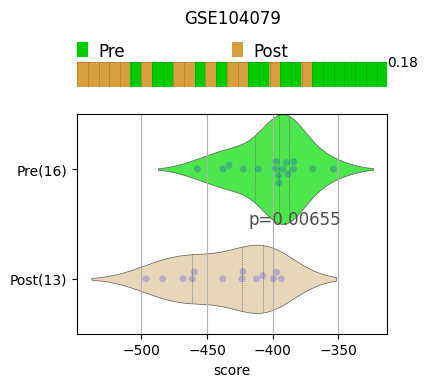

Popov 2019 Human One Leg Exercised (n = 84)
GSE120862 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M5
84 [42, 42] GSE120862 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M5 M5
[49, 113, 125]


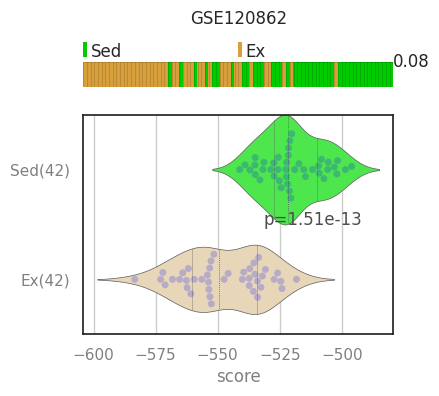

Turan 2013 Human COPD Patients (n = 54)
GSE27536 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M14
54 [27, 27] GSE27536 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M14 M14
[106]


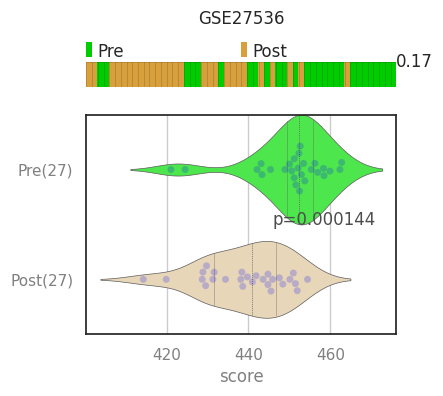

Abbasi 2016 Human Leukocytes Sex Specific Endotoxins and Exercise (n = 64)
GSE83578 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB8
64 [16, 16, 16, 16] GSE83578 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB8 MB8
[146, 403, 442]


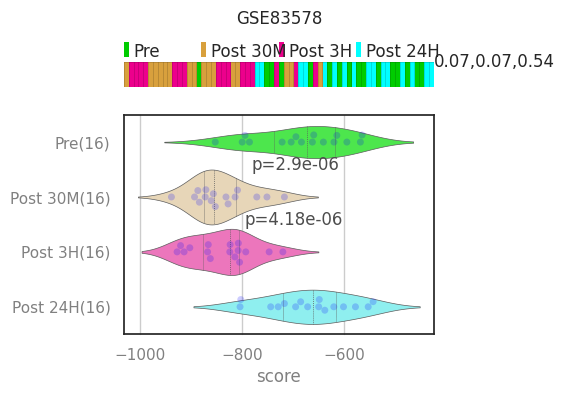

Silva 2018 Human Blood (n = 142)
GSE111555 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB2
32 [22, 10] GSE111555 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB2 MB2
[62, 132, 141]


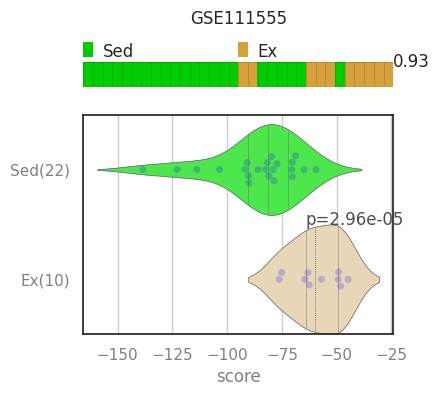

Laker 2017,  Human High Fat Diet and Exercise (n = 28)
GSE99963 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M74
28 [14, 14] GSE99963 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M74 M74
[48, 113, 124]


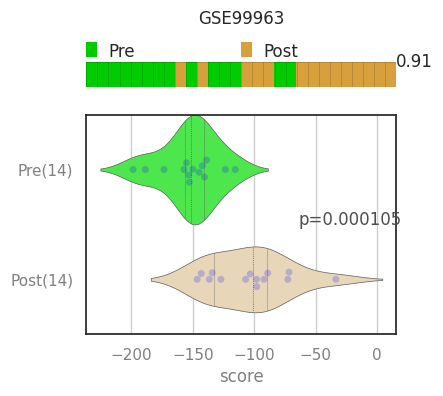

de Jong 2023, Homo sapiens, Muscle function in fit and (pre )frail males and females (n = 80)
GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98
56 [26, 30] GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98 MUSL98
[49, 113, 124]


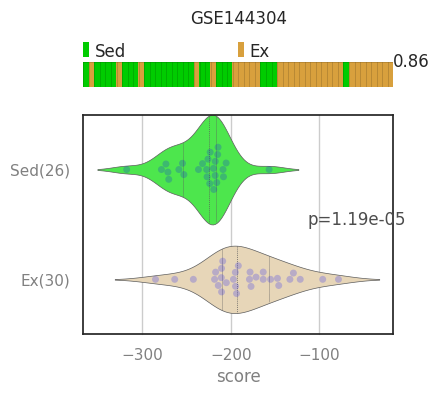

Gordon 2014, Human 12 Week One Arm RT One Arm Not (n = 14)
GSE28998 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M68
14 [7, 7] GSE28998 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M68 M68
[106, 361, 351]


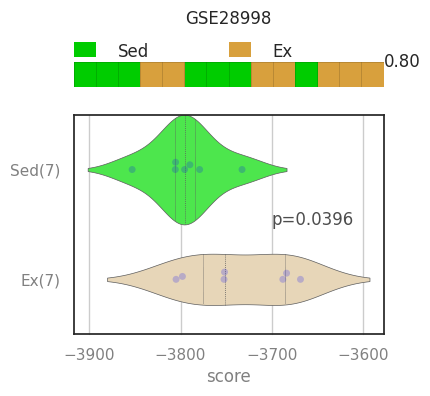

Chopard 2009, Homo sapiens, Sol and VL Post Bed Rest (n = 170)
GSE14798 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M61
80 [44, 36] GSE14798 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M61 M61
[81]


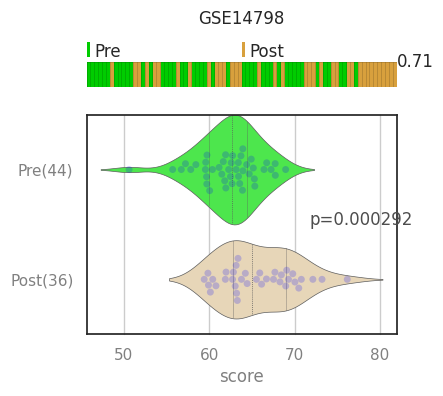

Abadi 2009, Human Unilateral Limb Immobilization (n = 72)
GSE14901 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M62
72 [24, 24, 24] GSE14901 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M62 M62
[106, 361, 351]


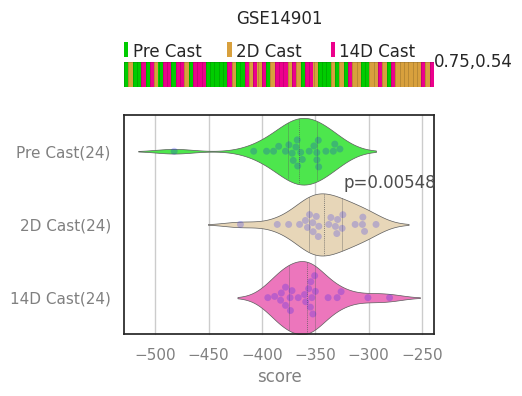

In [11]:
makeFigure2(save=True)

<a id="fig3"></a>
# Figure 3
[Return](#TOC)

In [17]:
def plotAllExercise(anaLst,l1,wt,pdf,save=False,show=True,plotTitle='Pre v Post'):
    """
    plotAllExercise
        Inputs: 
            anaLst, list (of tuples), with ana dataset, sample id, wt1 and wt2 of each dataset that will be plotted
            l1, list (of lists), list of lists containing genes from within a cluster
            useWt1, bool, if True will use the 2nd value in the anaLst tuple as the weight
                          if False, will use the 3rd value in the anaLst tuple as the weight
                    default:True
            save, bool, if True will save the plot, if False will overwrite savePdf and savePng
                    default=True
            show, bool, if True will show the plot 
                    default=True
            plotTitle, str, name for the title on the top of the barplots, deafault='Pre v Post'
        Output:
            resLst, list (of tuples), list of tuples containg the gse number, ROC-AUC value, and p-value of 
                    all the datasets that where included in the plot
            depneding on values of save/savePdf/savePng and show will also save and/or show the created plot
    """
    resLst=[]
    import bone
    reload(bone)
    fig = plt.figure(figsize=(10,10))
    n1 = len(anaLst)
    axlist = []
    for i in range(n1):
        ax = plt.subplot2grid((n1, 1), (i, 0))
        axlist.extend([ax])
    acolor = ["#00CC00", "#D8A03D","#EC008C",
              'cyan', "#B741DC", "#808285",
              'blue', 'black', 'green', 'red',
              'orange', 'brown', 'pink', 'purple']
    axNum=0
    for ana,gse in anaLst:
        ana.orderData(l1,wt)
        params = {'spaceAnn': 40, 'tAnn': 5, 'widthAnn':5, 'acolor': acolor,
                  'w': 5, 'h': 0.8, 'atypes': [],'cval': ana.cval, 'ax': axlist[axNum]}
        ax = ana.printTitleBar(params)
        res = ana.getMetrics(ana.cval[0])
        pval=getPval(ana)
        resLst.append((gse,res,pval))
        ax.text(len(ana.cval[0]), 4,res+', '+gse+' (n='+str(len(ana.cval[0]))+'), '+pval)
        axNum+=1
    ax=axlist[0]
    ax.set_title(plotTitle)
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()
    return resLst

<a id="fig6"></a>
# Figure 6
[Return](#TOC)

In [18]:
def getOppPattLists(runSig=True,sigFileName='Mac_M1M2_Sig_Genes.txt',runExOpp=True,fileName='Raue2012'):
    """
    getOppPattLists
        Inputs:
            runSig, bool, if True will run serch for significant M1/M2 genes, 
                          if False will get sig genes from reading the sigFileName file
                    default: True
            sigFileName, str, name/path of file which contains the M1/M2 significant genes, will be used if runSig=False
                    default: 'Mac_M1M2_Sig_Genes.txt'
            fileName, str, name/path of file which contains the exercise group 1 and group 2 genes, 
                            will be used if runExOpp=False
                    default: 'Raue2012'
    """
    if runSig:
        sigMacGenes=getSigMacGenes(allGenes,clust13Genes,clust14Genes,save=True,saveName=sigFileName)
    else:
        sigMacGenes=list(set(readLst(sigFileName)))
    if runExOpp:
        pattLst,oppLst=getOppandPatternGenes(sigMacGenes,clust13Genes,clust14Genes,savePlots=False,saveLists=True,show=False,fileName=fileName)
    else:
        filt=set(["'",'['])
        pattLst=readLst('MacPredictGenesPlots/'+fileName+'SigGenesPattern.txt',sep2=',',filt=filt)
        oppLst=readLst('MacPredictGenesPlots/'+fileName+'SigGenesOppisitePattern.txt',sep2=',',filt=filt)
    return pattLst,oppLst

In [19]:
def makeFig6A(pdf,save=False,show=True):
    wt=[-1,1,2]
    l1=pattLst
    reload(mut)
    ana = mut.MacAnalysis()
    ana.getGEOMacAnn()
    ana.orderDataDf(l1, wt)
    fig = mut.plotViolinBar(ana, "Mac")
    ana.getMacMetrics(ana.cval[0])
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()
        
    wt=[-1,1,2]
    l1=oppLst
    reload(mut)
    ana = mut.MacAnalysis()
    ana.getGEOMacAnn()
    ana.orderDataDf(l1, wt)
    fig = mut.plotViolinBar(ana, "Mac")
    ana.getMacMetrics(ana.cval[0])
    if save:
        pdf.savefig(transparent=True, bbox_inches = 'tight')
    if show:
        plt.show()
    else:
        plt.close()
    return 

def makeFig6B(pdf,save=False,show=True):
    pattLst,oppLst=getOppPattLists(runSig=False,sigFileName='Mac_M1M2_Sig_Genes.txt',runExOpp=False,fileName='Raue2012')
    anaLst=[]
    wt=[-1,1,2]
    
    ana=ExerciseAnalysis()
    gse='GSE126296'
    ana.getRundqvist2019(tn=1)
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getFurrer2023(tn=9)
    gse='GSE221210'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getAbbasi2016(tn=14)
    gse='GSE83578'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    gse='GSE122671'
    ana.getSawada2019()
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getRaue2012(tn=1)
    gse='GSE28422'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    gse='GSE99963'
    ana.getLaker2017(tn=1,simpleNames=True)
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getMacNeil2010(tn=7,simpleNames=True)
    gse='GSE19062'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getRowlands2011(tn=6)
    gse='GSE27285'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getCrane2012(tn=1)
    gse='GSE33603'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getMcLlvenna2022(tn=1,simpleNames=True)
    gse='GSE199225'
    wt1=multLst(wt)
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    l1=pattLst
    l2=oppLst
    plotAllExercise(anaLst, l1, pdf=pdf, useWt1=True, save=save, show=show,
                    plotTitle='Gene Model Group 1, Pre v Post (up to 6 Hours)')

    plotAllExercise(anaLst, l2, pdf=pdf, useWt1=False, save=save, show=show,
                    plotTitle='Gene Model Group 2, Pre v Post (up to 6 Hours)')
    return

def makeFig6C(pdf,save=False,show=True):
    pattLst,oppLst=getOppPattLists(runSig=False,sigFileName='Mac_M1M2_Sig_Genes.txt',runExOpp=False,fileName='Raue2012')
    wt=[-1,1,2]
    anaLst=[]

    ana=ExerciseAnalysis()
    ana.getButtner2007(tn=5)
    gse='GSE5105'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getClarke2018()
    gse='GSE117070'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getSilva2018(tn=2,simpleNames=True)
    gse='GSE111555'
    wt1=multLst(wt)
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    gse='GSE198266'
    ana.getLee2022(tn=1,simpleNames=True) 
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getVega2020(tn=4)
    gse='GSE139258'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getVanDenHoek2021(tn=4,simpleNames=True)
    gse='GSE179394'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getMelov2007(tn=2)
    gse='GSE8479'
    wt1=wt
    wt2=multLst(wt)
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getGordon2012(tn=1)
    gse='GSE28998'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getLanza2008(tn=3)
    gse='GSE9103'
    wt1=multLst(wt)
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    ana=ExerciseAnalysis()
    ana.getHangelbroek2016(tn=9,simpleNames=True)
    gse='GSE117525'
    wt1=wt
    wt2=wt
    anaLst.append((ana,gse,wt1,wt2))

    l1=pattLst
    l2=oppLst
    plotAllExercise(anaLst, l1, pdf=pdf, useWt1=True, save=save, show=show,
                    plotTitle='Gene Model Group 1, Sedentary vs Trained (at least 10 Weeks)')
    plotAllExercise(anaLst, l2, pdf=pdf, useWt1=False, save=save, show=show,
                    plotTitle='Gene Model Group 2, Sedentary vs Trained (at least 10 Weeks)')
    return
def makeFig6D(pdf,save=False,show=True):
    reload(Datasets)
    pattLst,oppLst=getOppPattLists(runSig=False,runExOpp=False,sigFileName='Mac_M1M2_Sig_Genes.txt',fileName='Raue2012')
    l1=pattLst
    l2=oppLst
    wt=[1,1,1]
    
    runLst=[]

    ana1=ExerciseAnalysis()
    ana1.getTakahama2024Sepsis(tn=5)
    gse1='GSE224146'
    runLst.append((ana1,gse1))

    ana2=ExerciseAnalysis()
    ana2.getSato2020(tn=2)
    gse2='GSE142068'
    runLst.append((ana2,gse2))

    ana3=ExerciseAnalysis()
    ana3.getMoore2023(tn=3)
    gse3='GSE230102'
    runLst.append((ana3,gse3))

    ana4=ExerciseAnalysis()
    ana4.getAuerbach2014(tn=3)
    gse4='GSE59927'
    runLst.append((ana4,gse4))
    for ana,gse in runLst:
        plotGroup1v2(pdf,ana,l1,l2,wt,gse,save=save,show=show)
    return

def makeFig6(save=False,show=True):
    if save:
        pdf=bone.getPDF('Figs/Figure4.pdf')
    else:
        pdf=None
    makeFig6A(pdf=pdf,save=save,show=show)
    makeFig6B(pdf=pdf,save=save,show=show)
    makeFig6C(pdf=pdf,save=save,show=show)
    makeFig6D(pdf=pdf,save=save,show=show)
    if save:
        pdf.close()
    return

Human Macrophages 2012 (n = 197)
GEO http://hegemon.ucsd.edu/Tools/explore.php?key=gbm&id=G16
68 [47, 13, 8] GEO http://hegemon.ucsd.edu/Tools/explore.php?key=gbm&id=G16 G16
[6, 7, 5]


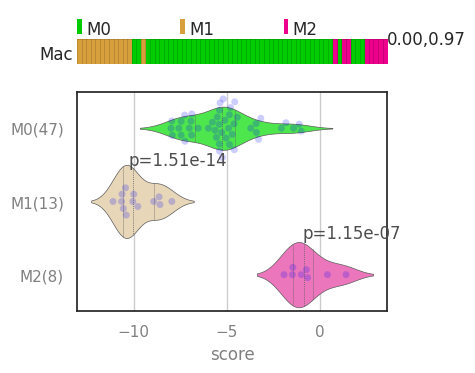

Human Macrophages 2012 (n = 197)
GEO http://hegemon.ucsd.edu/Tools/explore.php?key=gbm&id=G16
68 [47, 13, 8] GEO http://hegemon.ucsd.edu/Tools/explore.php?key=gbm&id=G16 G16
[6, 7, 17]


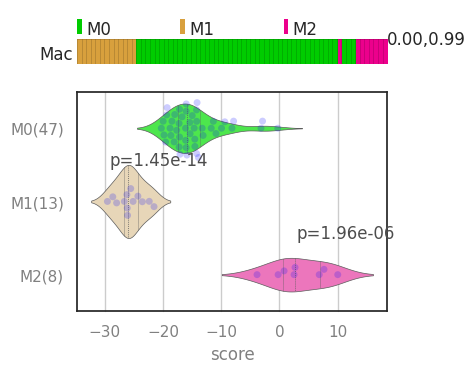

Rundqvist 2019 Sprint Excercise (n = 28)
GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2
28 [14, 14] GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2 M2
Furrer 2023, Mus musculu, Quadriceps muscle RNA seq of wildtype and PGC 1alpha muscle specific knockout and transgenic mice (n = 140)
GSE221210 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL95
40 [20, 20] GSE221210 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL95 MUSL95
Abbasi 2016 Human Leukocytes Sex Specific Endotoxins and Exercise (n = 64)
GSE83578 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB8
64 [32, 32] GSE83578 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB8 MB8
Sawada 2019 Human Leukocytes (n = 88)
GSE122671 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB1
88 [44, 44] GSE122671 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB1 MB1
Raue 2012 4 Hr Exercise Pre and Post 12 Week Training (n = 110)
GSE28422 http://hege

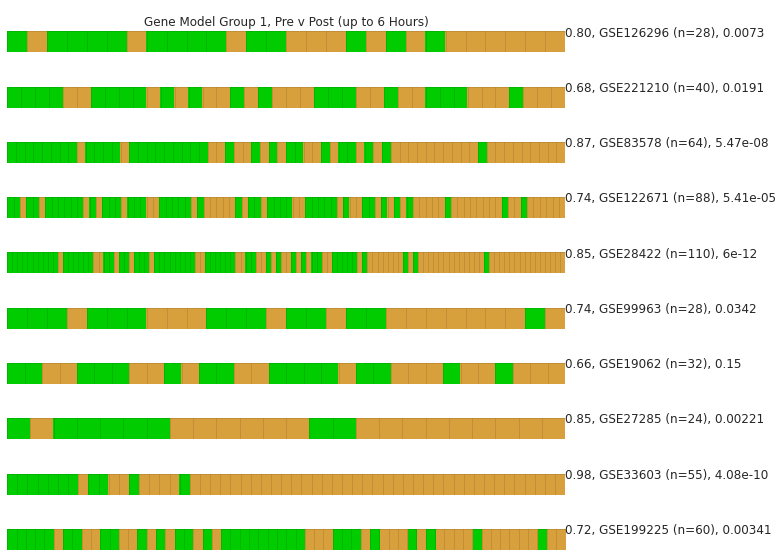

[4, 6, 10]
[3, 3, 7]
[16, 18, 24]
[6, 6, 12]
[9, 7, 22]
[3, 5, 10]
[5, 3, 8]
[6, 4, 10]
[27, 30, 45]
[3, 5, 10]


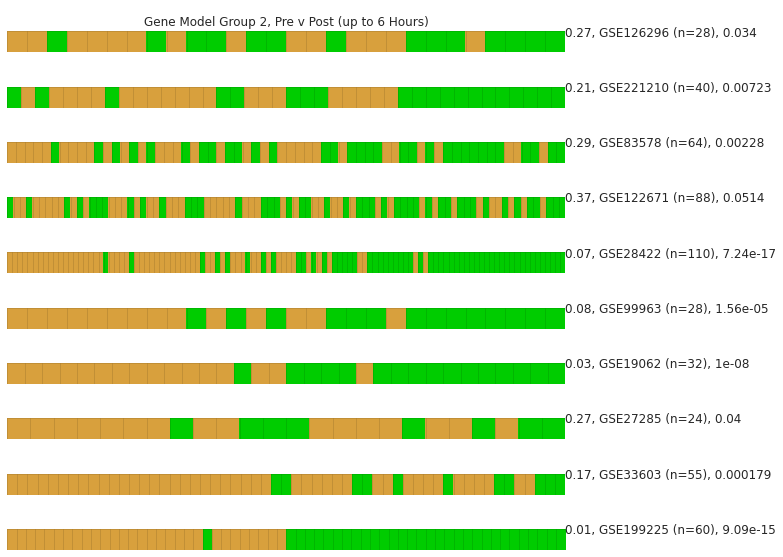

Buttner 2007 Human Tour De France T-lymphocytes and Monocytes (n = 66)
GSE5105 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB5
44 [7, 37] GSE5105 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB5 MB5
Clarke 2018 Human Heritage Family Study (n = 82)
GSE117070 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M7
82 [41, 41] GSE117070 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M7 M7
Silva 2018 Human Blood (n = 142)
GSE111555 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB2
32 [22, 10] GSE111555 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB2 MB2
Lee 2022, Mus musculus, Muscle fiber type dependence in aged models (n = 24)
GSE198266 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL104
24 [12, 12] GSE198266 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL104 MUSL104
Vega 2020 Human Skeletal Aerobic Exercise (n = 24)
GSE139258 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M33
18 [12, 6] GSE139258 

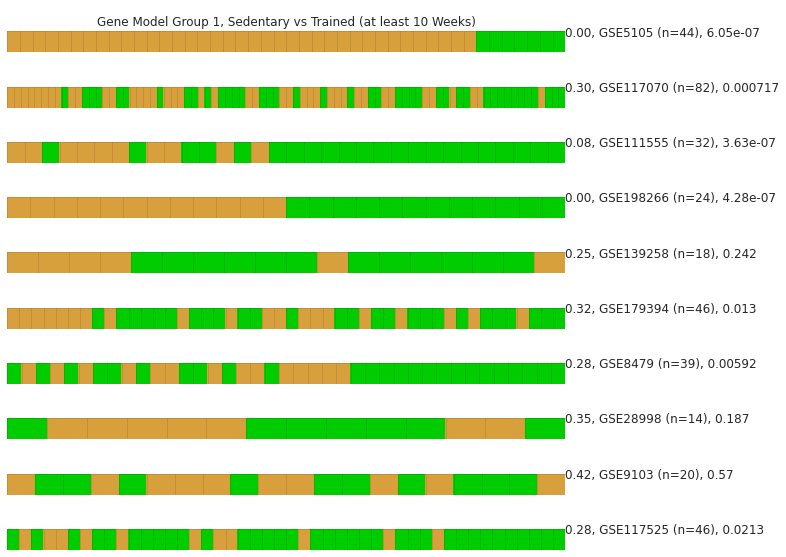

[9, 7, 22]
[9, 7, 22]
[3, 5, 10]
[3, 3, 7]
[9, 7, 12]
[3, 3, 7]
[6, 5, 10]
[9, 7, 22]
[9, 7, 22]
[3, 5, 10]


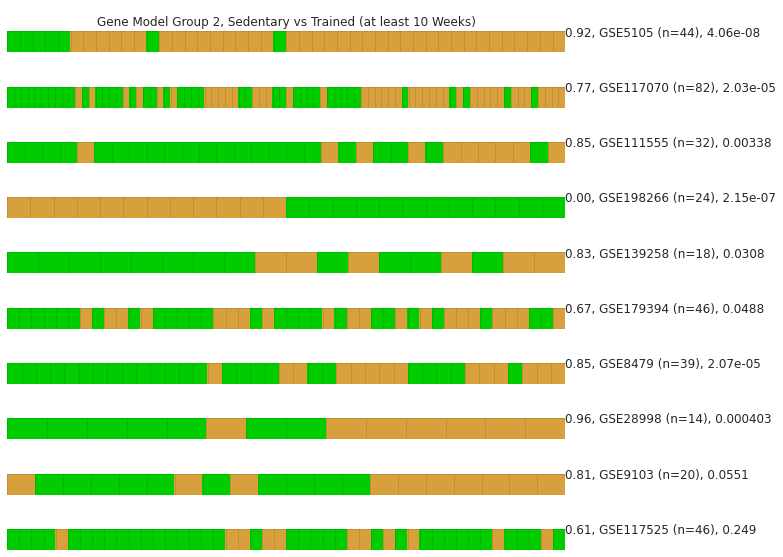

Takahama 2024 sepsis mm (n = 2413)
GSE224146 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV400
531 [264, 267] GSE224146 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV400 MACV400
Sato 2020 tissue drugs Mm (n = 868)
GSE142068 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV67
72 [36, 36] GSE142068 http://hegemon.ucsd.edu/Tools/explore.php?key=macv&id=MACV67 MACV67
Moore 2023, Mus Musculus, Adaptations to exercise training (n = 499)
GSE230102 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M105-0
200 [100, 100] GSE230102 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M105-0 M105-0
Auerbach 2014 drug Rat (n = 12921)
GSE59927 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV19
667 [562, 105] GSE59927 http://hegemon.ucsd.edu/Tools/explore.php?key=covid&id=COV19 COV19
[2, 4, 3]


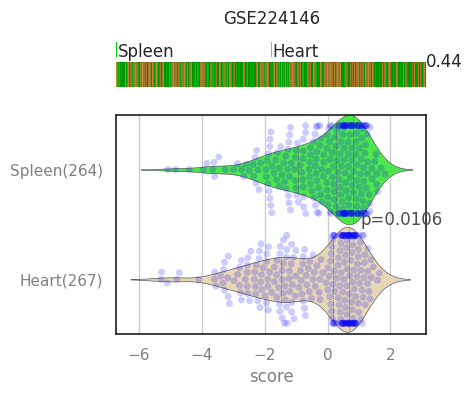

[3, 3, 7]


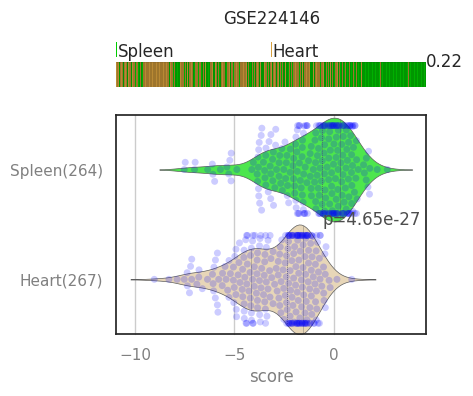

[2, 4, 3]


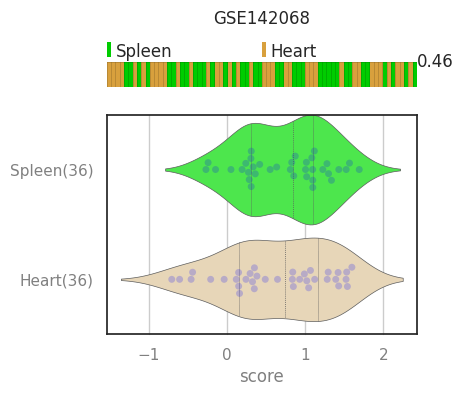

[3, 3, 7]


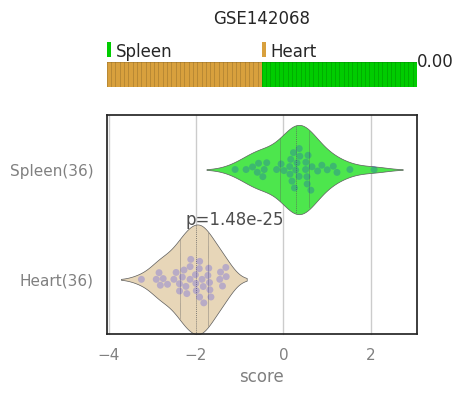

[2, 4, 3]


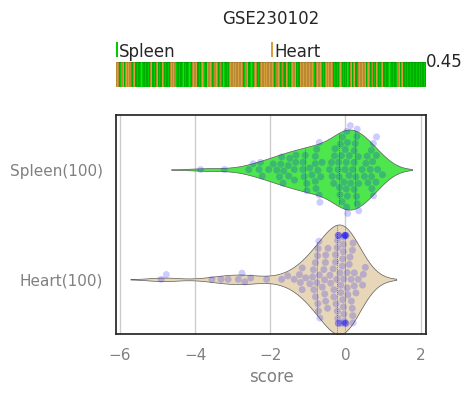

[3, 3, 7]


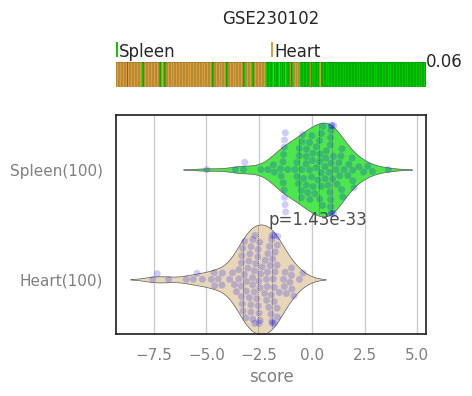

[0, 2, 1]


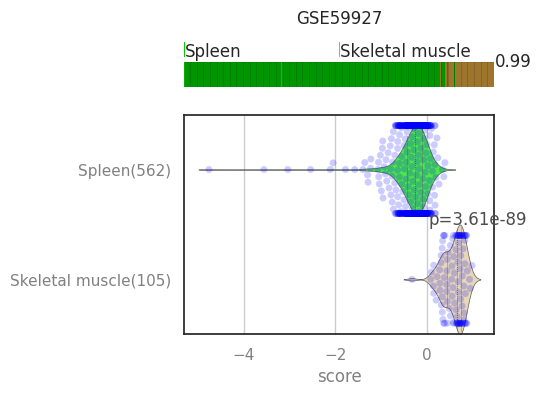

[1, 0, 1]


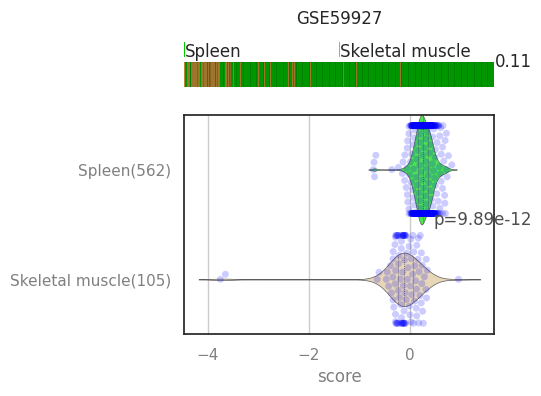

In [138]:
makeFig6(save=True)

<a id="sup2"></a>
# Figure 5
[Return](#TOC)

In [62]:
def makeCompareLst(resLst,condName,frst,snd):
    n=0
    for gse,auc,pval in gendResLst:
        if n%2==0:
            cond=frst
        else:
            cond=snd
        new_row=[gse,cond,float(auc),float(pval)]
        if n==0:
            df=pd.DataFrame(new_row).T
            df.columns=['ID',condName,'ROC-AUC','Pval']
        else:
            df.loc[len(df.index)]=new_row
        n+=1
    return df

def prePareFig5A(save=False):
    wt1=[-1,1,2]
    l1=macLst

    anaLst=[]

    gse='GSE117525'
    ana = ExerciseAnalysis()
    ana.getHangelbroek2016(tn=15)
    anaLst.append((ana,gse))
    
    ana = ExerciseAnalysis()
    ana.getHangelbroek2016(tn=14)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRundqvist2019(tn=3)
    gse='GSE126296'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRundqvist2019(tn=4)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getVega2020(tn=7)
    gse='GSE139258'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getVega2020(tn=10)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLavin2020(tn=5)
    gse='GSE140089'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLavin2020(tn=6)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=8)
    gse='GSE144304'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=9)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLiu2010(tn=8)
    gse='GSE24235'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLiu2010(tn=9)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRaue2012(tn=3)
    gse='GSE28422'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRaue2012(tn=2)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getGordon2012(tn=3)
    gse='GSE28998'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getGordon2012(tn=2)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getMcLean2015(tn=4)
    gse='GSE43219'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getMcLean2015(tn=3)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getScheler2013(tn=3)
    gse='GSE44051'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getScheler2013(tn=2)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLindholm2016(tn=9)
    gse='GSE60591'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLindholm2016(tn=8)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getColetta2016(tn=10)
    gse='GSE68585'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getColetta2016(tn=11)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getEdman2024(tn=10)
    gse='GSE252357'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getEdman2024(tn=11)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getEdman2024(tn=6)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getEdman2024(tn=7)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getBohm2016(tn=6)
    gse='GSE72462'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getBohm2016(tn=5)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getBarberio2016(tn=5)
    gse='GSE83352'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getBarberio2016(tn=2)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getAbbasi2016(tn=15)
    gse='GSE83578'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getAbbasi2016(tn=16)
    anaLst.append((ana,gse))
    
    ana = ExerciseAnalysis()
    ana.getMelov2007(tn=4)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getMelov2007(tn=3)
    gse='GSE8479'
    anaLst.append((ana,gse))

    gendResLst=plotAllExercise(anaLst,l1,wt1,pdf=None,show=False)
    df=makeCompareLst(gendResLst,condName='Gender',frst='Male',snd='Female')
    if save:
        df.to_csv('Gender_ROC_Pvals_Res.csv')
    return df

# Exercise Type
def prePareFig5B(save=False):
    wt1=[-1,1,2]
    l1=macLst

    anaLst=[]

    ana = ExerciseAnalysis()
    ana.getTonevitsky2013(tn=5)
    gse='GSE46075'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getTonevitsky2013(tn=7)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRobinson2017(tn=9)
    gse='GSE97084'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRobinson2017(tn=12)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getStepto2009(tn=2)
    gse='GSE9405'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getStepto2009(tn=3)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getSchjerling2014(tn=3)
    gse='GSE59088'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getSchjerling2014(tn=4)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRowlands2014(tn=6)
    gse='GSE58249'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRowlands2014(tn=9)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getDeSanctis2021(tn=4)
    gse='GSE165630'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getDeSanctis2021(tn=3)
    anaLst.append((ana,gse))

    exercisetypeResLst=plotAllExercise(anaLst,l1,wt1,pdf=None,show=False)
    df=makeCompareLst(intensityResLst,condName='Exercise Type',
                      frst='Endurance/Aerobic',snd='Resistance/Strength')
    if save:
        df.to_csv('ExerciseType_ROC_Pvals_Res.csv')
    return df

def prePareFig5C(save=False):
    wt1=[-1,1,2]
    l1=macLst

    anaLst=[]

    ana = ExerciseAnalysis()
    ana.getSilva2018(tn=7)
    gse='GSE111555'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getSilva2018(tn=8)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=11)
    gse='GSE144304'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=12)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRampersaud2013(tn=8)
    gse='GSE34788'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRampersaud2013(tn=9)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getTonevitsky2013(tn=5)
    gse='GSE46075'
    anaLst.append((ana,gse))

    intensityResLst=plotAllExercise(anaLst,l1,wt1,pdf=None,show=False)
    df=makeCompareLst(intensityResLst,condName='Intensity',frst='Low',snd='High')
    if save:
        df.to_csv('Intensity_ROC_Pvals_Res.csv')
    return df

def prePareFig5D(save=False):
    wt1=[-1,1,2]
    l1=macLst

    anaLst=[]

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=6)
    gse='GSE144304'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getdeJong2023(tn=4)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLee2022(tn=6)
    gse='GSE198266'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getLee2022(tn=5)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRubenstien2020(tn=4)
    gse='GSE236600'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRubenstien2020(tn=9)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRaue2012(tn=7)
    gse='GSE28422'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRaue2012(tn=13)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getMelov2007(tn=7) 
    gse='GSE8479'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getMelov2007(tn=3)
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRobinson2017(tn=9)
    gse='GSE97084'
    anaLst.append((ana,gse))

    ana = ExerciseAnalysis()
    ana.getRobinson2017(tn=8)
    anaLst.append((ana,gse))

    ageResLst=plotAllExercise(anaLst,l1,wt1,pdf=None,show=False)
    df=makeCompareLst(ageResLst,condName='Age',frst='Young',snd='Old')
    if save:
        df.to_csv('Age_ROC_Pvals_Res.csv')
    return df

def prePareFig5(save=False):
    genderDf=prePareFig5A(save)
    exerciseTypeDf=prePareFig5B(save)
    intensityDf=prePareFig5C(save)
    ageDf=prePareFig5D(save)
    dfLst=[genderDf,exerciseTypeDf,intensityDf,ageDf]
    df=pd.concat(dfLst)
    df.fillna('')
    if save:
        df.to_csv('SupplementaryTable2_Genders_ExerciseTypes_Intensities_Ages.csv',index=False)
    return df



In [63]:
prePareFig5(save=True)

Hangelbroek 2016, Human 6 Month Resistance Train in Old and Frail (n = 259)
GSE117525 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M66
79 [53, 26] GSE117525 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M66 M66
Hangelbroek 2016, Human 6 Month Resistance Train in Old and Frail (n = 259)
GSE117525 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M66
35 [20, 15] GSE117525 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M66 M66
Rundqvist 2019 Sprint Excercise (n = 28)
GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2
14 [7, 7] GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2 M2
Rundqvist 2019 Sprint Excercise (n = 28)
GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2
14 [7, 7] GSE126296 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M2 M2
Vega 2020 Human Skeletal Aerobic Exercise (n = 24)
GSE139258 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M33
4 [2, 2] GSE139258 http://hegem

[46, 103, 116]
[46, 103, 116]
[54, 150, 163]
[54, 150, 163]
[93, 246, 244]
[93, 246, 244]
[48, 113, 124]
[48, 113, 124]


/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[49, 113, 124]
[49, 113, 124]
[106, 361, 351]
[106, 361, 351]
[106, 361, 351]
[106, 361, 351]
[106, 361, 351]
[106, 361, 351]
[115, 283, 272]
[115, 283, 272]
[54, 150, 163]
[54, 150, 163]
[47, 112, 122]
[47, 112, 122]
[79, 255, 253]
[79, 255, 253]


/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[47, 111, 121]
[47, 111, 121]
[47, 111, 121]
[47, 111, 121]
[62, 132, 141]


/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[62, 132, 141]
[78, 202, 200]
[78, 202, 200]
[146, 403, 442]
[146, 403, 442]
[68, 129, 135]
[68, 129, 135]
Tonevitsky 2013 Human miRNA mRNA regulatory networks (n = 56)
GSE46075 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB4
16 [8, 8] GSE46075 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB4 MB4
Tonevitsky 2013 Human miRNA mRNA regulatory networks (n = 56)
GSE46075 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB4
16 [8, 8] GSE46075 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MB4 MB4
Robinson 2017, Human HIIT RT and Combined Exercise (n = 103)
GSE97084 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M75
21 [10, 11] GSE97084 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M75 M75
Robinson 2017, Human HIIT RT and Combined Exercise (n = 103)
GSE97084 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M75
20 [10, 10] GSE97084 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=M75 M75
Stepto 2007 Human Real Time PCR Ath

/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/mnt/booleanfs2/sahoo/Data/BooleanLab/venv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[62, 132, 141]
[49, 113, 124]
[49, 113, 124]
[54, 150, 163]
[54, 150, 163]
[54, 150, 163]
de Jong 2023, Homo sapiens, Muscle function in fit and (pre )frail males and females (n = 80)
GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98
26 [13, 13] GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98 MUSL98
de Jong 2023, Homo sapiens, Muscle function in fit and (pre )frail males and females (n = 80)
GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98
28 [13, 15] GSE144304 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL98 MUSL98
Lee 2022, Mus musculus, Muscle fiber type dependence in aged models (n = 24)
GSE198266 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL104
6 [3, 3] GSE198266 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL104 MUSL104
Lee 2022, Mus musculus, Muscle fiber type dependence in aged models (n = 24)
GSE198266 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=MUSL104

,ID,Gender,ROC-AUC,Pval,Exercise Type,Intensity,Age
0,GSE117525,Male,0.45,0.479,NaN,NaN,NaN
1,GSE117525,Female,0.39,0.0786,NaN,NaN,NaN
2,GSE126296,Male,0.31,0.387,NaN,NaN,NaN
3,GSE126296,Female,0.41,0.589,NaN,NaN,NaN
4,GSE139258,Male,0.25,0.623,NaN,NaN,NaN
...,...,...,...,...,...,...,...
31,GSE83352,NaN,0.45,0.665,NaN,NaN,Old
32,GSE83578,NaN,0.03,4.64e-05,NaN,NaN,Young
33,GSE83578,NaN,0.07,0.00328,NaN,NaN,Old
34,GSE8479,NaN,0.21,0.0124,NaN,NaN,Young


<a id="ann"></a>
# Checking Annotation
[Return](#TOC)

In [14]:
import bone
reload(bone)
hu=bone.hu
reload(hu)
db=hu.Database("/Users/yovosko/public_html/Hegemon/explore.conf")
#db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
#db = hu.Database("/Users/sataheri/public_html/Hegemon/explore.conf")
#db = hu.Database("/Users/mahdi/public_html/Hegemon/explore.conf")
dbid = "MUSL95"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
atype = h.getSurvName('c group_ch1')
hu.uniq(atype)

[12,
 'c group_ch1',
 'wildtype untrained, sedentary',
 'wildtype untrained, exercise',
 'wildtype trained',
 'wildtype trained, exercise',
 'PGC-1alpha muscle-specific knockout untrained, sedentary',
 'PGC-1alpha muscle-specific transgenic untrained, sedentary',
 'PGC-1alpha muscle-specific knockout untrained, exercise',
 'PGC-1alpha muscle-specific knockout trained',
 'PGC-1alpha muscle-specific knockout trained, exercise']